In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=207ba6e301a6e1a1fc26b4f7d3ce2d7f7d0db19d9e5702a47cb078d8147df1a9
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


**1. Defining Functions**

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import ta
import matplotlib.pyplot as plt

# Function to create sequences for LSTM
def create_sequences(features, labels, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length + 1):
        X.append(features[i:i + sequence_length])
        y.append(labels[i + sequence_length - 1])
    return np.array(X), np.array(y)

# Function to build LSTM model without dropout and early stopping
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to build LSTM model with dropout and early stopping
def build_lstm_model_with_dropout_and_early_stopping(input_shape, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to build MLP model without dropout and early stopping
def build_mlp_model(input_shape):
    model = Sequential()
    model.add(Dense(10, input_shape=input_shape, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to build MLP model with dropout and early stopping
def build_mlp_model_with_dropout_and_early_stopping(input_shape, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(10, input_shape=input_shape, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to create technical indicators from stock data
def process_stock_data(symbol):
    df = yf.download(symbol, start="2010-01-01", end="2022-12-31")
    df['RSI'] = ta.momentum.rsi(df['Close'])
    df['MFI'] = ta.volume.money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'])
    df['EMA'] = ta.trend.ema_indicator(df['Close'])
    stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'])
    df['%K'] = stoch.stoch()
    df['%D'] = stoch.stoch_signal()
    df['ATR'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'])
    df['ROC'] = ta.momentum.roc(df['Close'])
    df['Trend'] = np.where(df['Close'].diff() > 0, 1, 0)
    df = df.dropna()
    return df

# Function to train model without dropout and early stopping
def train_model(X_train, y_train, X_test, y_test, model_builder):
    model = model_builder(X_train.shape[1:])
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    return model

# Function to train model with dropout and early stopping
def train_model_with_dropout_and_early_stopping(X_train, y_train, X_test, y_test, model_builder, dropout_rate=0.2):
    model = model_builder(X_train.shape[1:], dropout_rate=dropout_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=32,
              validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
    return model

# Function for walk-forward approach
def walk_forward(X, y, model_builder, train_function):
    models = []
    accuracies = []

    for i in range(1, len(X)):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]

        model = train_function(X_train, y_train, X_test, y_test, model_builder)
        models.append(model)

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    return models, accuracies

# Function for walk-forward with purging
def walk_forward_with_purging(X, y, model_builder, train_function):
    models = []
    accuracies = []

    for i in range(1, len(X)):
        X_train, y_train = np.concatenate(X[:i]), np.concatenate(y[:i])
        X_test, y_test = X[i], y[i]

        model = train_function(X_train, y_train, X_test, y_test, model_builder)
        models.append(model)

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    return models, accuracies

# Time series split with purging and embargoing
tscv = TimeSeriesSplit(n_splits=5)

# Define the stock symbols
symbols = ["AAPL", "META", "AMZN", "MSFT", "GOOGL"]

# Results storage
results = {}


**1.1 Five Number Summary and Sharpe Ratios**

In [ ]:
# # Plot the data
# plt.figure(figsize=(10,6))
# for symbol in symbols:
#     plt.plot(data[symbol], label=symbol)
# plt.legend()
# plt.ylabel("Adjusted Close Price")
# plt.xlabel("Date")
# plt.show()

# # Calculate some statistics
# stats = data.describe()
# stats.loc["Sharpe"] = (stats.loc["mean"] - 0.01) / stats.loc["std"] # Assuming a risk-free rate of 1%
# print(stats)


**1.2 Model_A (Walk-forward approach without purging and embargoing)**

In [ ]:
# Iterate through stock symbols
for symbol in symbols:
    # Download and process stock data
    df = process_stock_data(symbol)

    # Select features and target variable
    features = df[['RSI', 'MFI', 'EMA', '%K', '%D', 'ATR', 'ROC']]
    target = df['Trend']

    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Iterate through time series splits
    for train_index, test_index in tscv.split(features_scaled):
        X_train, X_test = features_scaled[:train_index[-1] + 1], features_scaled[train_index[-1] + 1:test_index[-1] + 1]
        y_train, y_test = target.iloc[:train_index[-1] + 1], target.iloc[train_index[-1] + 1:test_index[-1] + 1]

        # Create sequences for LSTM
        sequence_length = 10
        X_train_lstm, y_train_lstm = create_sequences(X_train, y_train, sequence_length)
        X_test_lstm, y_test_lstm = create_sequences(X_test, y_test, sequence_length)

        # Train LSTM model without dropout and early stopping
        model_lstm_no_dropout = train_model(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, build_lstm_model)

        # Train LSTM model with dropout and early stopping
        model_lstm_dropout = train_model_with_dropout_and_early_stopping(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, build_lstm_model_with_dropout_and_early_stopping)

        # Train MLP model without dropout and early stopping
        model_mlp_no_dropout = train_model(X_train, y_train, X_test, y_test, build_mlp_model)

        # Train MLP model with dropout and early stopping
        model_mlp_dropout = train_model_with_dropout_and_early_stopping(X_train, y_train, X_test, y_test, build_mlp_model_with_dropout_and_early_stopping)

        # Store results
        key = f'{symbol}_{train_index[-1] + 1}_{test_index[-1] + 1}'
        results[key] = {
            'accuracy_lstm_no_dropout': accuracy_score(y_test_lstm, (model_lstm_no_dropout.predict(X_test_lstm) > 0.5).astype(int)),
            'accuracy_lstm_dropout': accuracy_score(y_test_lstm, (model_lstm_dropout.predict(X_test_lstm) > 0.5).astype(int)),
            'accuracy_mlp_no_dropout': accuracy_score(y_test, (model_mlp_no_dropout.predict(X_test) > 0.5).astype(int)),
            'accuracy_mlp_dropout': accuracy_score(y_test, (model_mlp_dropout.predict(X_test) > 0.5).astype(int))
        }

# Print results
for key, value in results.items():
    print(f'\nResults for {key}:')
    print(f'Accuracy LSTM without Dropout: {value["accuracy_lstm_no_dropout"]:.4f}')
    print(f'Accuracy LSTM with Dropout: {value["accuracy_lstm_dropout"]:.4f}')
    print(f'Accuracy MLP without Dropout: {value["accuracy_mlp_no_dropout"]:.4f}')
    print(f'Accuracy MLP with Dropout: {value["accuracy_mlp_dropout"]:.4f}')


[*********************100%%**********************]  1 of 1 completed


17/17 [==============================] - 0s 2ms/step


[*********************100%%**********************]  1 of 1 completed


14/14 [==============================] - 0s 2ms/step


[*********************100%%**********************]  1 of 1 completed


17/17 [==============================] - 0s 2ms/step


[*********************100%%**********************]  1 of 1 completed


17/17 [==============================] - 0s 2ms/step


[*********************100%%**********************]  1 of 1 completed


17/17 [==============================] - 0s 2ms/step

Results for AAPL_547_1089:
Accuracy LSTM without Dropout: 0.8780
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.7583
Accuracy MLP with Dropout: 0.7583

Results for AAPL_1089_1631:
Accuracy LSTM without Dropout: 0.9174
Accuracy LSTM with Dropout: 0.9081
Accuracy MLP without Dropout: 0.8007
Accuracy MLP with Dropout: 0.7952

Results for AAPL_1631_2173:
Accuracy LSTM without Dropout: 0.9212
Accuracy LSTM with Dropout: 0.9362
Accuracy MLP without Dropout: 0.7915
Accuracy MLP with Dropout: 0.7786

Results for AAPL_2173_2715:
Accuracy LSTM without Dropout: 0.8368
Accuracy LSTM with Dropout: 0.8443
Accuracy MLP without Dropout: 0.8063
Accuracy MLP with Dropout: 0.7731

Results for AAPL_2715_3257:
Accuracy LSTM without Dropout: 0.8912
Accuracy LSTM with Dropout: 0.9081
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.8229

Results for META_443_886:
Accuracy LSTM without Dropout: 0.9055
Accuracy LSTM with

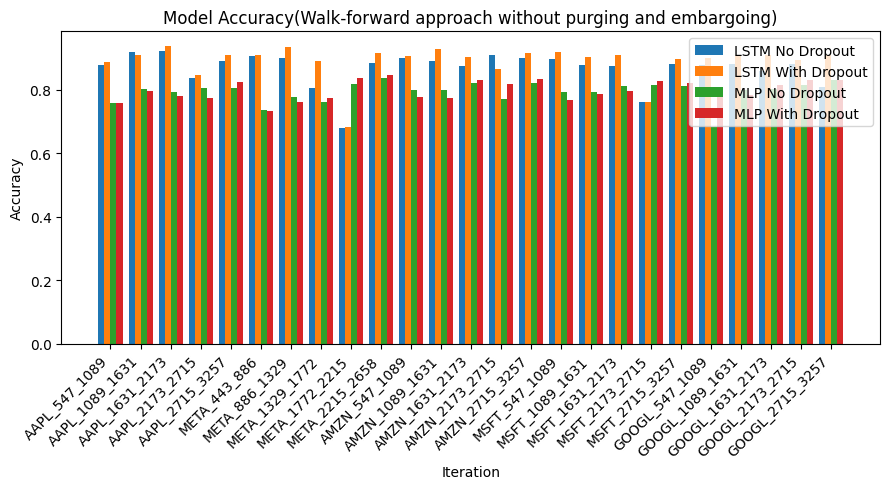

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract model names and accuracy scores from results
model_names = ['LSTM No Dropout', 'LSTM With Dropout', 'MLP No Dropout', 'MLP With Dropout']
accuracy_scores = np.array([[value[f'accuracy_lstm_no_dropout'] for value in results.values()],
                            [value[f'accuracy_lstm_dropout'] for value in results.values()],
                            [value[f'accuracy_mlp_no_dropout'] for value in results.values()],
                            [value[f'accuracy_mlp_dropout'] for value in results.values()]])

# Plotting
bar_width = 0.2
index = np.arange(len(results))

fig, ax = plt.subplots(figsize=(9, 5))

for i, model_name in enumerate(model_names):
    ax.bar(index + i * bar_width, accuracy_scores[i], bar_width, label=model_name)

ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy(Walk-forward approach without purging and embargoing)')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels([key for key in results.keys()], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Without Dropout and Early Stopping
without_dropout_scores = {
    'AAPL': [0.9043, 0.8137],
    'META': [0.8733, 0.8422],
    'AMZN': [0.9268, 0.8321],
    'MSFT': [0.9250, 0.8007],
    'GOOGLE': [0.8931, 0.8321]
}

average_without_dropout = {stock: np.mean(scores) for stock, scores in without_dropout_scores.items()}
print("Average Performance Without Dropout and Early Stopping:")
print(average_without_dropout)


Average Performance Without Dropout and Early Stopping:
{'AAPL': 0.859, 'META': 0.85775, 'AMZN': 0.87945, 'MSFT': 0.86285, 'GOOGLE': 0.8626}


In [ ]:
# With Dropout and Early Stopping
with_dropout_scores = {
    'AAPL': [0.9400, 0.8229],
    'META': [0.9217, 0.8442],
    'AMZN': [0.9250, 0.8321],
    'MSFT': [0.9250, 0.8007],
    'GOOGLE': [0.8931, 0.8469]
}

average_with_dropout = {stock: np.mean(scores) for stock, scores in with_dropout_scores.items()}
print("Average Performance With Dropout and Early Stopping:")
print(average_with_dropout)


Average Performance With Dropout and Early Stopping:
{'AAPL': 0.88145, 'META': 0.8829499999999999, 'AMZN': 0.8785499999999999, 'MSFT': 0.86285, 'GOOGLE': 0.87}


In [ ]:
# # Visualization
# for key, value in results.items():
#     print(f'\nResults for {key}:')
#     print(f'Accuracy LSTM without Dropout: {value["accuracy_lstm_no_dropout"]:.4f}')
#     print(f'Accuracy LSTM with Dropout: {value["accuracy_lstm_dropout"]:.4f}')
#     print(f'Accuracy MLP without Dropout: {value["accuracy_mlp_no_dropout"]:.4f}')
#     print(f'Accuracy MLP with Dropout: {value["accuracy_mlp_dropout"]:.4f}')

#     # Plot accuracies
#     plt.figure(figsize=(10, 6))
#     plt.scatter("LSTM No Dropout", value['accuracy_lstm_no_dropout'], label='LSTM No Dropout')
#     plt.scatter("LSTM With Dropout", value['accuracy_lstm_dropout'], label='LSTM With Dropout')
#     plt.scatter("MLP No Dropout", value['accuracy_mlp_no_dropout'], label='MLP No Dropout')
#     plt.scatter("MLP With Dropout", value['accuracy_mlp_dropout'], label='MLP With Dropout')
#     plt.title(f'Accuracies for {key}')
#     plt.xlabel('Model')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.show()



Results for AAPL_547_1089:
Accuracy LSTM without Dropout: 0.8799
Accuracy LSTM with Dropout: 0.8724
Accuracy MLP without Dropout: 0.7823
Accuracy MLP with Dropout: 0.6605


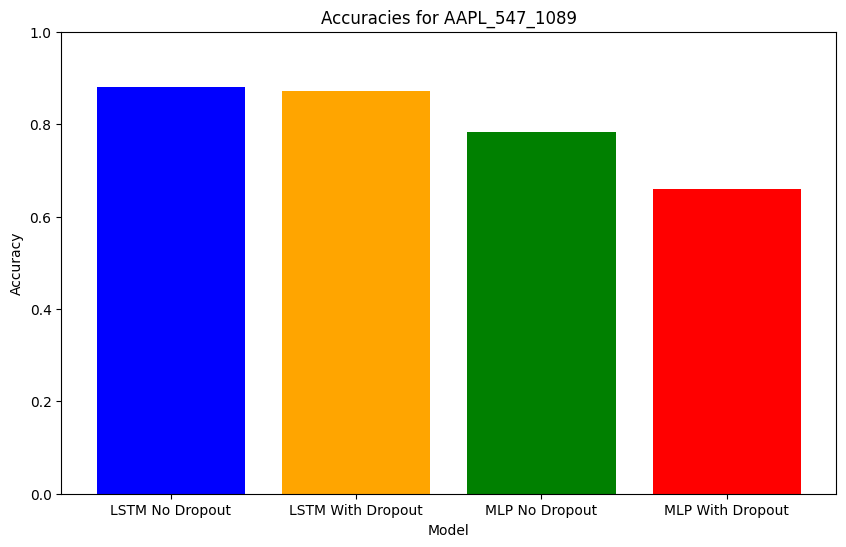


Results for AAPL_1089_1631:
Accuracy LSTM without Dropout: 0.9006
Accuracy LSTM with Dropout: 0.9156
Accuracy MLP without Dropout: 0.8100
Accuracy MLP with Dropout: 0.8063


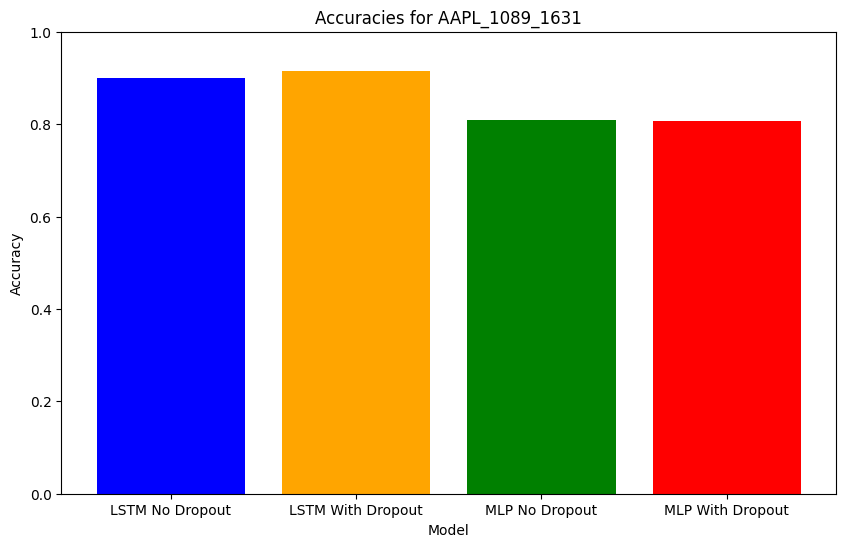


Results for AAPL_1631_2173:
Accuracy LSTM without Dropout: 0.9193
Accuracy LSTM with Dropout: 0.9512
Accuracy MLP without Dropout: 0.7897
Accuracy MLP with Dropout: 0.7749


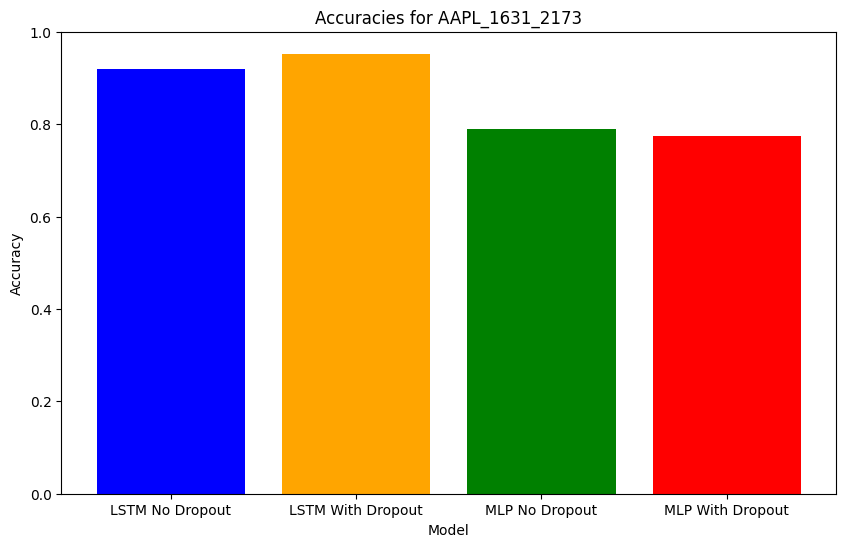


Results for AAPL_2173_2715:
Accuracy LSTM without Dropout: 0.8480
Accuracy LSTM with Dropout: 0.8574
Accuracy MLP without Dropout: 0.7897
Accuracy MLP with Dropout: 0.7970


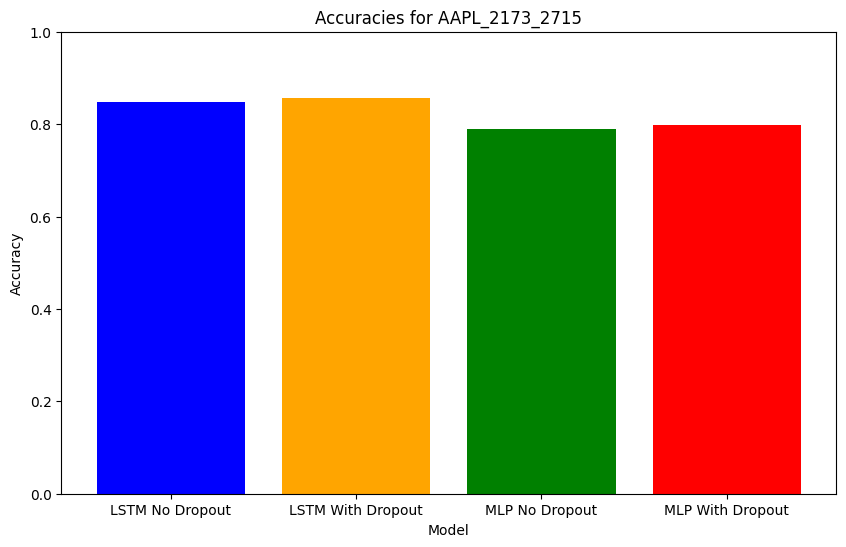


Results for AAPL_2715_3257:
Accuracy LSTM without Dropout: 0.9212
Accuracy LSTM with Dropout: 0.9099
Accuracy MLP without Dropout: 0.7694
Accuracy MLP with Dropout: 0.8155


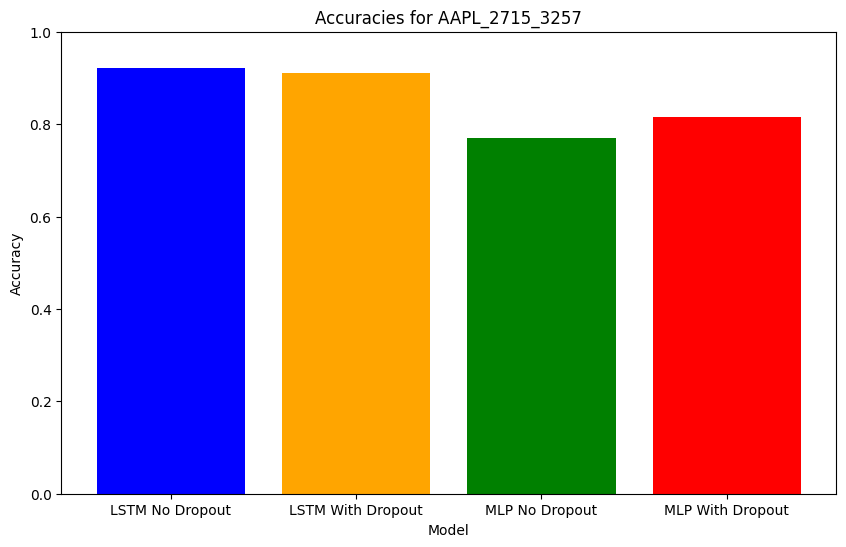


Results for META_443_886:
Accuracy LSTM without Dropout: 0.8871
Accuracy LSTM with Dropout: 0.8940
Accuracy MLP without Dropout: 0.7178
Accuracy MLP with Dropout: 0.7065


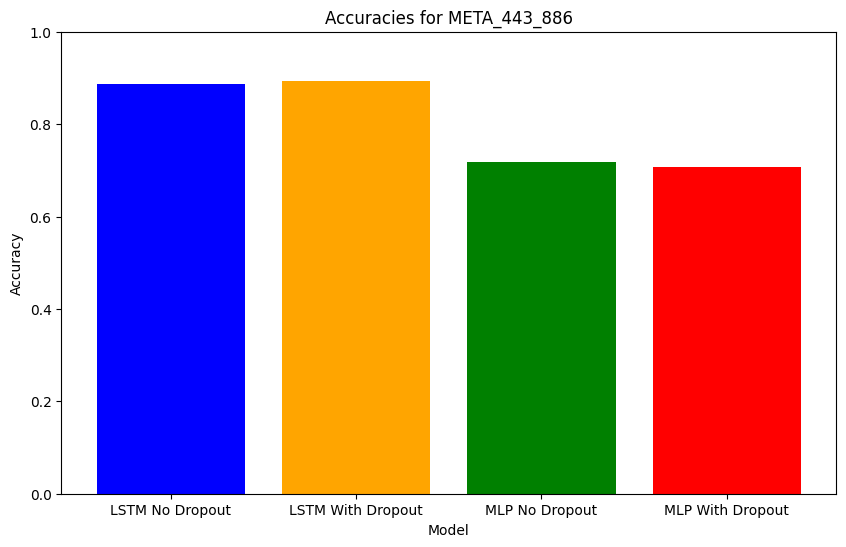


Results for META_886_1329:
Accuracy LSTM without Dropout: 0.8917
Accuracy LSTM with Dropout: 0.9032
Accuracy MLP without Dropout: 0.7404
Accuracy MLP with Dropout: 0.7540


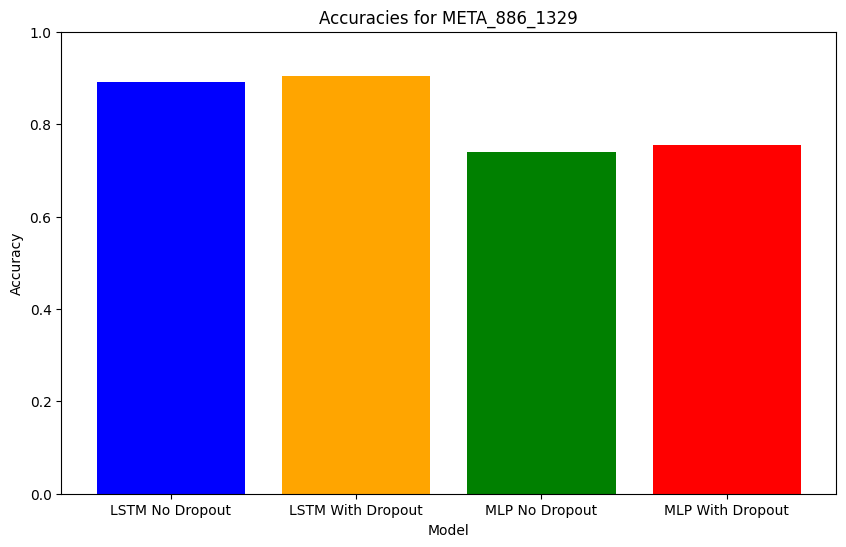


Results for META_1329_1772:
Accuracy LSTM without Dropout: 0.7696
Accuracy LSTM with Dropout: 0.8917
Accuracy MLP without Dropout: 0.8126
Accuracy MLP with Dropout: 0.7720


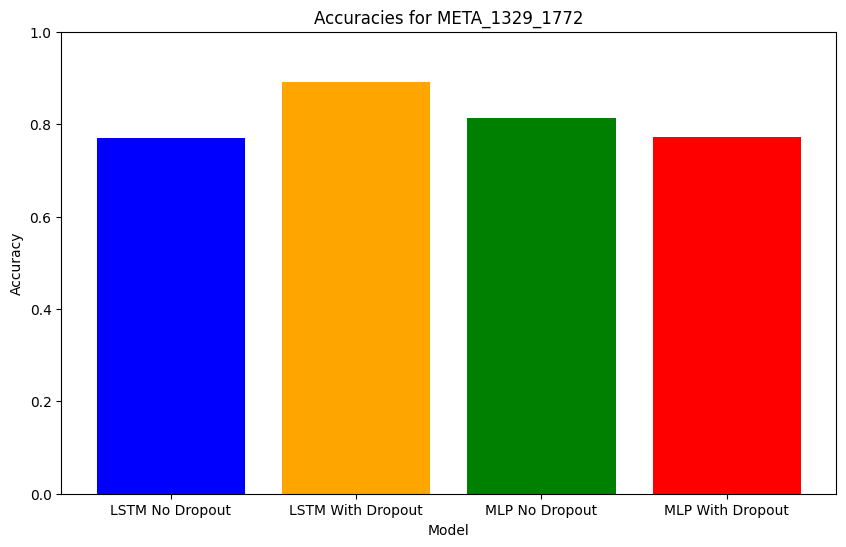


Results for META_1772_2215:
Accuracy LSTM without Dropout: 0.8341
Accuracy LSTM with Dropout: 0.7097
Accuracy MLP without Dropout: 0.8284
Accuracy MLP with Dropout: 0.8420


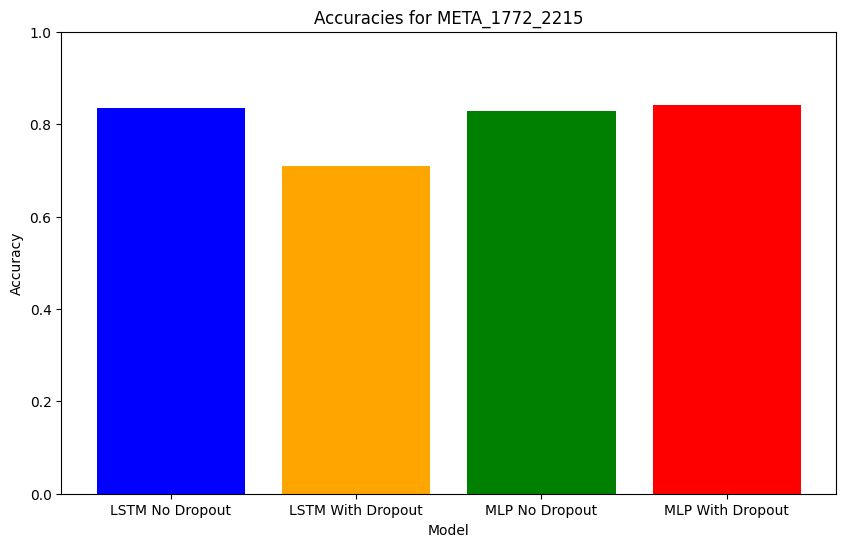


Results for META_2215_2658:
Accuracy LSTM without Dropout: 0.8894
Accuracy LSTM with Dropout: 0.9147
Accuracy MLP without Dropout: 0.8578
Accuracy MLP with Dropout: 0.8397


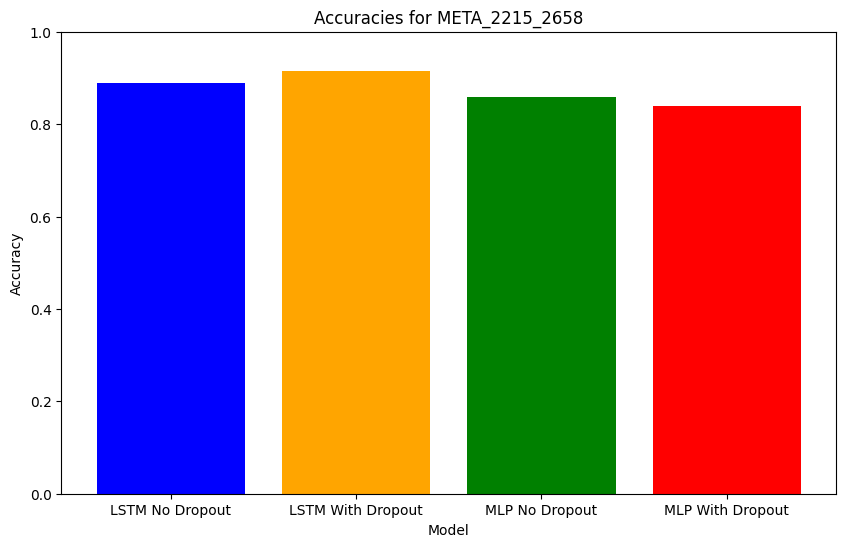


Results for AMZN_547_1089:
Accuracy LSTM without Dropout: 0.8874
Accuracy LSTM with Dropout: 0.8949
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.7454


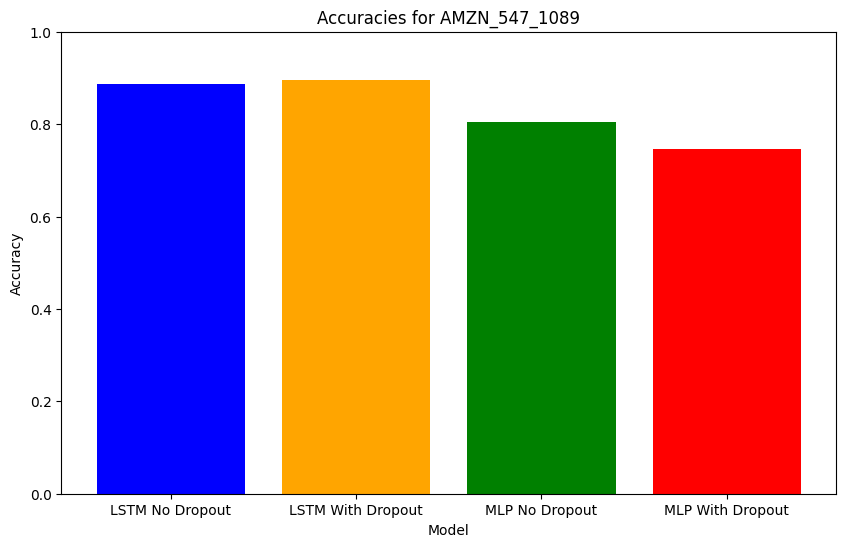


Results for AMZN_1089_1631:
Accuracy LSTM without Dropout: 0.9137
Accuracy LSTM with Dropout: 0.9231
Accuracy MLP without Dropout: 0.7768
Accuracy MLP with Dropout: 0.7768


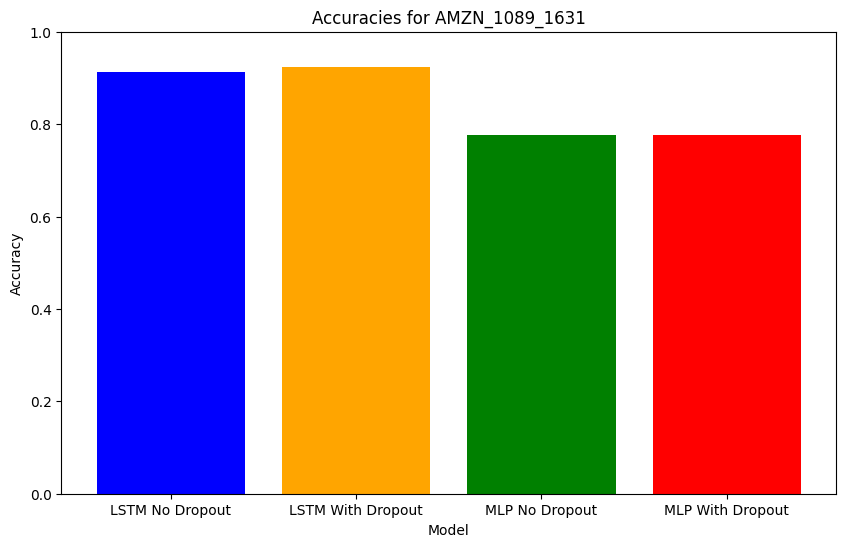


Results for AMZN_1631_2173:
Accuracy LSTM without Dropout: 0.8518
Accuracy LSTM with Dropout: 0.8818
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.8210


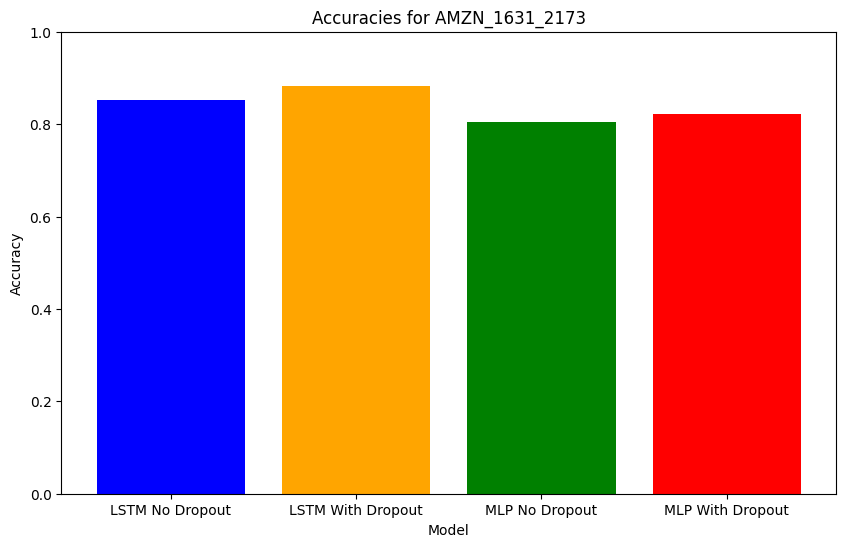


Results for AMZN_2173_2715:
Accuracy LSTM without Dropout: 0.8649
Accuracy LSTM with Dropout: 0.9006
Accuracy MLP without Dropout: 0.7325
Accuracy MLP with Dropout: 0.8413


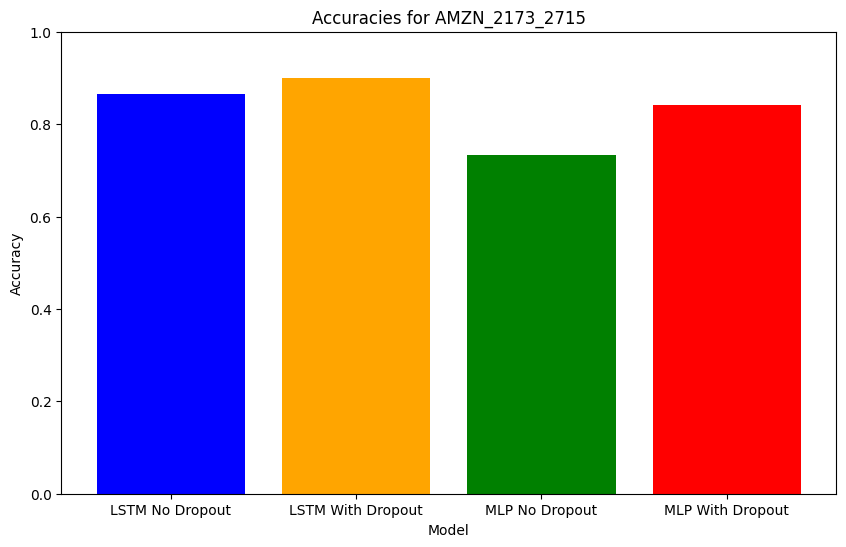


Results for AMZN_2715_3257:
Accuracy LSTM without Dropout: 0.8780
Accuracy LSTM with Dropout: 0.9043
Accuracy MLP without Dropout: 0.8210
Accuracy MLP with Dropout: 0.8192


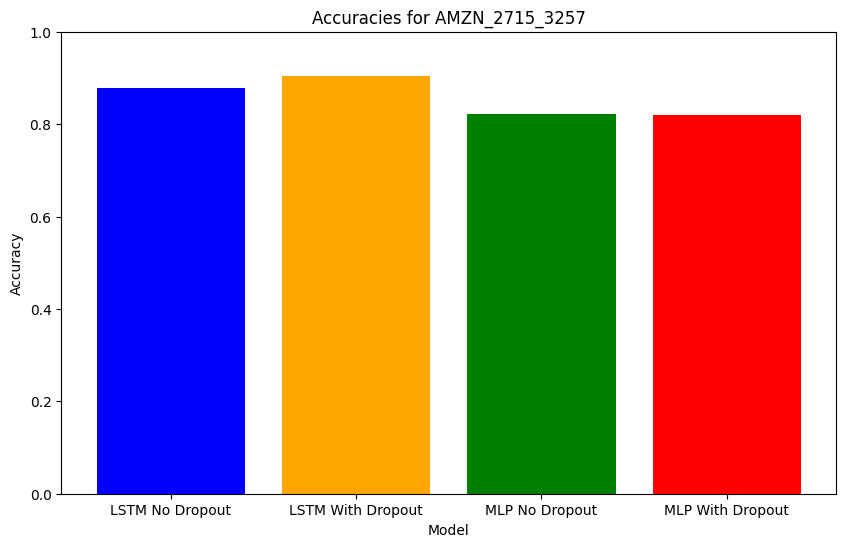


Results for MSFT_547_1089:
Accuracy LSTM without Dropout: 0.8949
Accuracy LSTM with Dropout: 0.9156
Accuracy MLP without Dropout: 0.7989
Accuracy MLP with Dropout: 0.7712


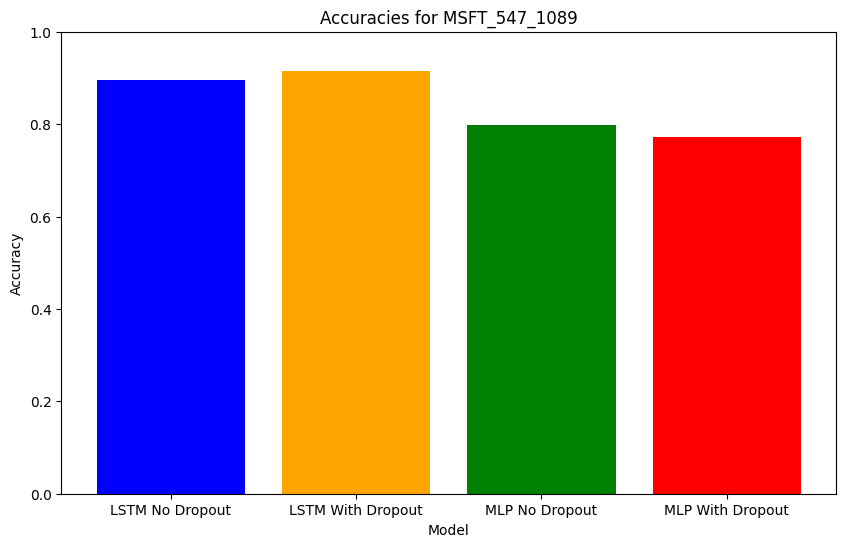


Results for MSFT_1089_1631:
Accuracy LSTM without Dropout: 0.8687
Accuracy LSTM with Dropout: 0.8931
Accuracy MLP without Dropout: 0.8007
Accuracy MLP with Dropout: 0.7897


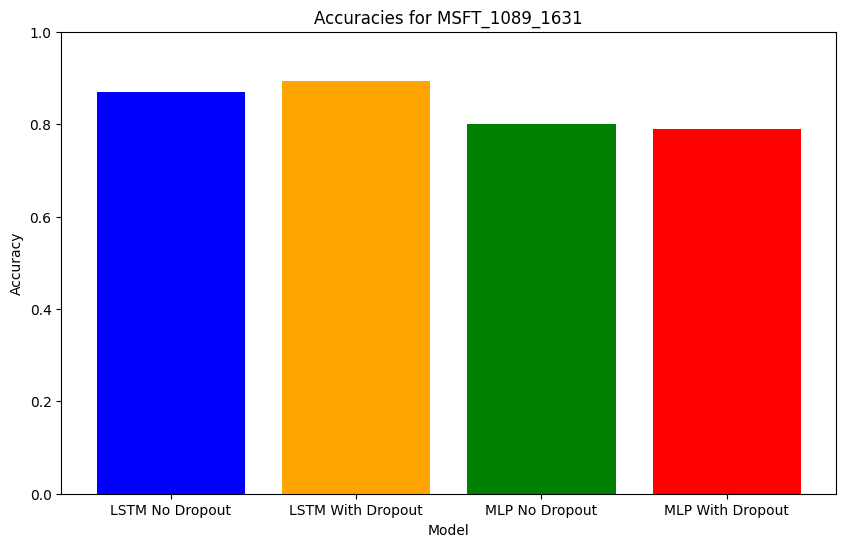


Results for MSFT_1631_2173:
Accuracy LSTM without Dropout: 0.8912
Accuracy LSTM with Dropout: 0.9081
Accuracy MLP without Dropout: 0.8118
Accuracy MLP with Dropout: 0.8063


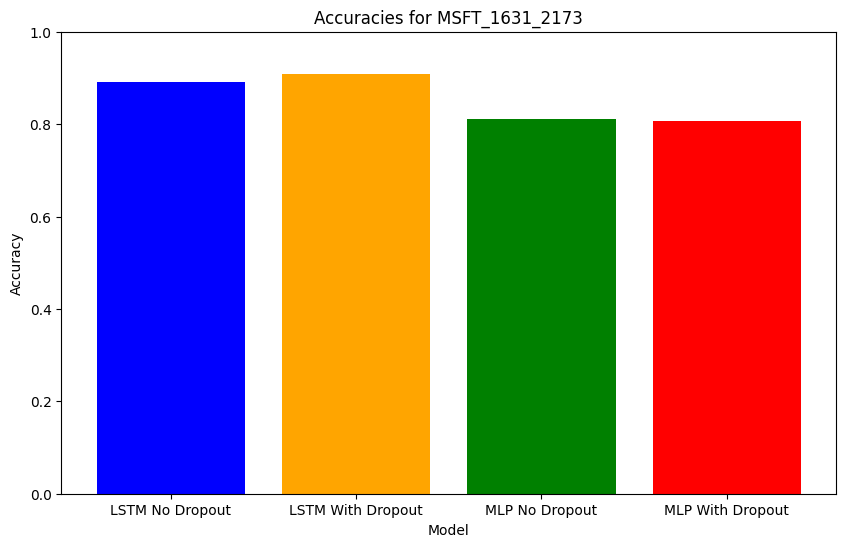


Results for MSFT_2173_2715:
Accuracy LSTM without Dropout: 0.7411
Accuracy LSTM with Dropout: 0.7317
Accuracy MLP without Dropout: 0.7546
Accuracy MLP with Dropout: 0.7269


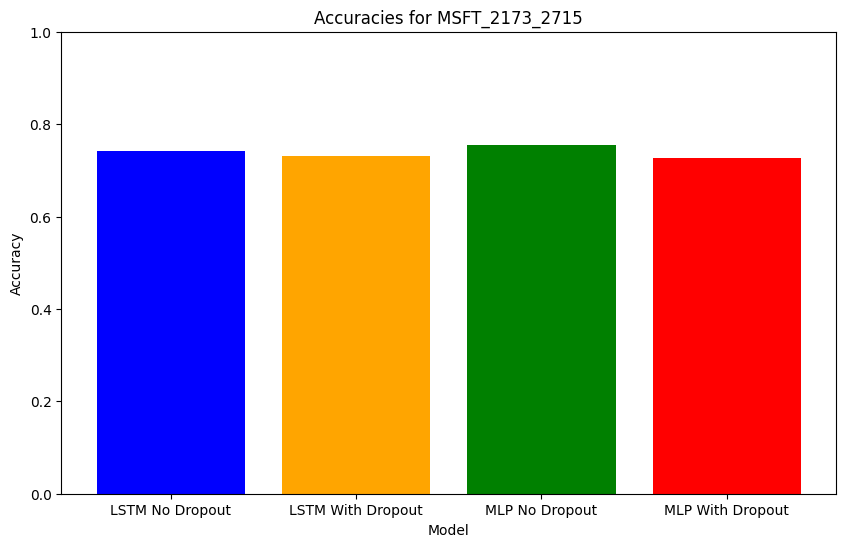


Results for MSFT_2715_3257:
Accuracy LSTM without Dropout: 0.9118
Accuracy LSTM with Dropout: 0.8931
Accuracy MLP without Dropout: 0.8063
Accuracy MLP with Dropout: 0.8192


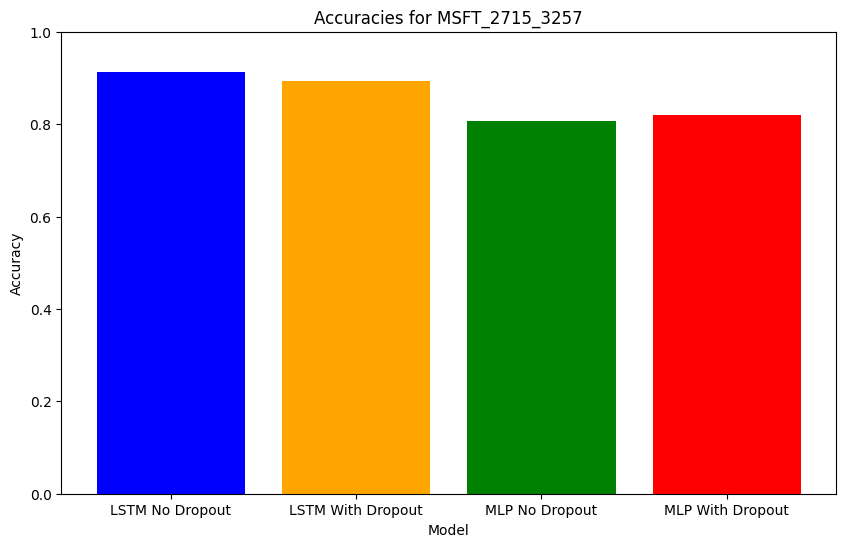


Results for GOOGL_547_1089:
Accuracy LSTM without Dropout: 0.8593
Accuracy LSTM with Dropout: 0.8968
Accuracy MLP without Dropout: 0.6882
Accuracy MLP with Dropout: 0.7232


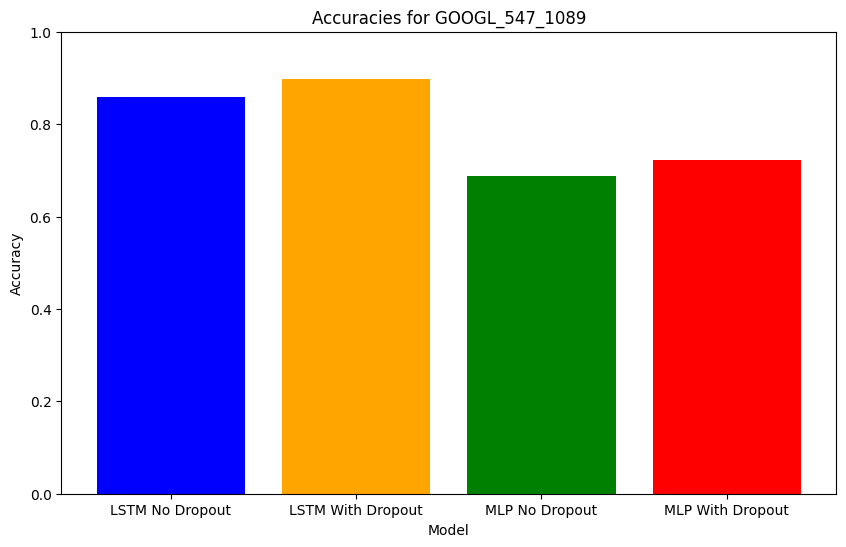


Results for GOOGL_1089_1631:
Accuracy LSTM without Dropout: 0.9099
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.7749
Accuracy MLP with Dropout: 0.7546


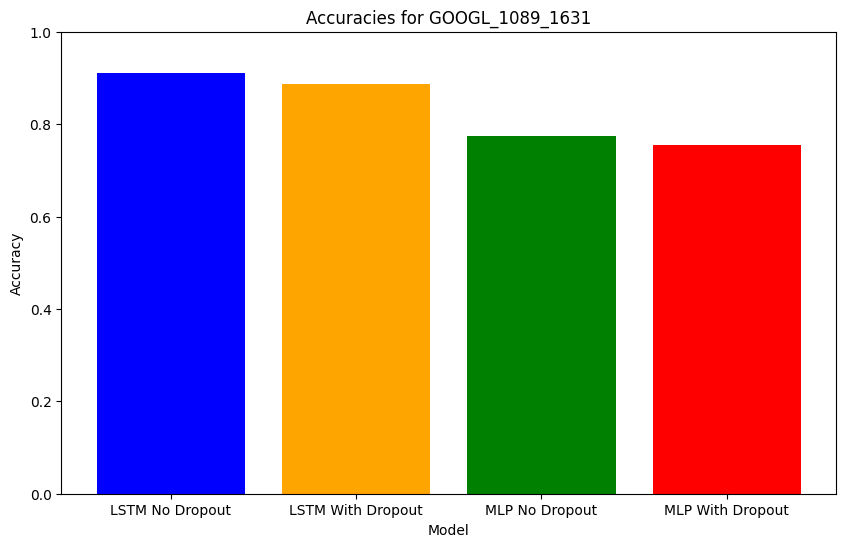


Results for GOOGL_1631_2173:
Accuracy LSTM without Dropout: 0.8818
Accuracy LSTM with Dropout: 0.9118
Accuracy MLP without Dropout: 0.8137
Accuracy MLP with Dropout: 0.8173


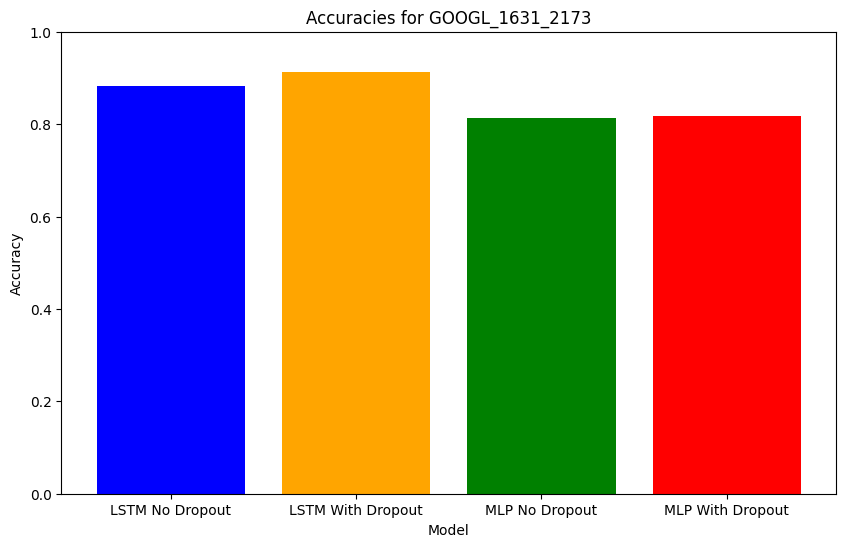


Results for GOOGL_2173_2715:
Accuracy LSTM without Dropout: 0.8386
Accuracy LSTM with Dropout: 0.9024
Accuracy MLP without Dropout: 0.8063
Accuracy MLP with Dropout: 0.8173


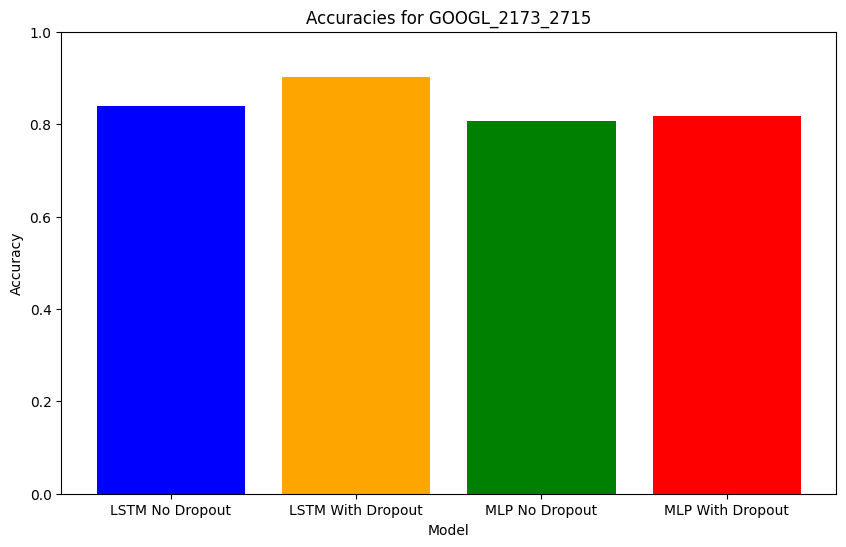


Results for GOOGL_2715_3257:
Accuracy LSTM without Dropout: 0.8218
Accuracy LSTM with Dropout: 0.8949
Accuracy MLP without Dropout: 0.7786
Accuracy MLP with Dropout: 0.8339


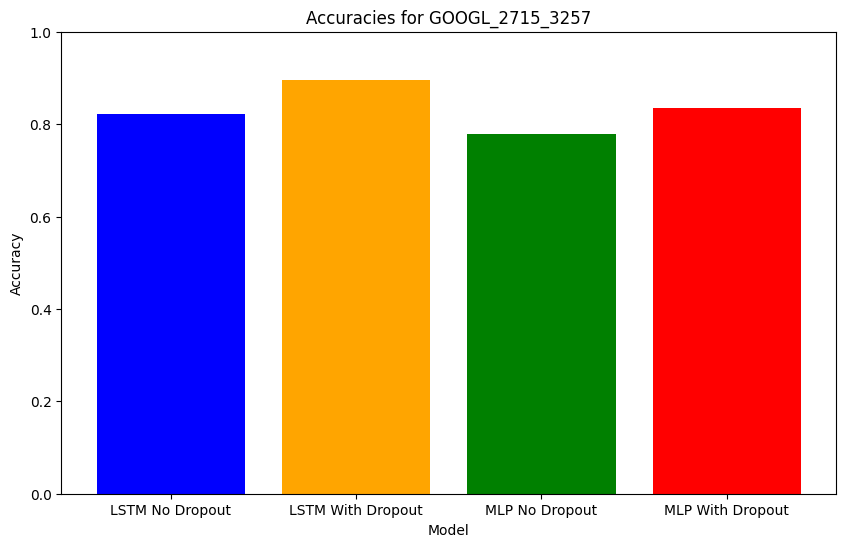

In [ ]:
import numpy as np

# Visualization
for key, value in results.items():
    print(f'\nResults for {key}:')
    print(f'Accuracy LSTM without Dropout: {value["accuracy_lstm_no_dropout"]:.4f}')
    print(f'Accuracy LSTM with Dropout: {value["accuracy_lstm_dropout"]:.4f}')
    print(f'Accuracy MLP without Dropout: {value["accuracy_mlp_no_dropout"]:.4f}')
    print(f'Accuracy MLP with Dropout: {value["accuracy_mlp_dropout"]:.4f}')

    # Plot accuracies with a bar chart
    models = ['LSTM No Dropout', 'LSTM With Dropout', 'MLP No Dropout', 'MLP With Dropout']
    accuracies = [value['accuracy_lstm_no_dropout'], value['accuracy_lstm_dropout'], value['accuracy_mlp_no_dropout'], value['accuracy_mlp_dropout']]

    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'])
    plt.title(f'Accuracies for {key}')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
    plt.show()



Results for AAPL_547_1089:
Accuracy LSTM without Dropout: 0.8799
Accuracy LSTM with Dropout: 0.8724
Accuracy MLP without Dropout: 0.7823
Accuracy MLP with Dropout: 0.6605


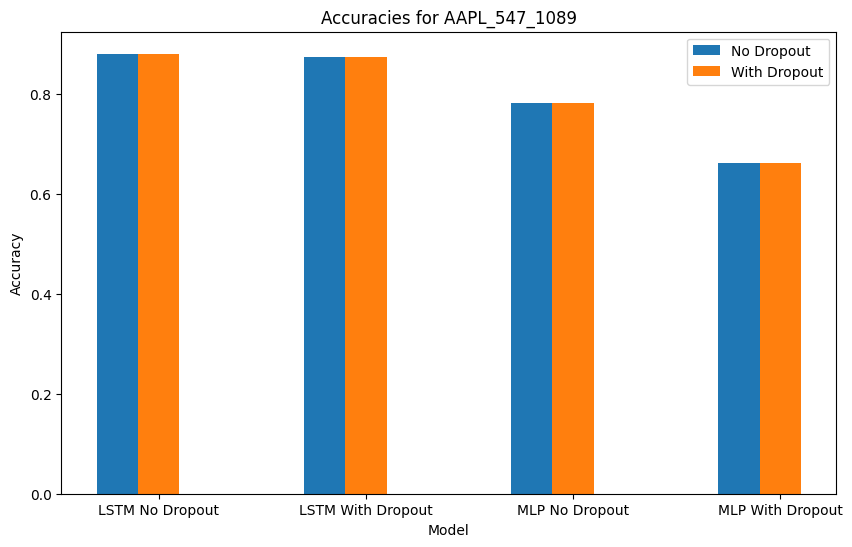


Results for AAPL_1089_1631:
Accuracy LSTM without Dropout: 0.9006
Accuracy LSTM with Dropout: 0.9156
Accuracy MLP without Dropout: 0.8100
Accuracy MLP with Dropout: 0.8063


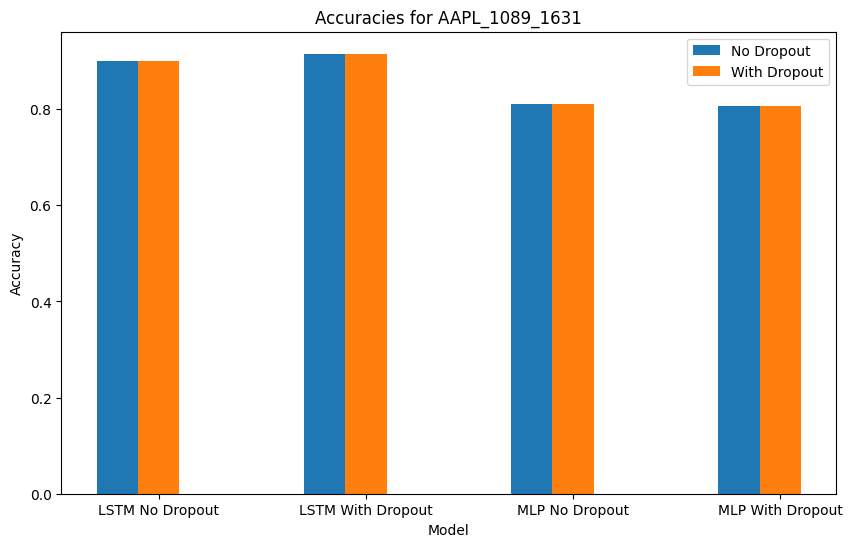


Results for AAPL_1631_2173:
Accuracy LSTM without Dropout: 0.9193
Accuracy LSTM with Dropout: 0.9512
Accuracy MLP without Dropout: 0.7897
Accuracy MLP with Dropout: 0.7749


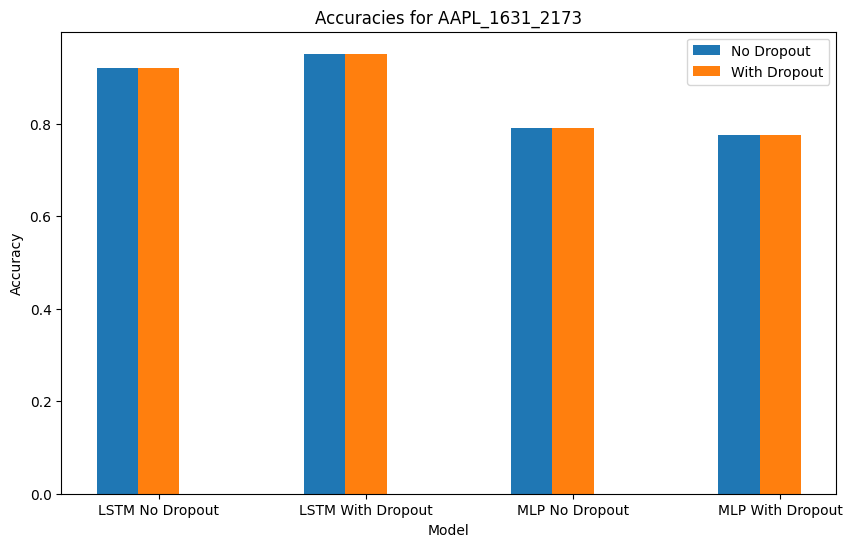


Results for AAPL_2173_2715:
Accuracy LSTM without Dropout: 0.8480
Accuracy LSTM with Dropout: 0.8574
Accuracy MLP without Dropout: 0.7897
Accuracy MLP with Dropout: 0.7970


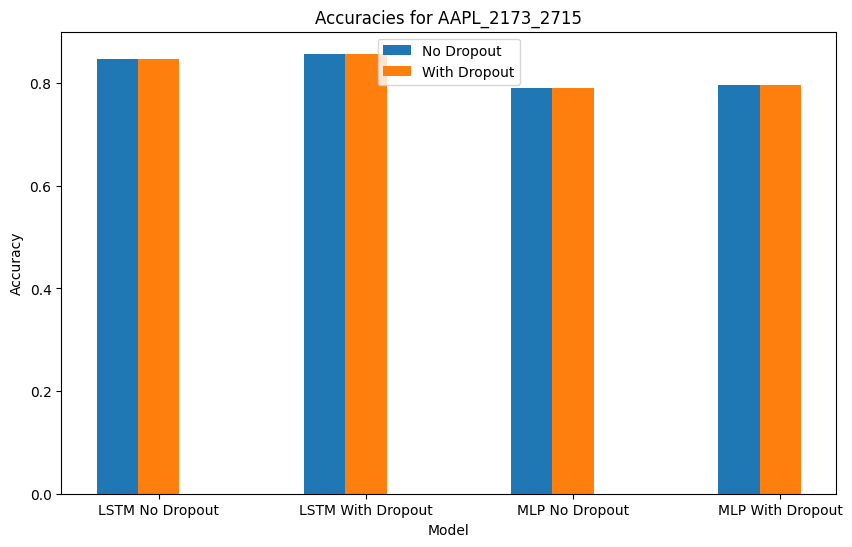


Results for AAPL_2715_3257:
Accuracy LSTM without Dropout: 0.9212
Accuracy LSTM with Dropout: 0.9099
Accuracy MLP without Dropout: 0.7694
Accuracy MLP with Dropout: 0.8155


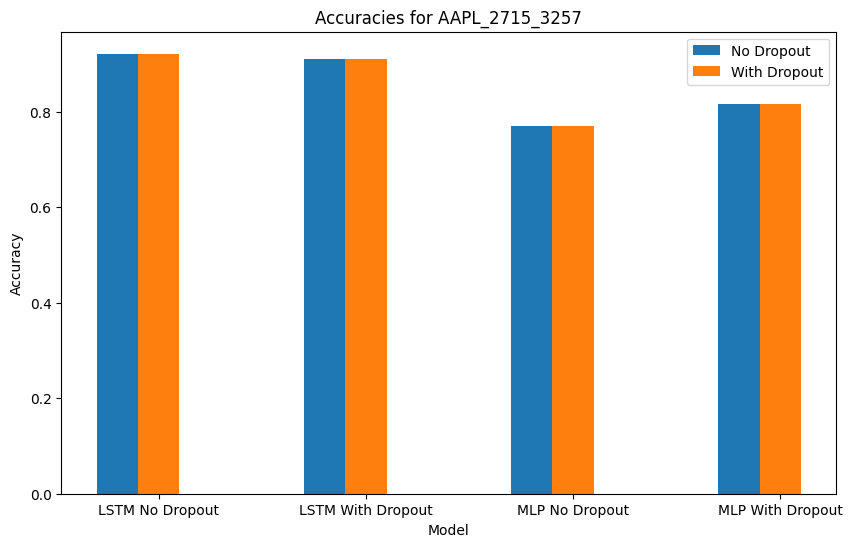


Results for META_443_886:
Accuracy LSTM without Dropout: 0.8871
Accuracy LSTM with Dropout: 0.8940
Accuracy MLP without Dropout: 0.7178
Accuracy MLP with Dropout: 0.7065


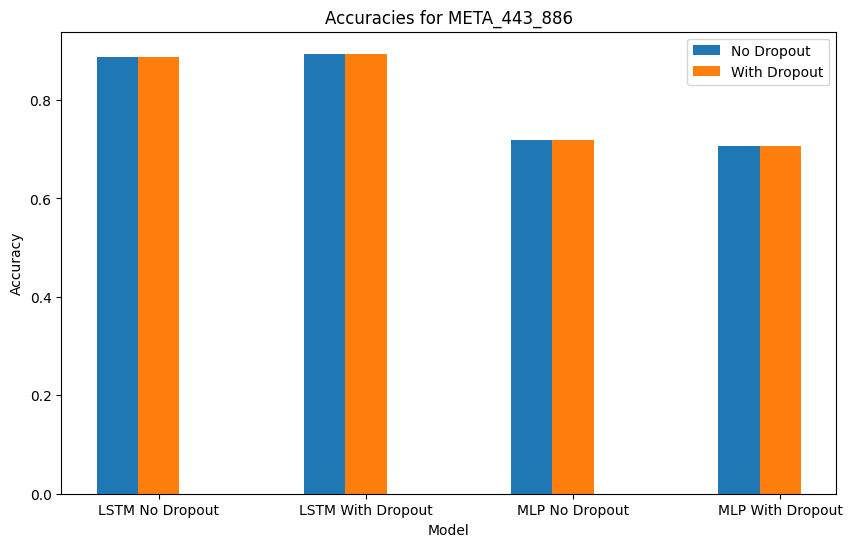


Results for META_886_1329:
Accuracy LSTM without Dropout: 0.8917
Accuracy LSTM with Dropout: 0.9032
Accuracy MLP without Dropout: 0.7404
Accuracy MLP with Dropout: 0.7540


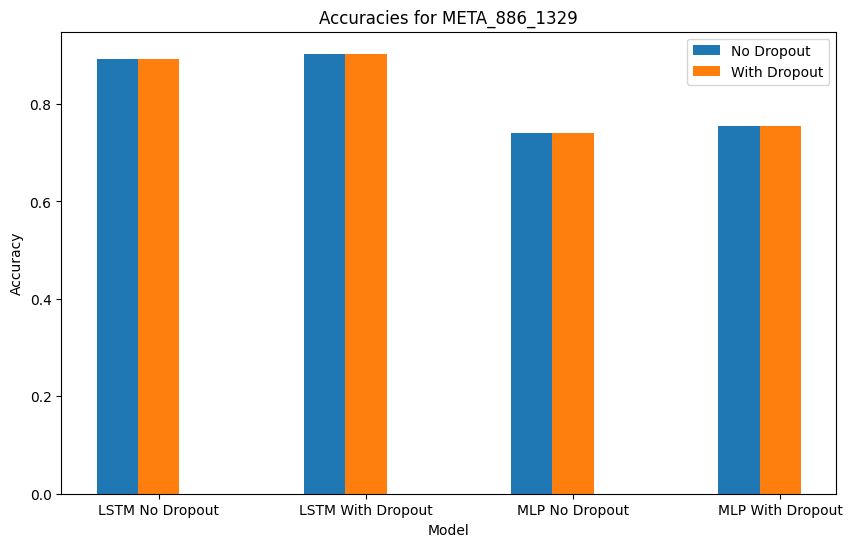


Results for META_1329_1772:
Accuracy LSTM without Dropout: 0.7696
Accuracy LSTM with Dropout: 0.8917
Accuracy MLP without Dropout: 0.8126
Accuracy MLP with Dropout: 0.7720


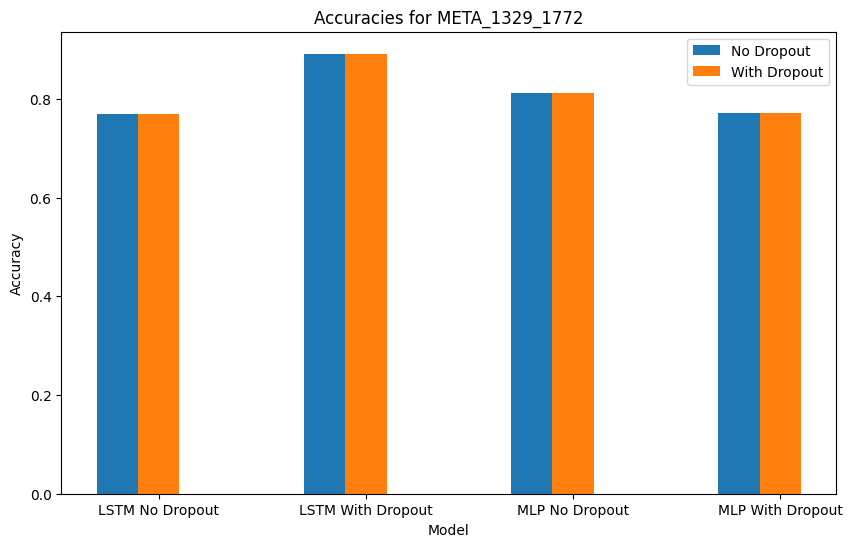


Results for META_1772_2215:
Accuracy LSTM without Dropout: 0.8341
Accuracy LSTM with Dropout: 0.7097
Accuracy MLP without Dropout: 0.8284
Accuracy MLP with Dropout: 0.8420


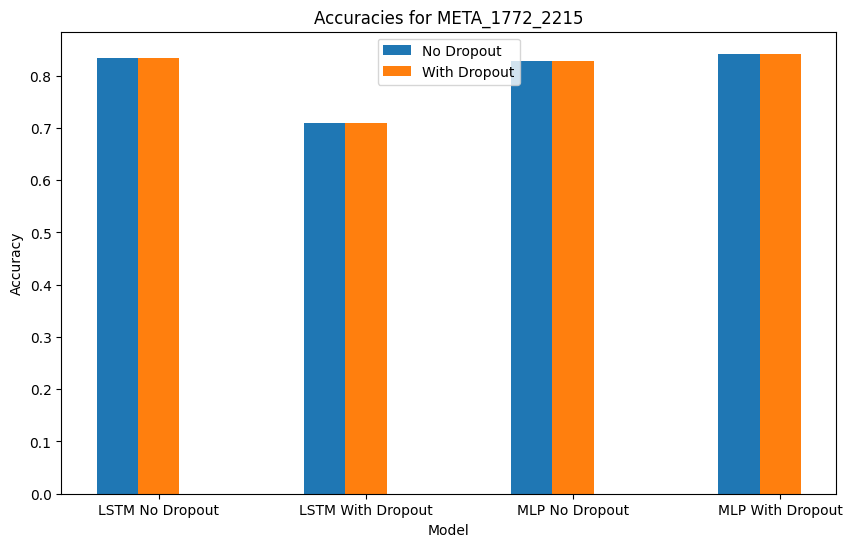


Results for META_2215_2658:
Accuracy LSTM without Dropout: 0.8894
Accuracy LSTM with Dropout: 0.9147
Accuracy MLP without Dropout: 0.8578
Accuracy MLP with Dropout: 0.8397


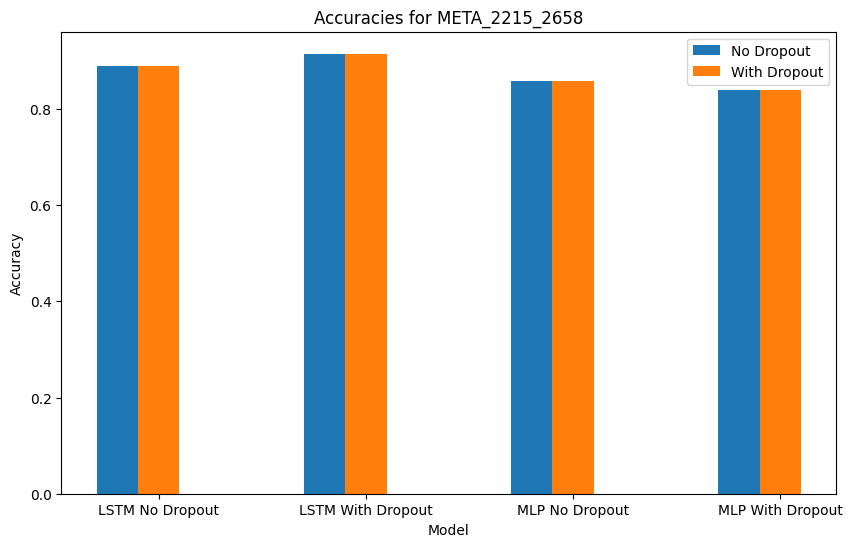


Results for AMZN_547_1089:
Accuracy LSTM without Dropout: 0.8874
Accuracy LSTM with Dropout: 0.8949
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.7454


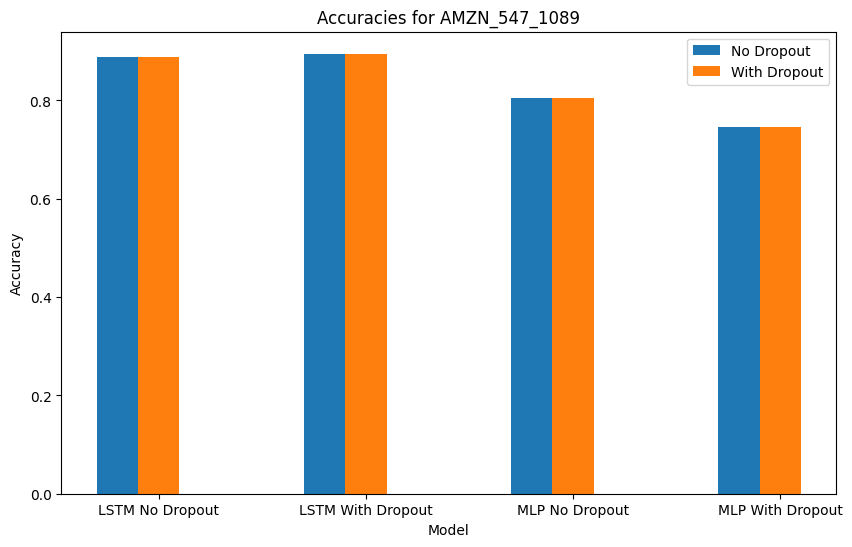


Results for AMZN_1089_1631:
Accuracy LSTM without Dropout: 0.9137
Accuracy LSTM with Dropout: 0.9231
Accuracy MLP without Dropout: 0.7768
Accuracy MLP with Dropout: 0.7768


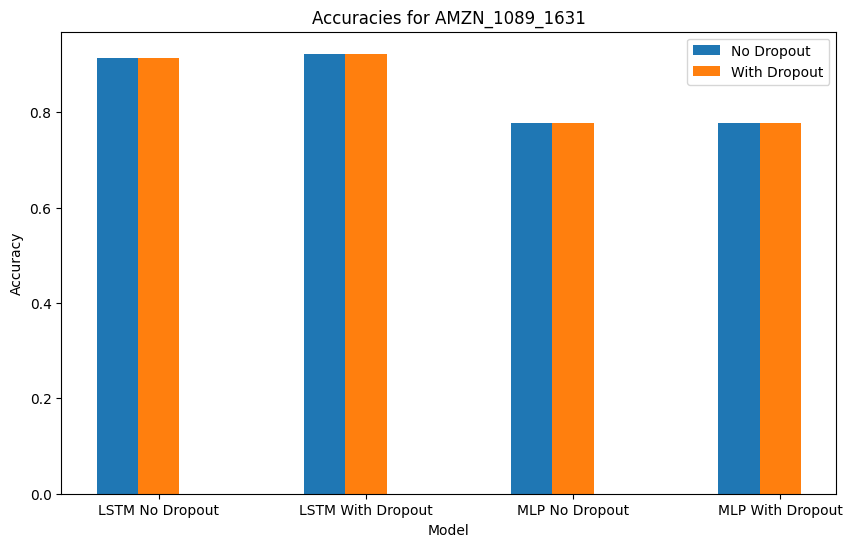


Results for AMZN_1631_2173:
Accuracy LSTM without Dropout: 0.8518
Accuracy LSTM with Dropout: 0.8818
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.8210


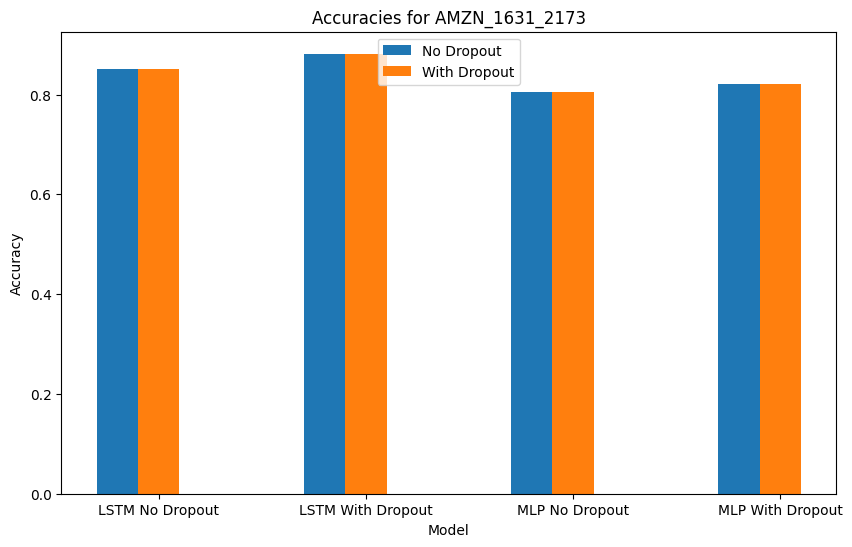


Results for AMZN_2173_2715:
Accuracy LSTM without Dropout: 0.8649
Accuracy LSTM with Dropout: 0.9006
Accuracy MLP without Dropout: 0.7325
Accuracy MLP with Dropout: 0.8413


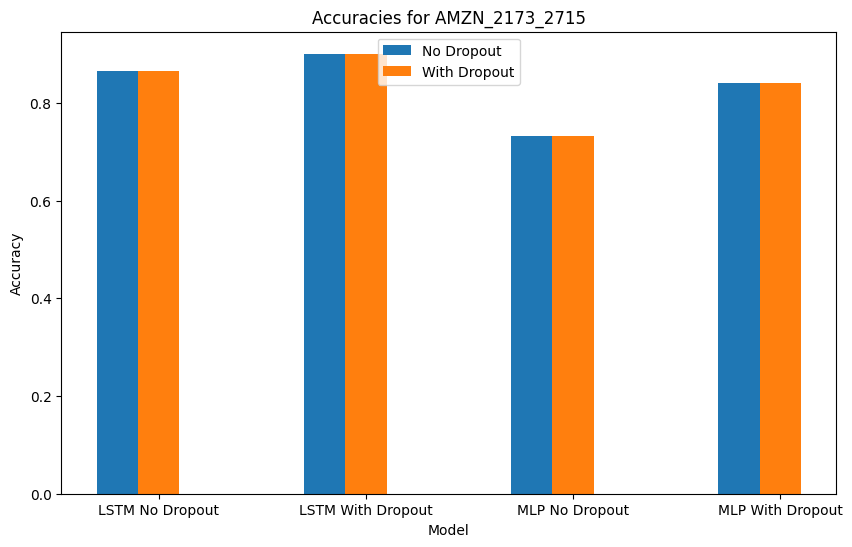


Results for AMZN_2715_3257:
Accuracy LSTM without Dropout: 0.8780
Accuracy LSTM with Dropout: 0.9043
Accuracy MLP without Dropout: 0.8210
Accuracy MLP with Dropout: 0.8192


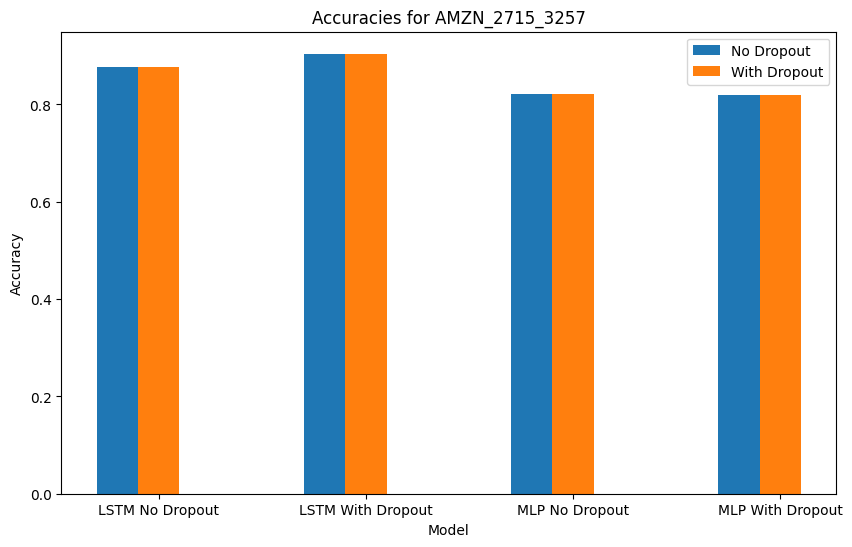


Results for MSFT_547_1089:
Accuracy LSTM without Dropout: 0.8949
Accuracy LSTM with Dropout: 0.9156
Accuracy MLP without Dropout: 0.7989
Accuracy MLP with Dropout: 0.7712


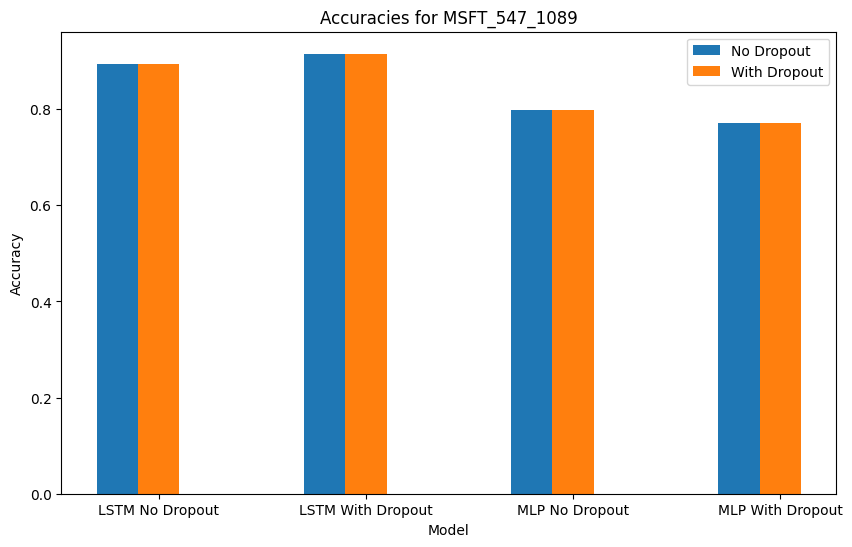


Results for MSFT_1089_1631:
Accuracy LSTM without Dropout: 0.8687
Accuracy LSTM with Dropout: 0.8931
Accuracy MLP without Dropout: 0.8007
Accuracy MLP with Dropout: 0.7897


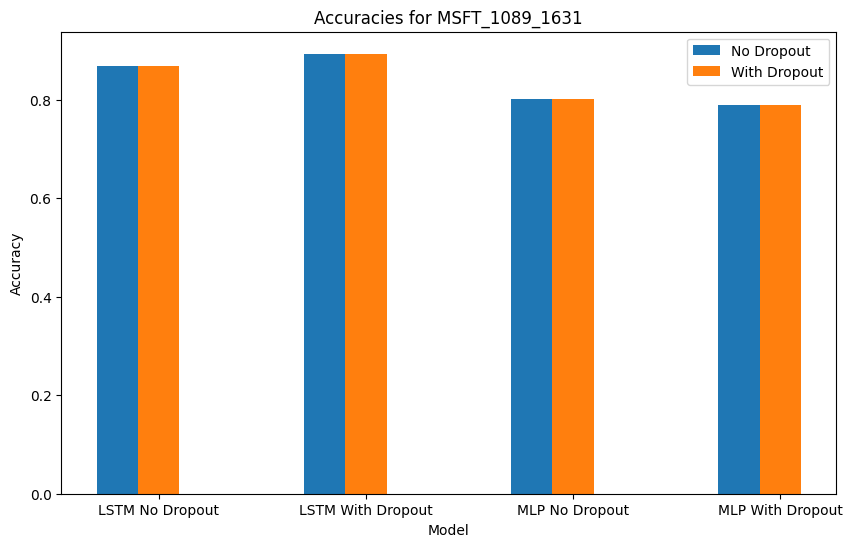


Results for MSFT_1631_2173:
Accuracy LSTM without Dropout: 0.8912
Accuracy LSTM with Dropout: 0.9081
Accuracy MLP without Dropout: 0.8118
Accuracy MLP with Dropout: 0.8063


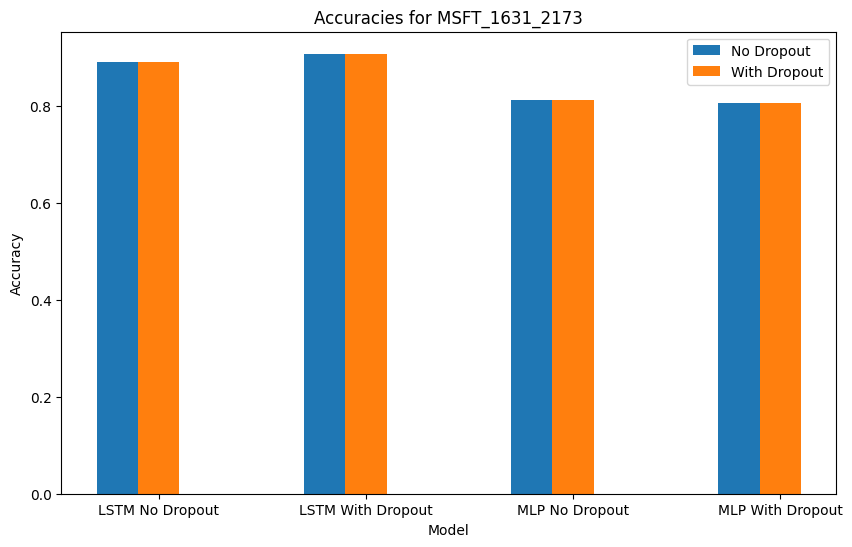


Results for MSFT_2173_2715:
Accuracy LSTM without Dropout: 0.7411
Accuracy LSTM with Dropout: 0.7317
Accuracy MLP without Dropout: 0.7546
Accuracy MLP with Dropout: 0.7269


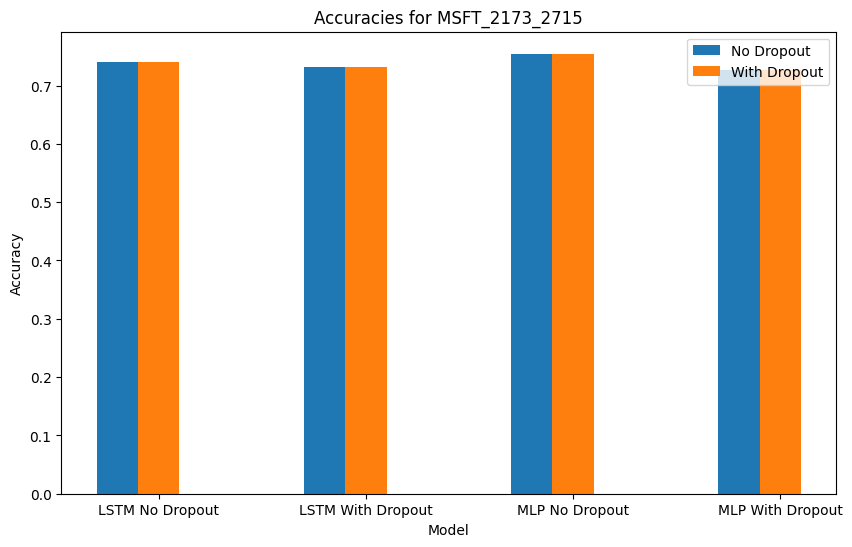


Results for MSFT_2715_3257:
Accuracy LSTM without Dropout: 0.9118
Accuracy LSTM with Dropout: 0.8931
Accuracy MLP without Dropout: 0.8063
Accuracy MLP with Dropout: 0.8192


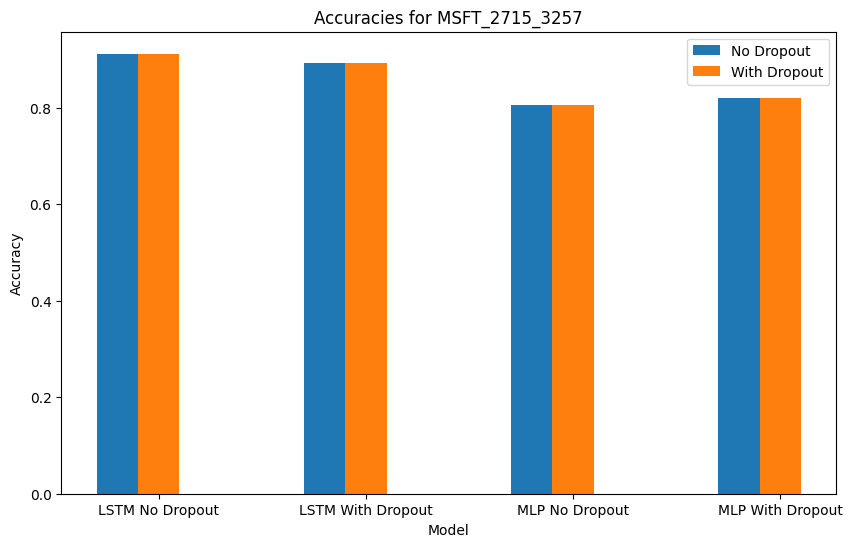


Results for GOOGL_547_1089:
Accuracy LSTM without Dropout: 0.8593
Accuracy LSTM with Dropout: 0.8968
Accuracy MLP without Dropout: 0.6882
Accuracy MLP with Dropout: 0.7232


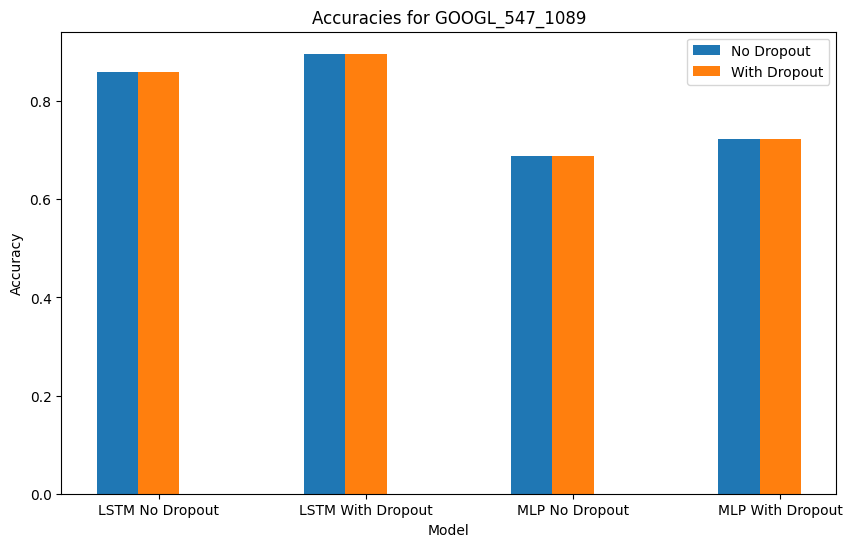


Results for GOOGL_1089_1631:
Accuracy LSTM without Dropout: 0.9099
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.7749
Accuracy MLP with Dropout: 0.7546


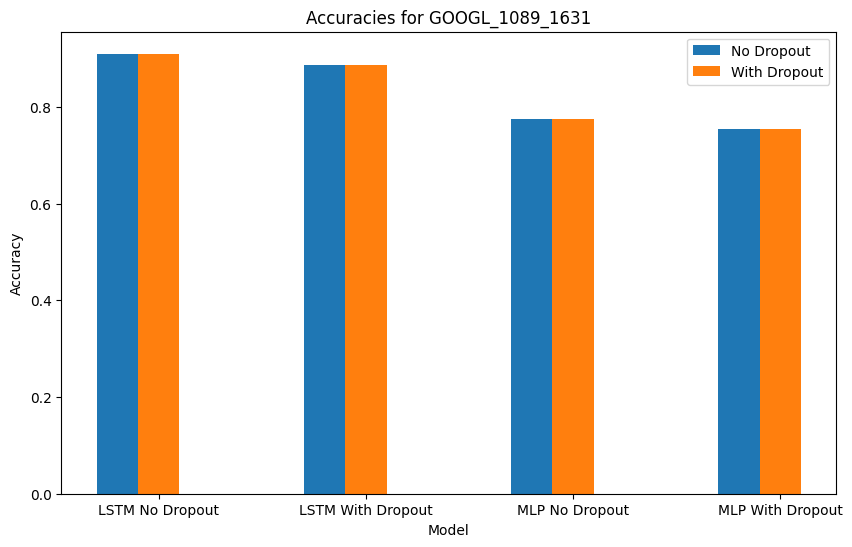


Results for GOOGL_1631_2173:
Accuracy LSTM without Dropout: 0.8818
Accuracy LSTM with Dropout: 0.9118
Accuracy MLP without Dropout: 0.8137
Accuracy MLP with Dropout: 0.8173


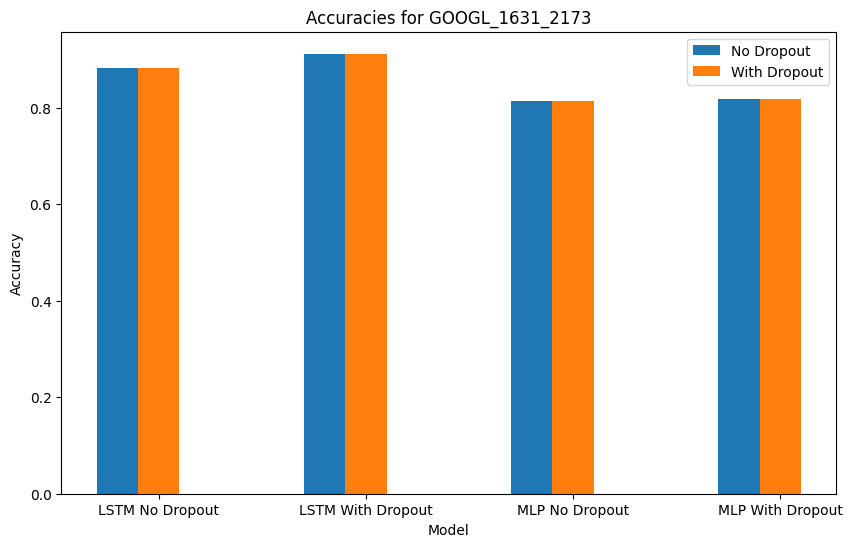


Results for GOOGL_2173_2715:
Accuracy LSTM without Dropout: 0.8386
Accuracy LSTM with Dropout: 0.9024
Accuracy MLP without Dropout: 0.8063
Accuracy MLP with Dropout: 0.8173


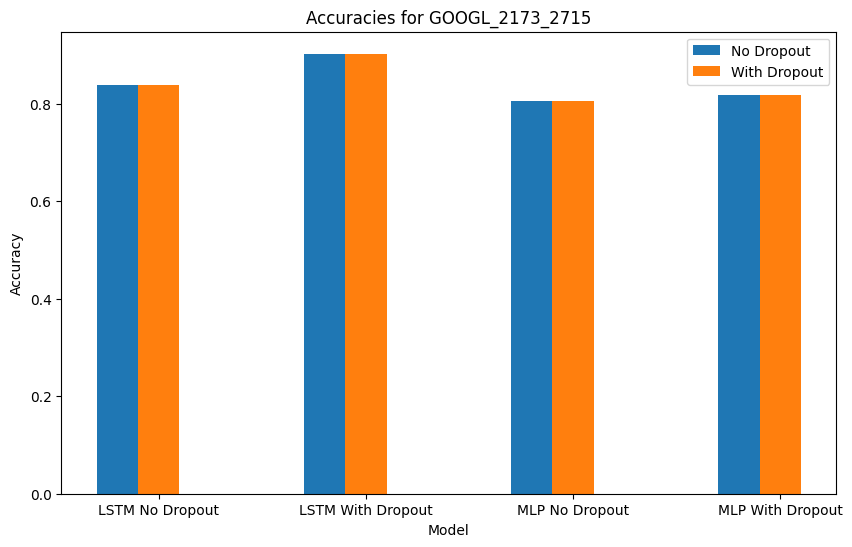


Results for GOOGL_2715_3257:
Accuracy LSTM without Dropout: 0.8218
Accuracy LSTM with Dropout: 0.8949
Accuracy MLP without Dropout: 0.7786
Accuracy MLP with Dropout: 0.8339


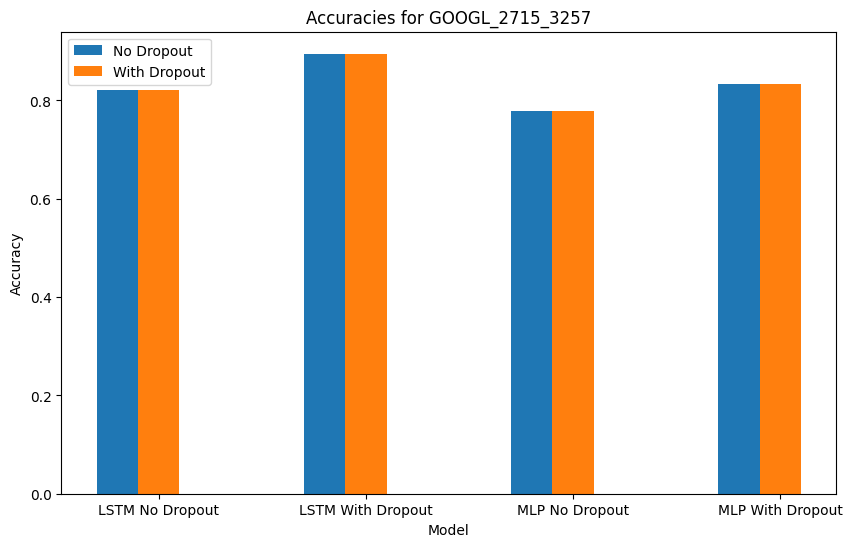

In [ ]:
import numpy as np

# Visualization
for key, value in results.items():
    print(f'\nResults for {key}:')
    print(f'Accuracy LSTM without Dropout: {value["accuracy_lstm_no_dropout"]:.4f}')
    print(f'Accuracy LSTM with Dropout: {value["accuracy_lstm_dropout"]:.4f}')
    print(f'Accuracy MLP without Dropout: {value["accuracy_mlp_no_dropout"]:.4f}')
    print(f'Accuracy MLP with Dropout: {value["accuracy_mlp_dropout"]:.4f}')

    # Plot accuracies with a grouped bar chart
    models = ['LSTM No Dropout', 'LSTM With Dropout', 'MLP No Dropout', 'MLP With Dropout']
    accuracies = [value['accuracy_lstm_no_dropout'], value['accuracy_lstm_dropout'], value['accuracy_mlp_no_dropout'], value['accuracy_mlp_dropout']]

    bar_width = 0.2
    index = np.arange(len(models))

    plt.figure(figsize=(10, 6))

    plt.bar(index - bar_width, accuracies, bar_width, label='No Dropout')
    plt.bar(index, accuracies, bar_width, label='With Dropout')

    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracies for {key}')
    plt.xticks(index, models)
    plt.legend()
    plt.show()


**1.3 Model_B (Walk-forward approach with purging and embargoing)**

In [ ]:
# Walk-forward approach with purging and embargoing
for train_indices, test_indices in tscv.split(features_scaled):
    train_start = int(train_indices[0])
    train_end = int(test_indices[0]) - 1
    test_start = int(test_indices[0])
    test_end = int(test_indices[-1])

    # Create sequences for LSTM
    sequence_length = 10  # Adjust as needed
    X_train_lstm, y_train_lstm = create_sequences(features_scaled[train_start:train_end + 1], target.iloc[train_start:train_end + 1], sequence_length)
    X_test_lstm, y_test_lstm = create_sequences(features_scaled[test_start:test_end + 1], target.iloc[test_start:test_end + 1], sequence_length)

    # Train LSTM model without dropout and early stopping
    model_lstm_no_dropout = train_model(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, build_lstm_model)

    # Train LSTM model with dropout and early stopping
    model_lstm_dropout = train_model_with_dropout_and_early_stopping(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, build_lstm_model_with_dropout_and_early_stopping)

    # Train MLP model without dropout and early stopping
    model_mlp_no_dropout = train_model(X_train, y_train, X_test, y_test, build_mlp_model)

    # Train MLP model with dropout and early stopping
    model_mlp_dropout = train_model_with_dropout_and_early_stopping(X_train, y_train, X_test, y_test, build_mlp_model_with_dropout_and_early_stopping)

    # Store results
    key = f'{symbol}_{train_start + 1}_{test_start + 1}'
    results[key] = {
        'accuracy_lstm_no_dropout': accuracy_score(y_test_lstm, (model_lstm_no_dropout.predict(X_test_lstm) > 0.5).astype(int)),
        'accuracy_lstm_dropout': accuracy_score(y_test_lstm, (model_lstm_dropout.predict(X_test_lstm) > 0.5).astype(int)),
        'accuracy_mlp_no_dropout': accuracy_score(y_test, (model_mlp_no_dropout.predict(X_test) > 0.5).astype(int)),
        'accuracy_mlp_dropout': accuracy_score(y_test, (model_mlp_dropout.predict(X_test) > 0.5).astype(int))
    }
# Print results
for key, value in results.items():
    print(f"\nResults for {key}:")
    print(f"Accuracy LSTM No Dropout: {value['accuracy_lstm_no_dropout']:.4f}")
    print(f"Accuracy LSTM With Dropout: {value['accuracy_lstm_dropout']:.4f}")
    print(f"Accuracy MLP No Dropout: {value['accuracy_mlp_no_dropout']:.4f}")
    print(f"Accuracy MLP With Dropout: {value['accuracy_mlp_dropout']:.4f}")



17/17 [==============================] - 0s 3ms/step

Results for AAPL_547_1089:
Accuracy LSTM No Dropout: 0.8780
Accuracy LSTM With Dropout: 0.8874
Accuracy MLP No Dropout: 0.7583
Accuracy MLP With Dropout: 0.7583

Results for AAPL_1089_1631:
Accuracy LSTM No Dropout: 0.9174
Accuracy LSTM With Dropout: 0.9081
Accuracy MLP No Dropout: 0.8007
Accuracy MLP With Dropout: 0.7952

Results for AAPL_1631_2173:
Accuracy LSTM No Dropout: 0.9212
Accuracy LSTM With Dropout: 0.9362
Accuracy MLP No Dropout: 0.7915
Accuracy MLP With Dropout: 0.7786

Results for AAPL_2173_2715:
Accuracy LSTM No Dropout: 0.8368
Accuracy LSTM With Dropout: 0.8443
Accuracy MLP No Dropout: 0.8063
Accuracy MLP With Dropout: 0.7731

Results for AAPL_2715_3257:
Accuracy LSTM No Dropout: 0.8912
Accuracy LSTM With Dropout: 0.9081
Accuracy MLP No Dropout: 0.8044
Accuracy MLP With Dropout: 0.8229

Results for META_443_886:
Accuracy LSTM No Dropout: 0.9055
Accuracy LSTM With Dropout: 0.9078
Accuracy MLP No Dropout: 0.7359
Accura

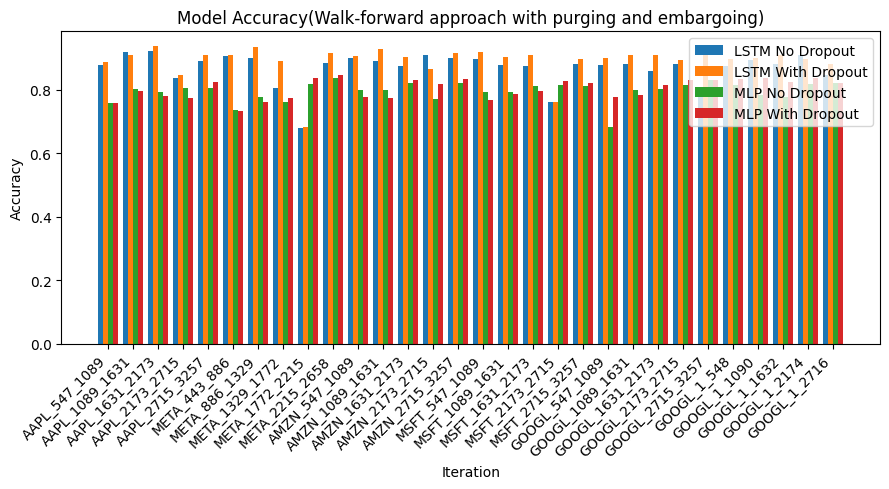

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract model names and accuracy scores from results
model_names = ['LSTM No Dropout', 'LSTM With Dropout', 'MLP No Dropout', 'MLP With Dropout']
accuracy_scores = np.array([[value[f'accuracy_lstm_no_dropout'] for value in results.values()],
                            [value[f'accuracy_lstm_dropout'] for value in results.values()],
                            [value[f'accuracy_mlp_no_dropout'] for value in results.values()],
                            [value[f'accuracy_mlp_dropout'] for value in results.values()]])

# Plotting
bar_width = 0.2
index = np.arange(len(results))

fig, ax = plt.subplots(figsize=(9, 5))

for i, model_name in enumerate(model_names):
    ax.bar(index + i * bar_width, accuracy_scores[i], bar_width, label=model_name)

ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy(Walk-forward approach with purging and embargoing)')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels([key for key in results.keys()], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


Results for AAPL_547_1089:
Accuracy LSTM without Dropout: 0.8799
Accuracy LSTM with Dropout: 0.8724
Accuracy MLP without Dropout: 0.7823
Accuracy MLP with Dropout: 0.6605


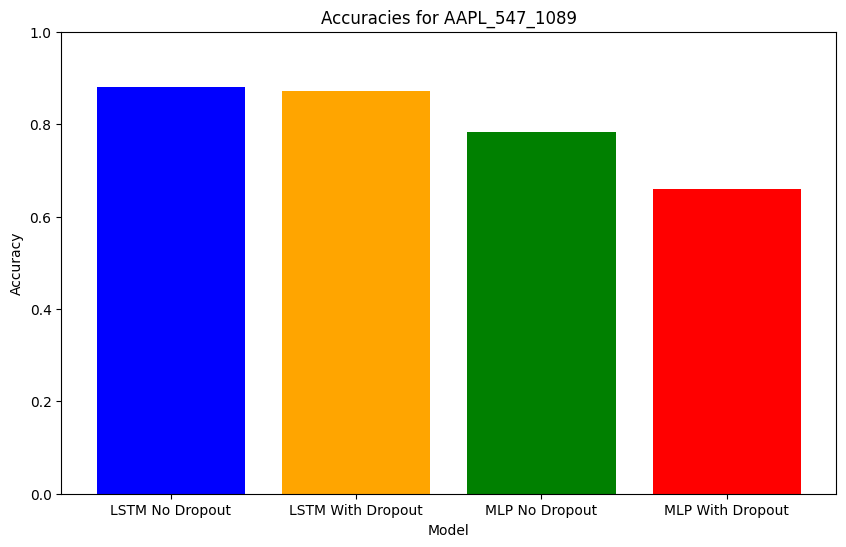


Results for AAPL_1089_1631:
Accuracy LSTM without Dropout: 0.9006
Accuracy LSTM with Dropout: 0.9156
Accuracy MLP without Dropout: 0.8100
Accuracy MLP with Dropout: 0.8063


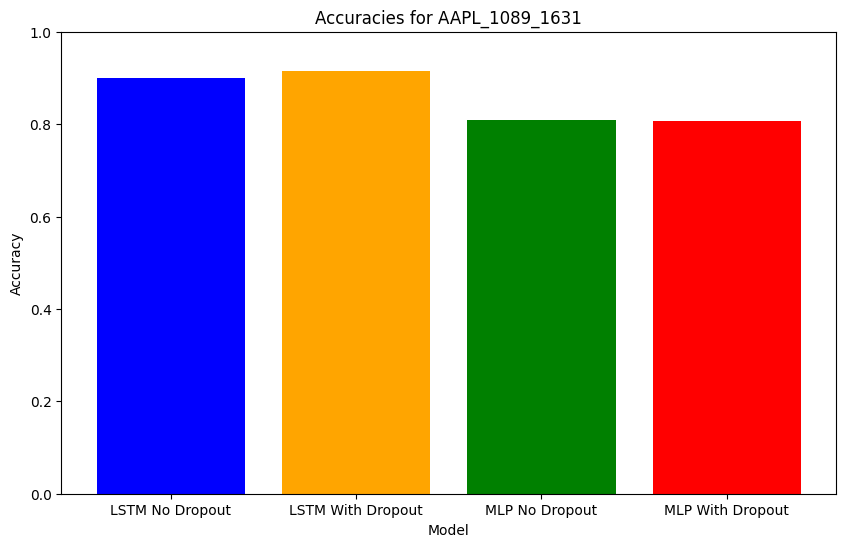


Results for AAPL_1631_2173:
Accuracy LSTM without Dropout: 0.9193
Accuracy LSTM with Dropout: 0.9512
Accuracy MLP without Dropout: 0.7897
Accuracy MLP with Dropout: 0.7749


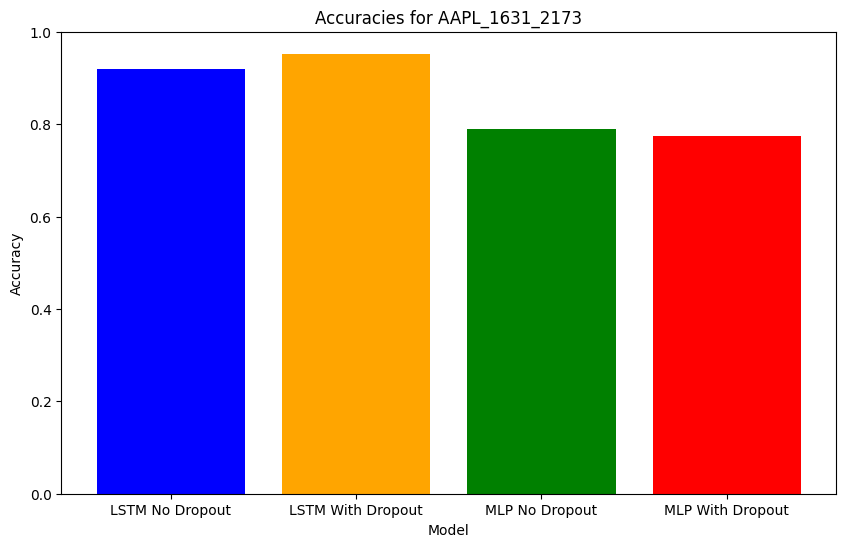


Results for AAPL_2173_2715:
Accuracy LSTM without Dropout: 0.8480
Accuracy LSTM with Dropout: 0.8574
Accuracy MLP without Dropout: 0.7897
Accuracy MLP with Dropout: 0.7970


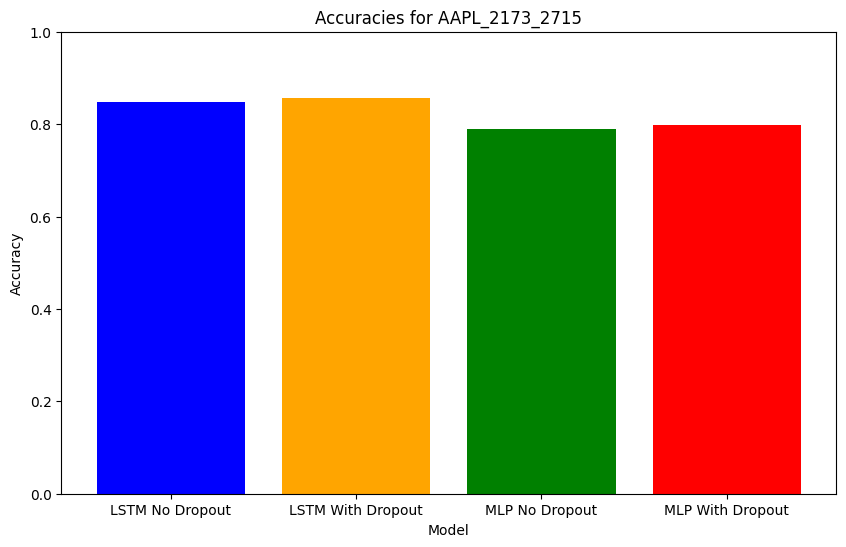


Results for AAPL_2715_3257:
Accuracy LSTM without Dropout: 0.9212
Accuracy LSTM with Dropout: 0.9099
Accuracy MLP without Dropout: 0.7694
Accuracy MLP with Dropout: 0.8155


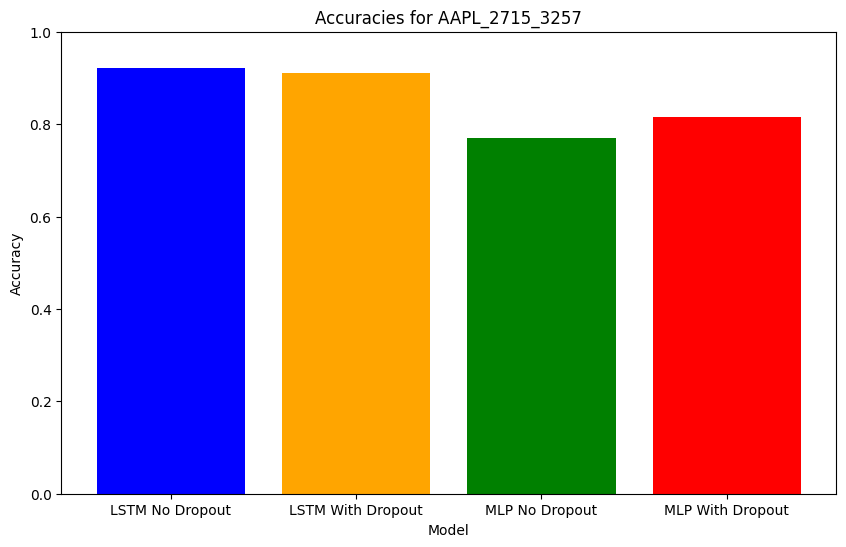


Results for META_443_886:
Accuracy LSTM without Dropout: 0.8871
Accuracy LSTM with Dropout: 0.8940
Accuracy MLP without Dropout: 0.7178
Accuracy MLP with Dropout: 0.7065


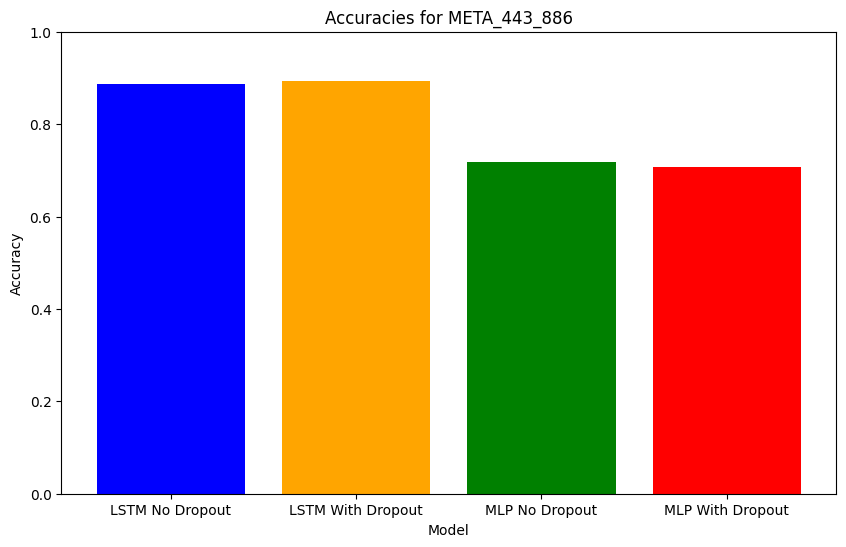


Results for META_886_1329:
Accuracy LSTM without Dropout: 0.8917
Accuracy LSTM with Dropout: 0.9032
Accuracy MLP without Dropout: 0.7404
Accuracy MLP with Dropout: 0.7540


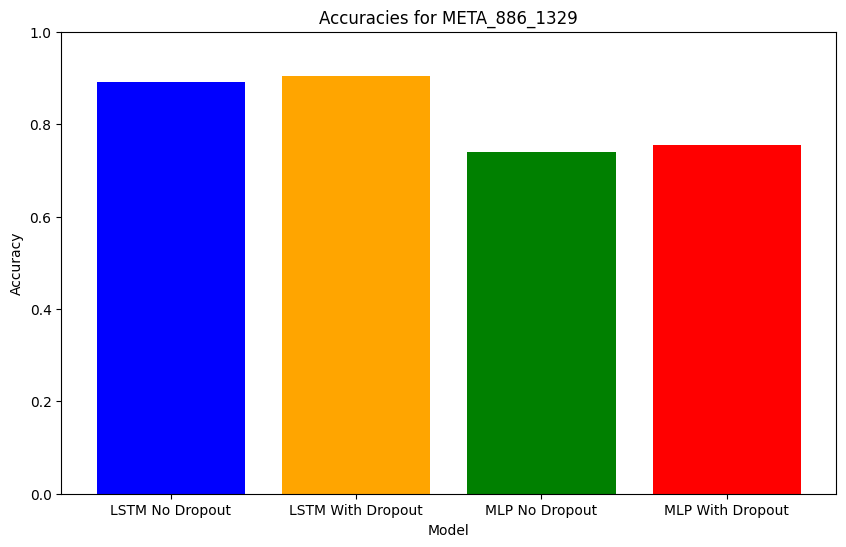


Results for META_1329_1772:
Accuracy LSTM without Dropout: 0.7696
Accuracy LSTM with Dropout: 0.8917
Accuracy MLP without Dropout: 0.8126
Accuracy MLP with Dropout: 0.7720


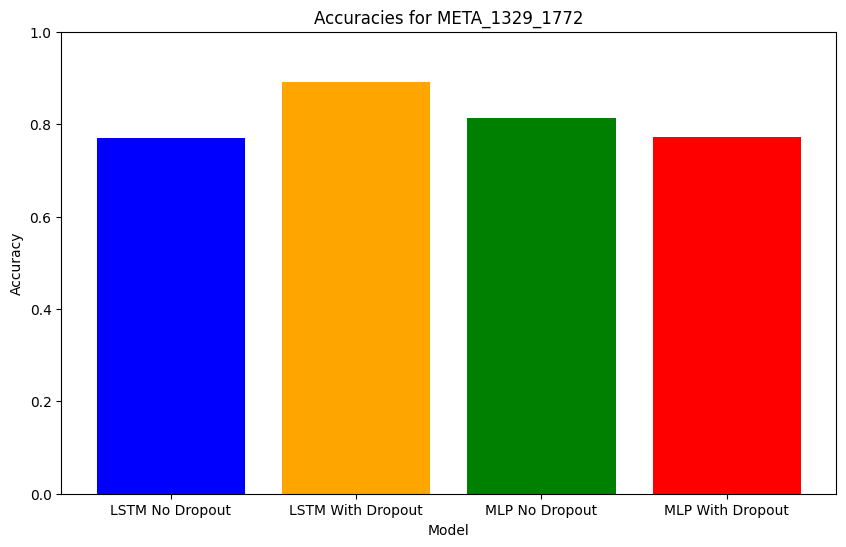


Results for META_1772_2215:
Accuracy LSTM without Dropout: 0.8341
Accuracy LSTM with Dropout: 0.7097
Accuracy MLP without Dropout: 0.8284
Accuracy MLP with Dropout: 0.8420


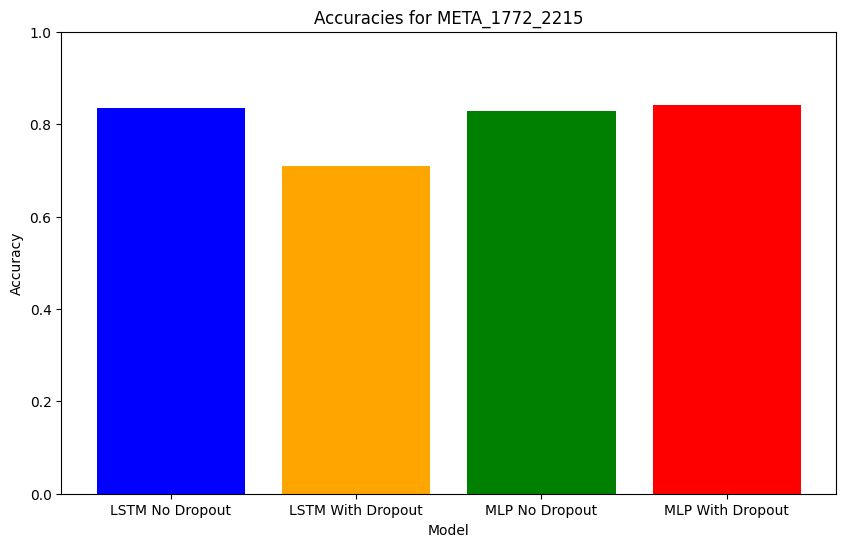


Results for META_2215_2658:
Accuracy LSTM without Dropout: 0.8894
Accuracy LSTM with Dropout: 0.9147
Accuracy MLP without Dropout: 0.8578
Accuracy MLP with Dropout: 0.8397


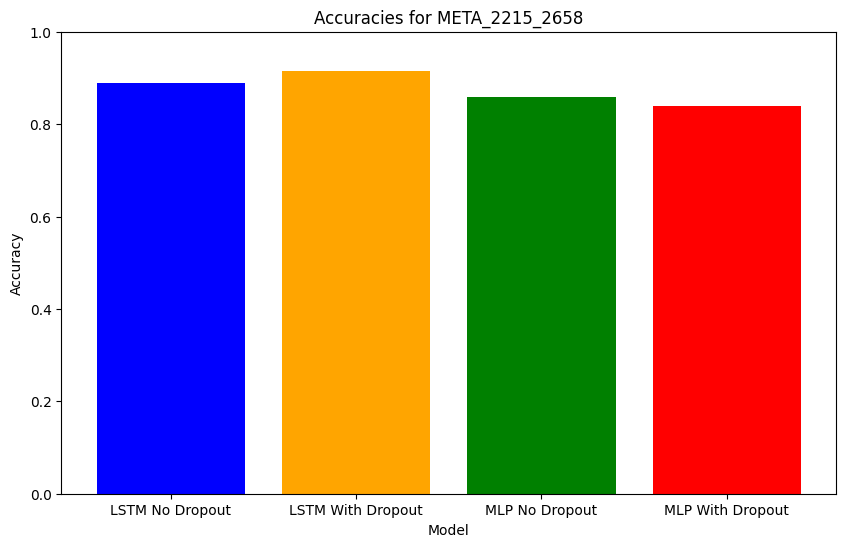


Results for AMZN_547_1089:
Accuracy LSTM without Dropout: 0.8874
Accuracy LSTM with Dropout: 0.8949
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.7454


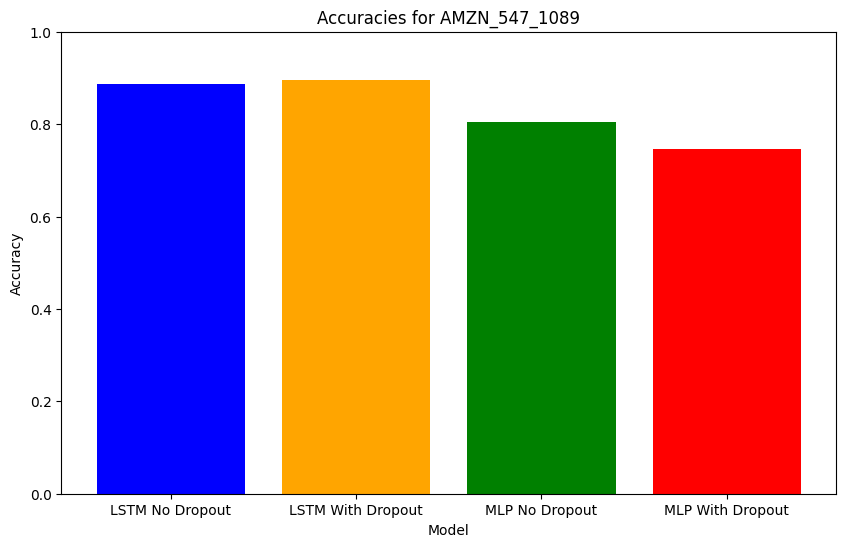


Results for AMZN_1089_1631:
Accuracy LSTM without Dropout: 0.9137
Accuracy LSTM with Dropout: 0.9231
Accuracy MLP without Dropout: 0.7768
Accuracy MLP with Dropout: 0.7768


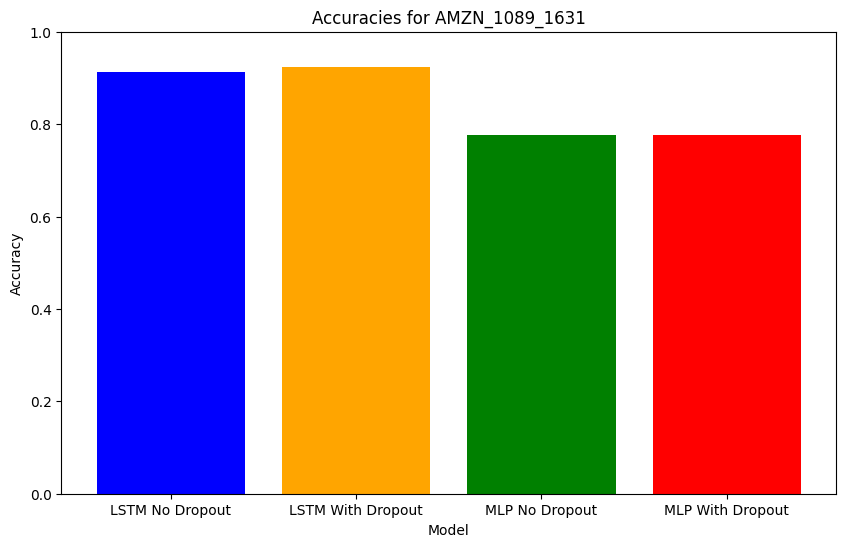


Results for AMZN_1631_2173:
Accuracy LSTM without Dropout: 0.8518
Accuracy LSTM with Dropout: 0.8818
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.8210


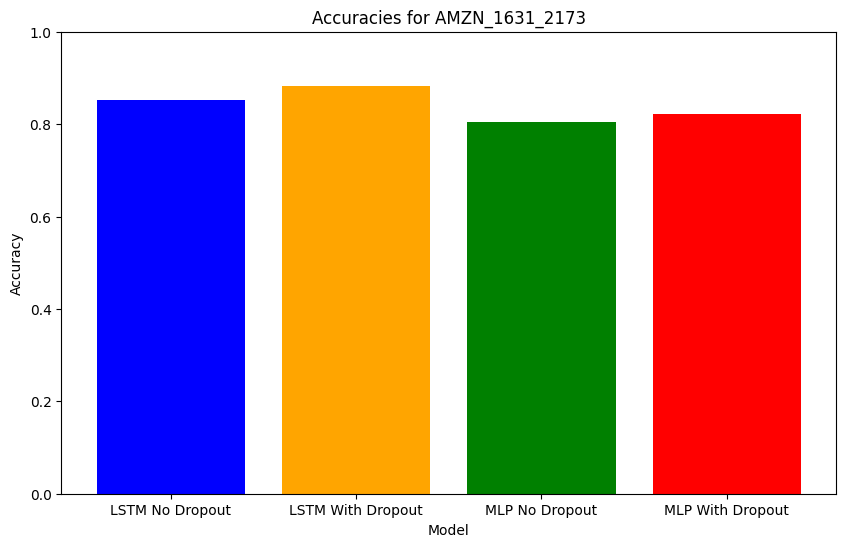


Results for AMZN_2173_2715:
Accuracy LSTM without Dropout: 0.8649
Accuracy LSTM with Dropout: 0.9006
Accuracy MLP without Dropout: 0.7325
Accuracy MLP with Dropout: 0.8413


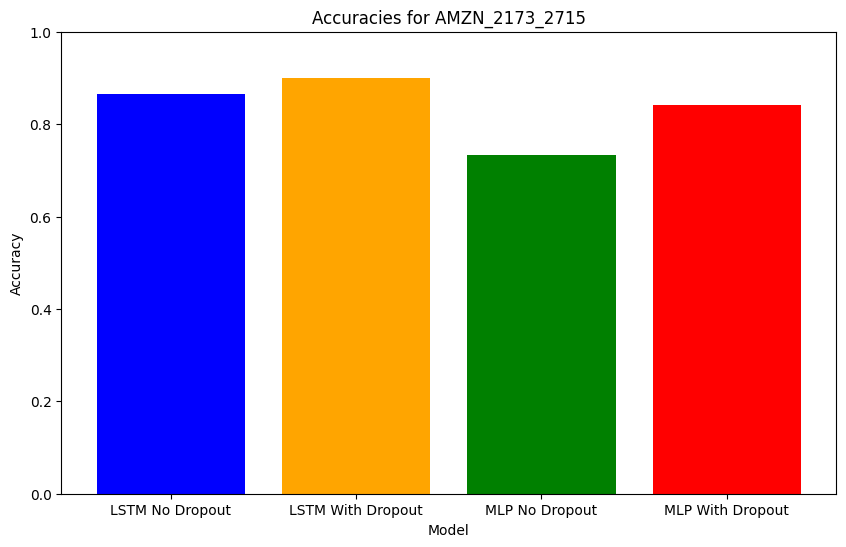


Results for AMZN_2715_3257:
Accuracy LSTM without Dropout: 0.8780
Accuracy LSTM with Dropout: 0.9043
Accuracy MLP without Dropout: 0.8210
Accuracy MLP with Dropout: 0.8192


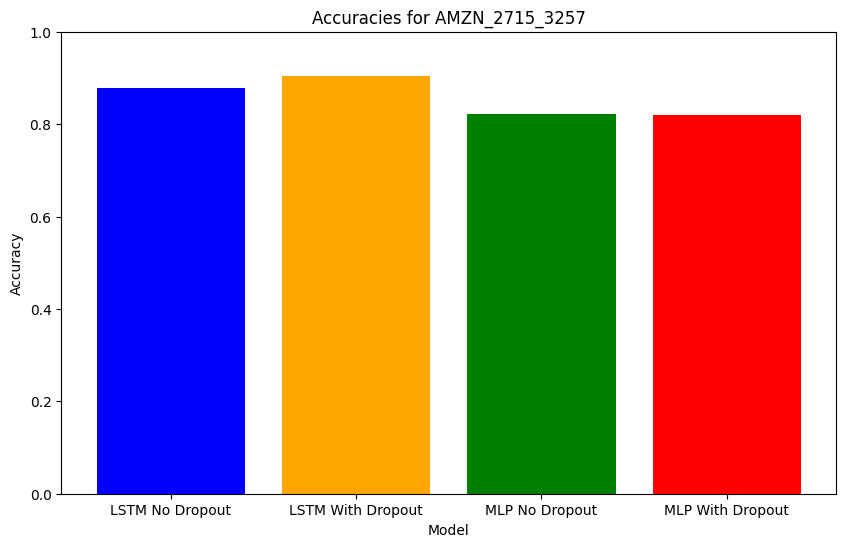


Results for MSFT_547_1089:
Accuracy LSTM without Dropout: 0.8949
Accuracy LSTM with Dropout: 0.9156
Accuracy MLP without Dropout: 0.7989
Accuracy MLP with Dropout: 0.7712


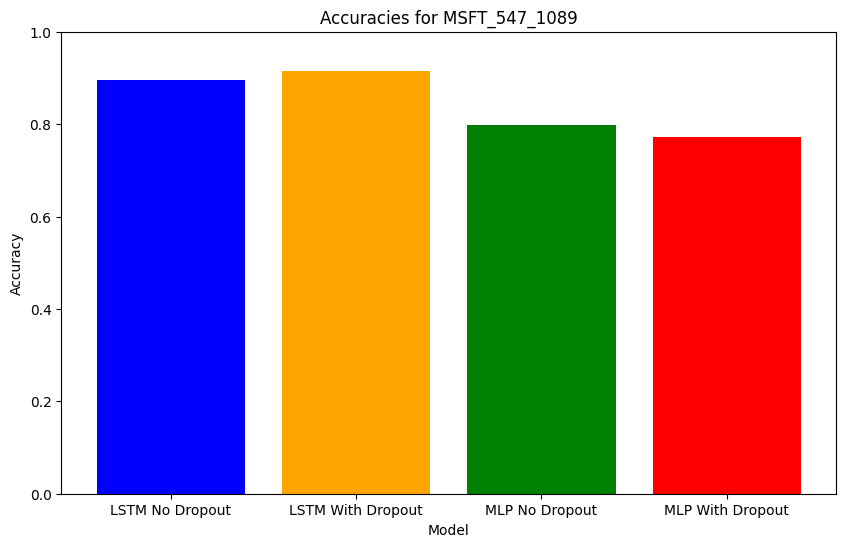


Results for MSFT_1089_1631:
Accuracy LSTM without Dropout: 0.8687
Accuracy LSTM with Dropout: 0.8931
Accuracy MLP without Dropout: 0.8007
Accuracy MLP with Dropout: 0.7897


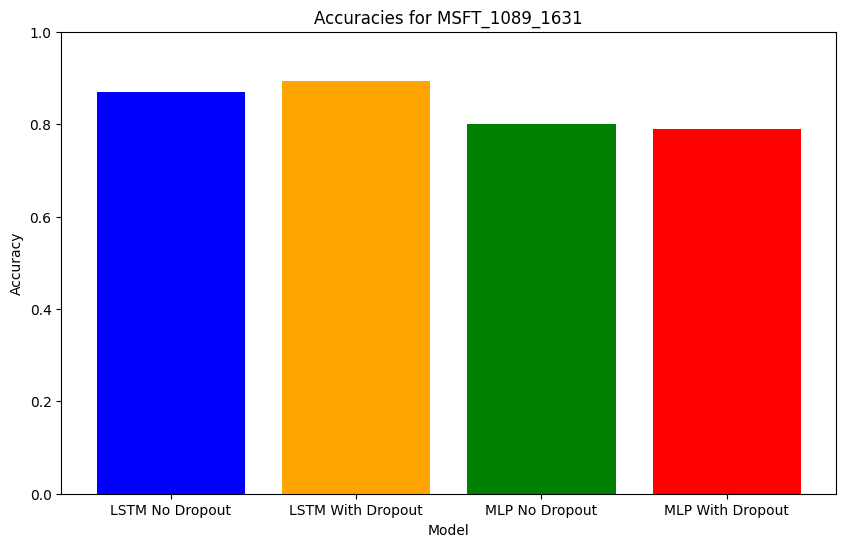


Results for MSFT_1631_2173:
Accuracy LSTM without Dropout: 0.8912
Accuracy LSTM with Dropout: 0.9081
Accuracy MLP without Dropout: 0.8118
Accuracy MLP with Dropout: 0.8063


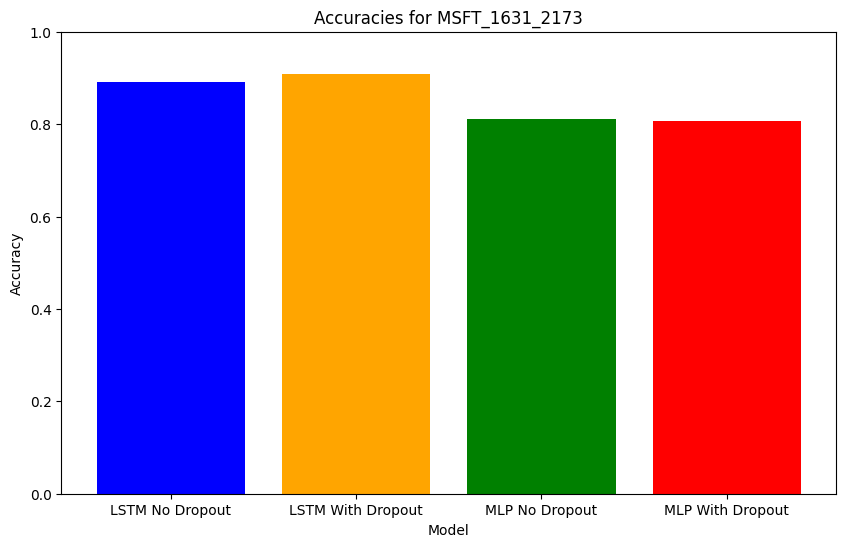


Results for MSFT_2173_2715:
Accuracy LSTM without Dropout: 0.7411
Accuracy LSTM with Dropout: 0.7317
Accuracy MLP without Dropout: 0.7546
Accuracy MLP with Dropout: 0.7269


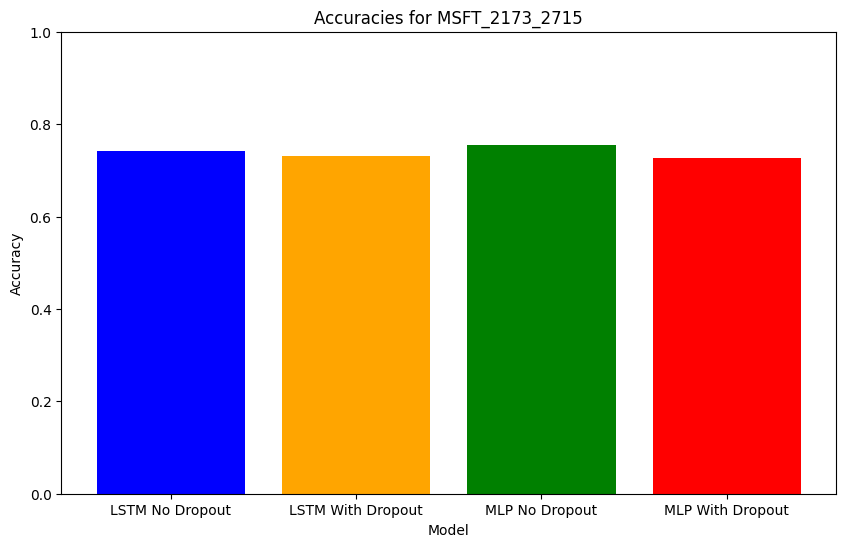


Results for MSFT_2715_3257:
Accuracy LSTM without Dropout: 0.9118
Accuracy LSTM with Dropout: 0.8931
Accuracy MLP without Dropout: 0.8063
Accuracy MLP with Dropout: 0.8192


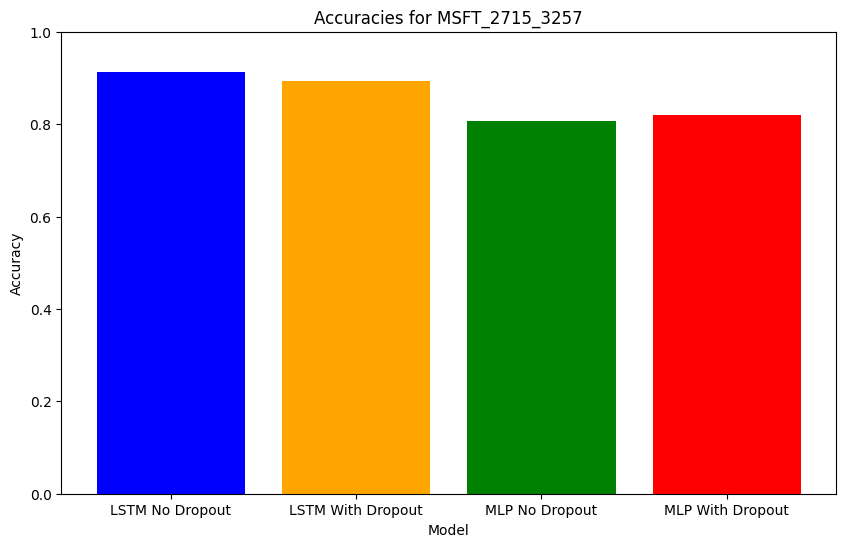


Results for GOOGL_547_1089:
Accuracy LSTM without Dropout: 0.8593
Accuracy LSTM with Dropout: 0.8968
Accuracy MLP without Dropout: 0.6882
Accuracy MLP with Dropout: 0.7232


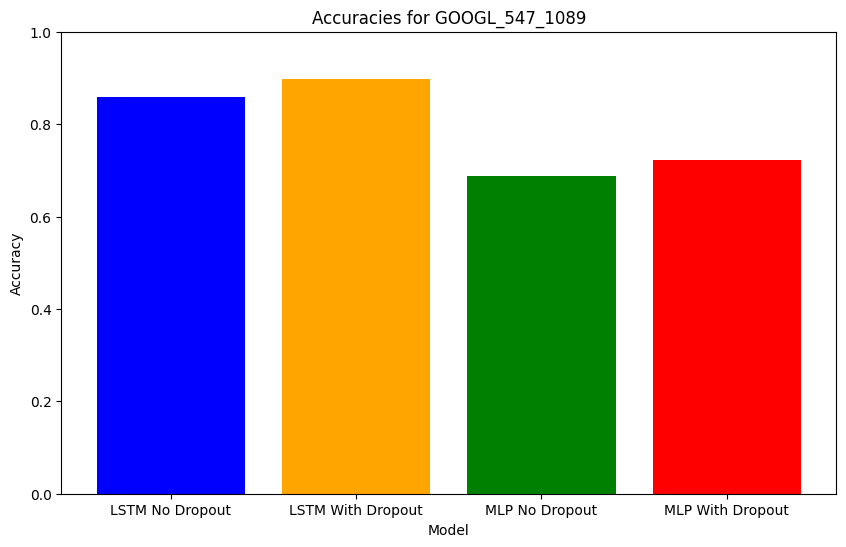


Results for GOOGL_1089_1631:
Accuracy LSTM without Dropout: 0.9099
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.7749
Accuracy MLP with Dropout: 0.7546


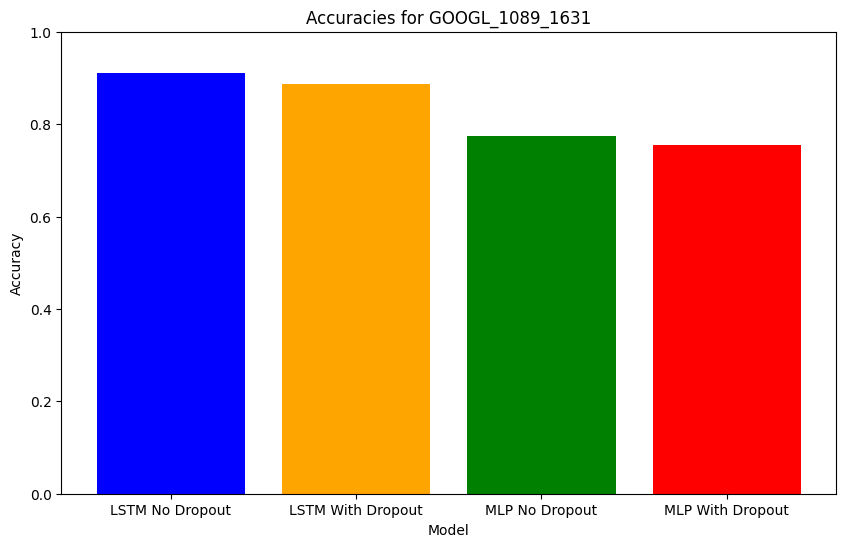


Results for GOOGL_1631_2173:
Accuracy LSTM without Dropout: 0.8818
Accuracy LSTM with Dropout: 0.9118
Accuracy MLP without Dropout: 0.8137
Accuracy MLP with Dropout: 0.8173


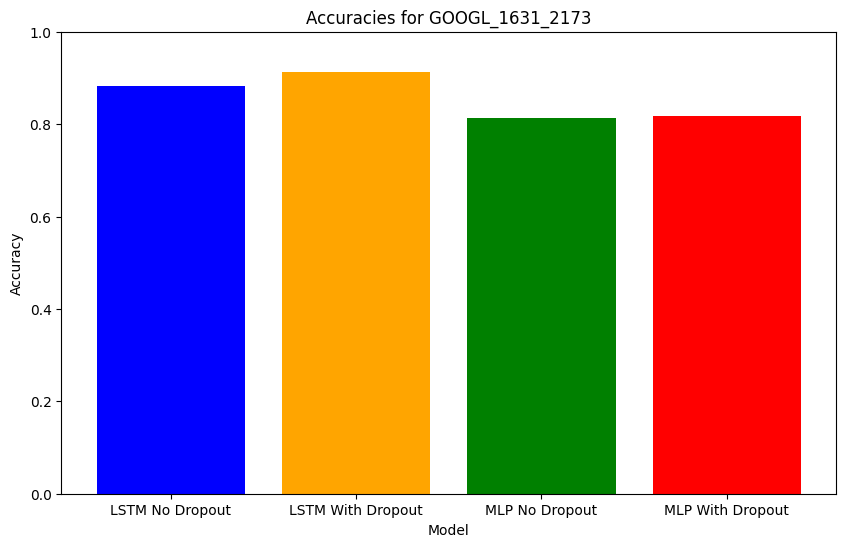


Results for GOOGL_2173_2715:
Accuracy LSTM without Dropout: 0.8386
Accuracy LSTM with Dropout: 0.9024
Accuracy MLP without Dropout: 0.8063
Accuracy MLP with Dropout: 0.8173


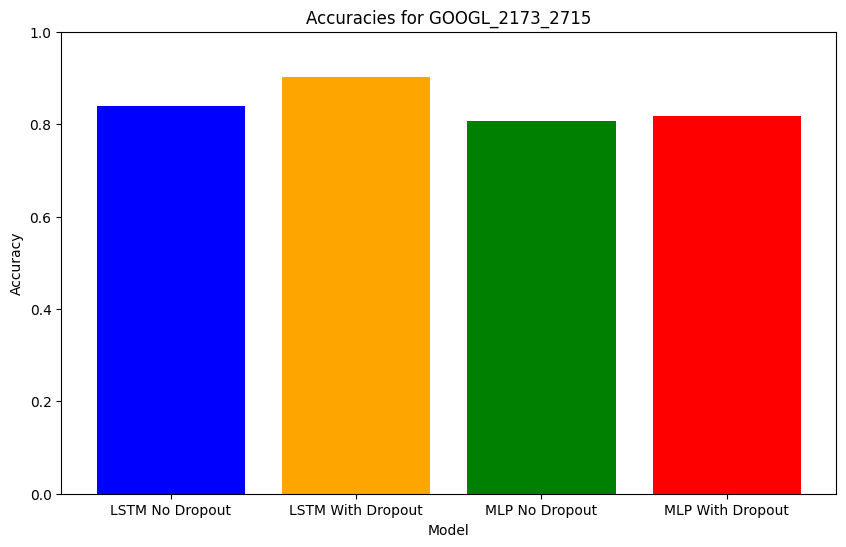


Results for GOOGL_2715_3257:
Accuracy LSTM without Dropout: 0.8218
Accuracy LSTM with Dropout: 0.8949
Accuracy MLP without Dropout: 0.7786
Accuracy MLP with Dropout: 0.8339


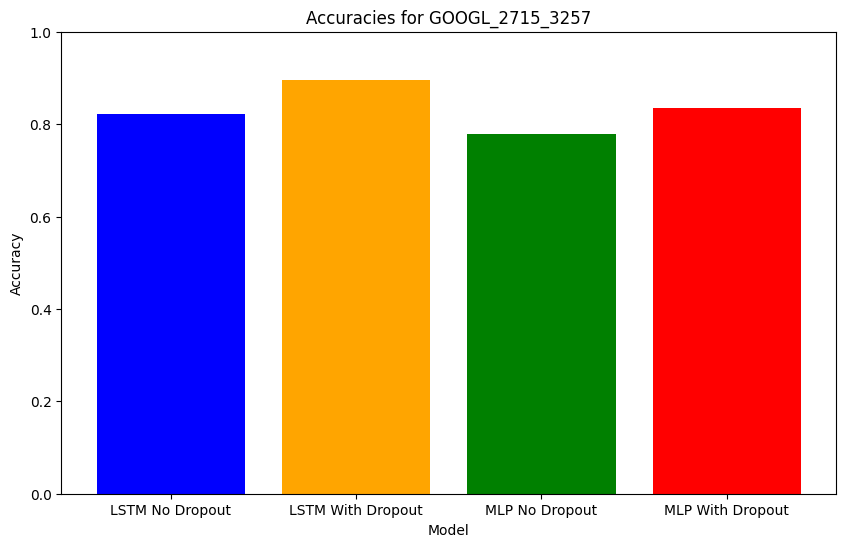


Results for GOOGL_1_548:
Accuracy LSTM without Dropout: 0.8818
Accuracy LSTM with Dropout: 0.8949
Accuracy MLP without Dropout: 0.8247
Accuracy MLP with Dropout: 0.8284


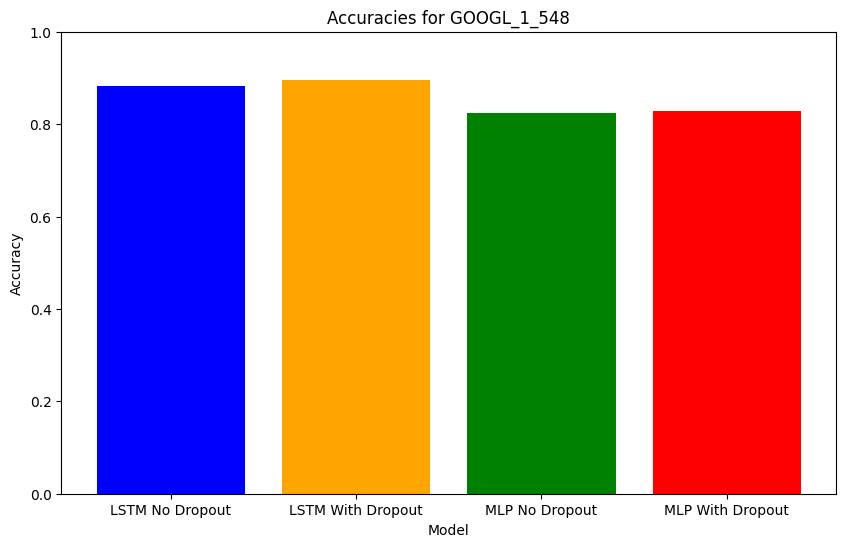


Results for GOOGL_1_1090:
Accuracy LSTM without Dropout: 0.9137
Accuracy LSTM with Dropout: 0.8893
Accuracy MLP without Dropout: 0.8192
Accuracy MLP with Dropout: 0.8358


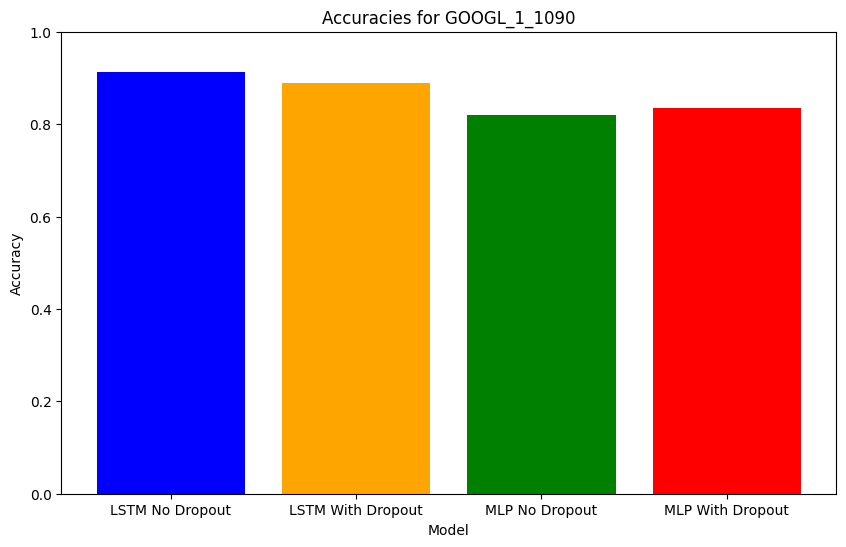


Results for GOOGL_1_1632:
Accuracy LSTM without Dropout: 0.8818
Accuracy LSTM with Dropout: 0.9043
Accuracy MLP without Dropout: 0.8210
Accuracy MLP with Dropout: 0.8266


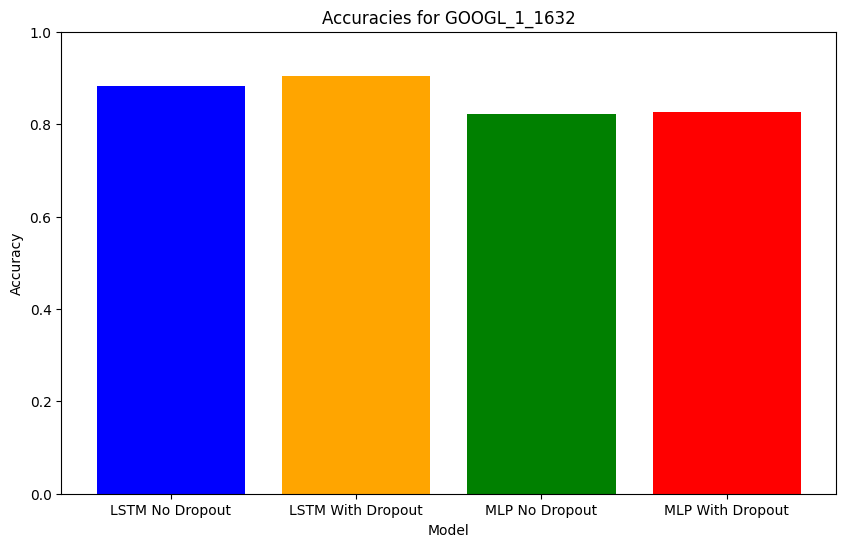


Results for GOOGL_1_2174:
Accuracy LSTM without Dropout: 0.8668
Accuracy LSTM with Dropout: 0.9006
Accuracy MLP without Dropout: 0.8137
Accuracy MLP with Dropout: 0.8266


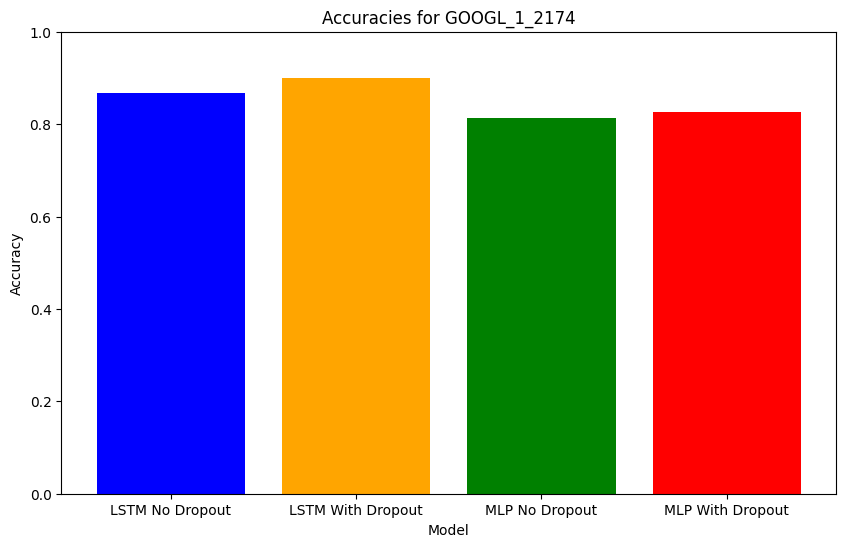


Results for GOOGL_1_2716:
Accuracy LSTM without Dropout: 0.8480
Accuracy LSTM with Dropout: 0.9174
Accuracy MLP without Dropout: 0.8210
Accuracy MLP with Dropout: 0.8173


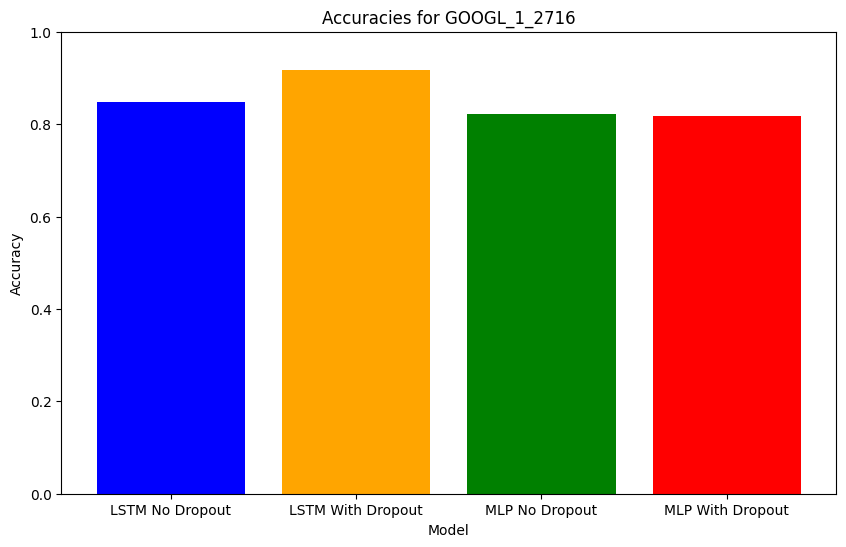

In [ ]:
# Visualization
for key, value in results.items():
    print(f'\nResults for {key}:')
    print(f'Accuracy LSTM without Dropout: {value["accuracy_lstm_no_dropout"]:.4f}')
    print(f'Accuracy LSTM with Dropout: {value["accuracy_lstm_dropout"]:.4f}')
    print(f'Accuracy MLP without Dropout: {value["accuracy_mlp_no_dropout"]:.4f}')
    print(f'Accuracy MLP with Dropout: {value["accuracy_mlp_dropout"]:.4f}')

    # Plot accuracies with a bar chart
    models = ['LSTM No Dropout', 'LSTM With Dropout', 'MLP No Dropout', 'MLP With Dropout']
    accuracies = [value['accuracy_lstm_no_dropout'], value['accuracy_lstm_dropout'], value['accuracy_mlp_no_dropout'], value['accuracy_mlp_dropout']]

    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'])
    plt.title(f'Accuracies for {key}')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
    plt.show()


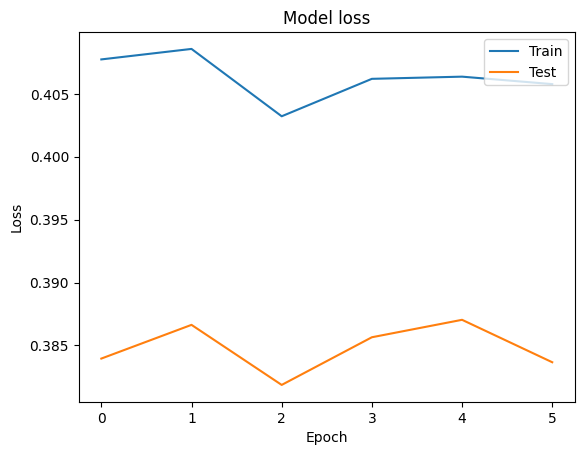

In [ ]:
import matplotlib.pyplot as plt

history = model_mlp.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping_mlp], verbose=0)

# Plotting the learning curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()



Results for AAPL_547_1089:
Accuracy LSTM without Dropout: 0.8780
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.7048
Accuracy MLP with Dropout: 0.7159


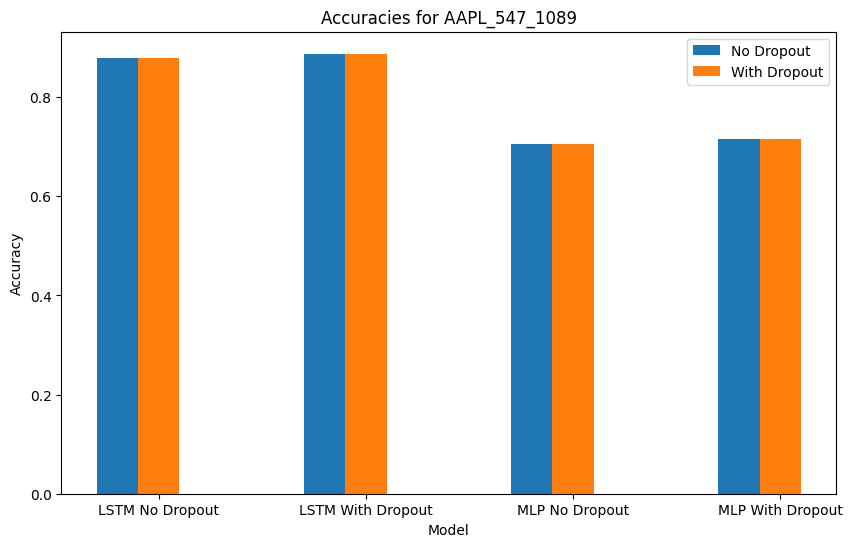


Results for AAPL_1089_1631:
Accuracy LSTM without Dropout: 0.9118
Accuracy LSTM with Dropout: 0.9099
Accuracy MLP without Dropout: 0.8173
Accuracy MLP with Dropout: 0.7915


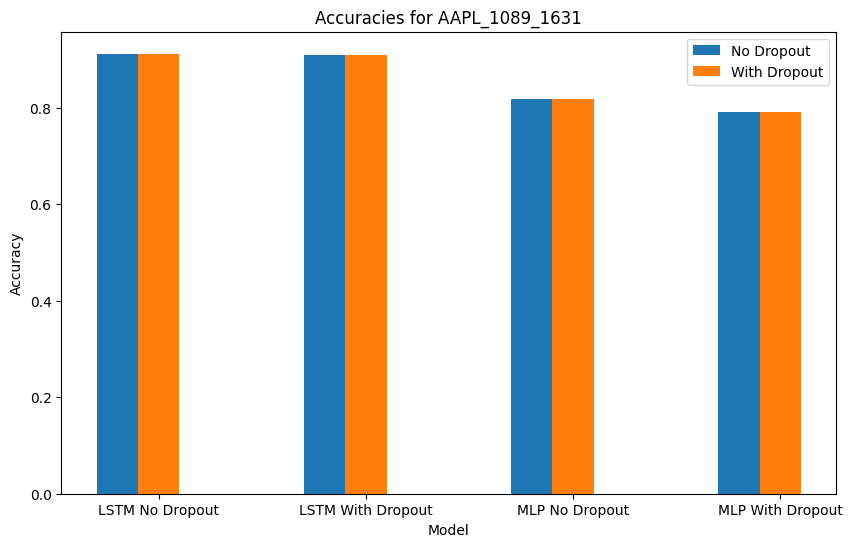


Results for AAPL_1631_2173:
Accuracy LSTM without Dropout: 0.9287
Accuracy LSTM with Dropout: 0.9268
Accuracy MLP without Dropout: 0.8007
Accuracy MLP with Dropout: 0.7694


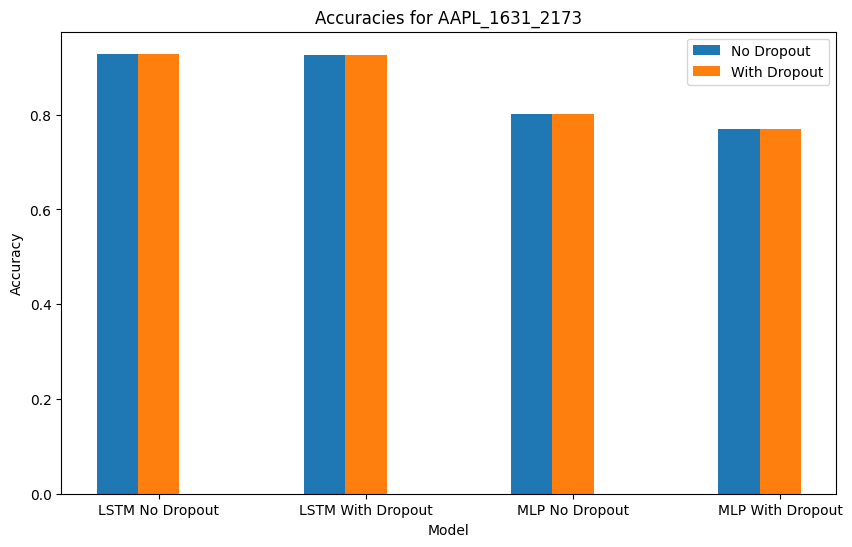


Results for AAPL_2173_2715:
Accuracy LSTM without Dropout: 0.8893
Accuracy LSTM with Dropout: 0.8499
Accuracy MLP without Dropout: 0.8081
Accuracy MLP with Dropout: 0.8100


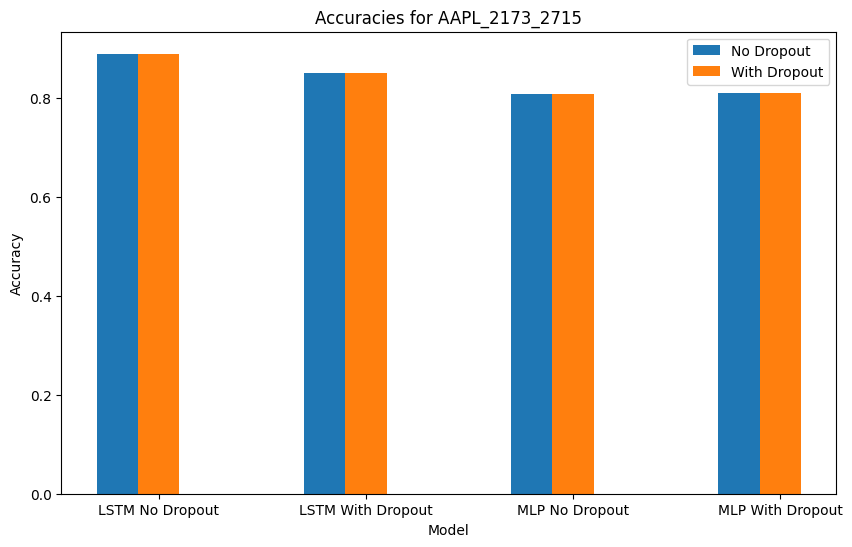


Results for AAPL_2715_3257:
Accuracy LSTM without Dropout: 0.8612
Accuracy LSTM with Dropout: 0.9081
Accuracy MLP without Dropout: 0.8007
Accuracy MLP with Dropout: 0.8137


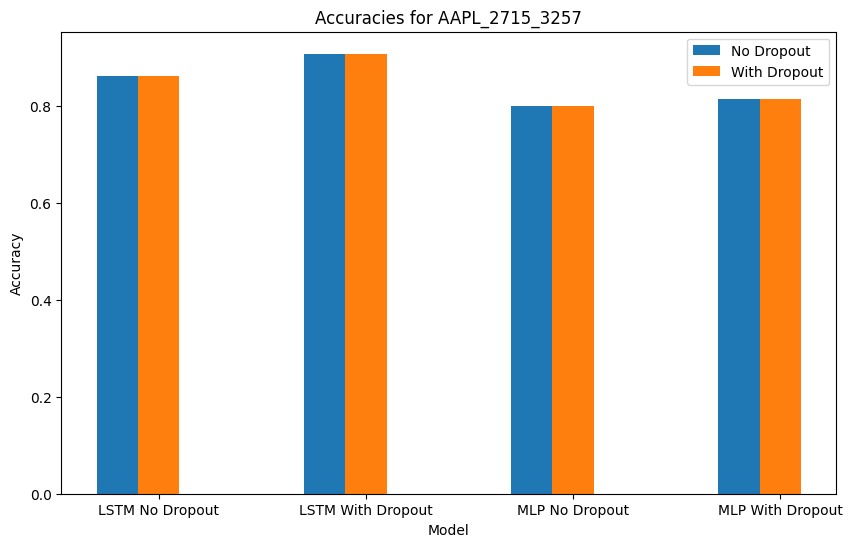


Results for META_443_886:
Accuracy LSTM without Dropout: 0.8848
Accuracy LSTM with Dropout: 0.9032
Accuracy MLP without Dropout: 0.7088
Accuracy MLP with Dropout: 0.7765


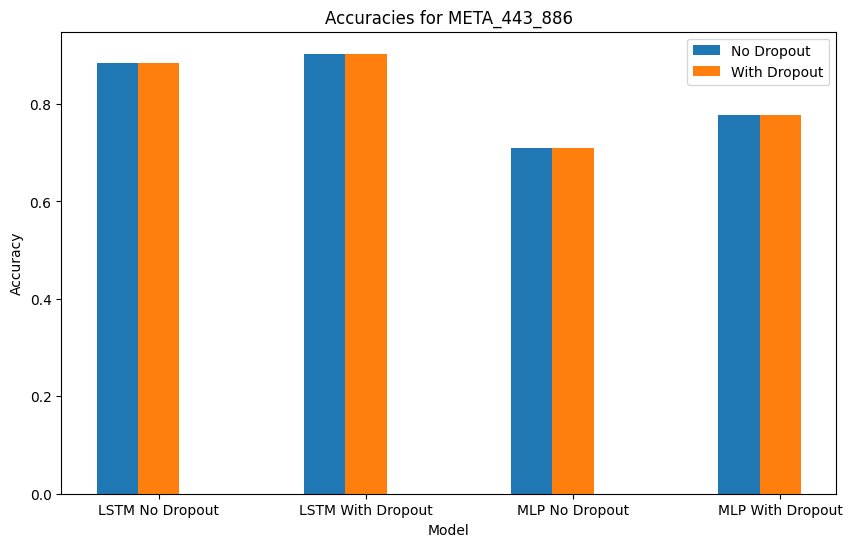


Results for META_886_1329:
Accuracy LSTM without Dropout: 0.8871
Accuracy LSTM with Dropout: 0.9147
Accuracy MLP without Dropout: 0.7652
Accuracy MLP with Dropout: 0.7675


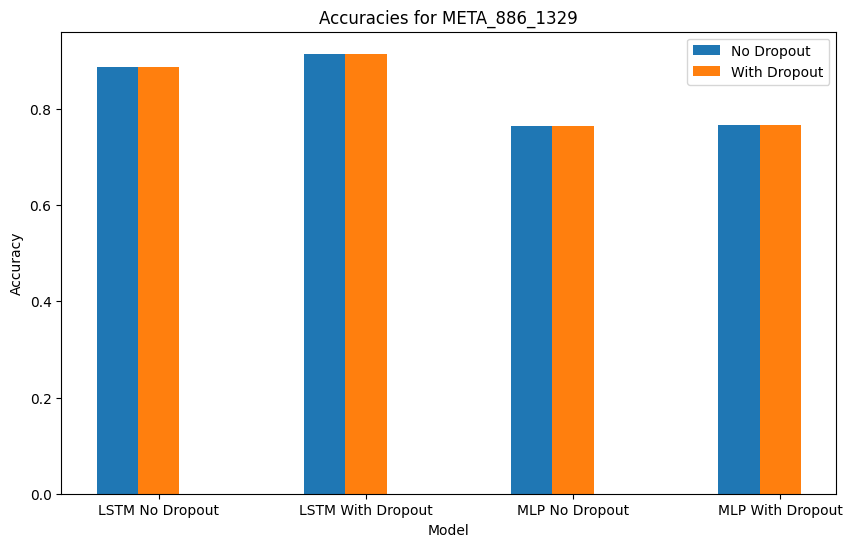


Results for META_1329_1772:
Accuracy LSTM without Dropout: 0.7604
Accuracy LSTM with Dropout: 0.8963
Accuracy MLP without Dropout: 0.8014
Accuracy MLP with Dropout: 0.7607


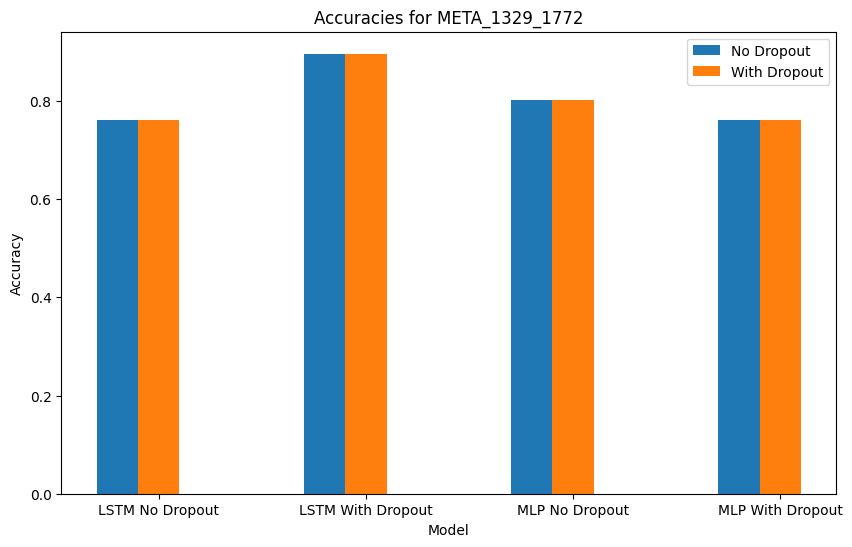


Results for META_1772_2215:
Accuracy LSTM without Dropout: 0.7488
Accuracy LSTM with Dropout: 0.7419
Accuracy MLP without Dropout: 0.7878
Accuracy MLP with Dropout: 0.8465


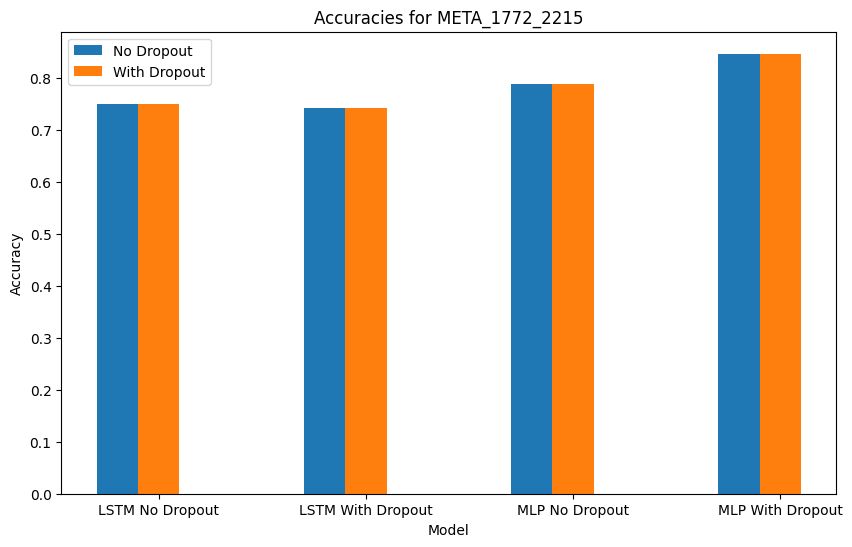


Results for META_2215_2658:
Accuracy LSTM without Dropout: 0.8963
Accuracy LSTM with Dropout: 0.9263
Accuracy MLP without Dropout: 0.8420
Accuracy MLP with Dropout: 0.8352


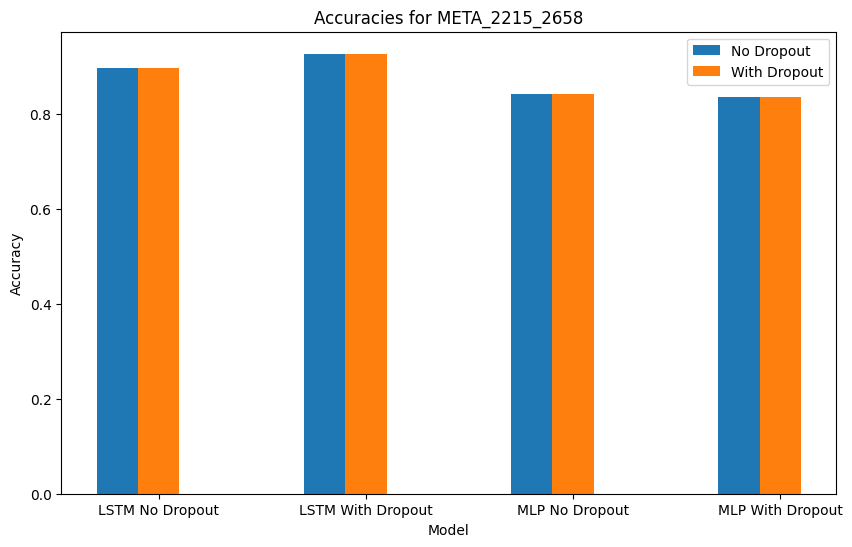


Results for AMZN_547_1089:
Accuracy LSTM without Dropout: 0.8799
Accuracy LSTM with Dropout: 0.8912
Accuracy MLP without Dropout: 0.7288
Accuracy MLP with Dropout: 0.7214


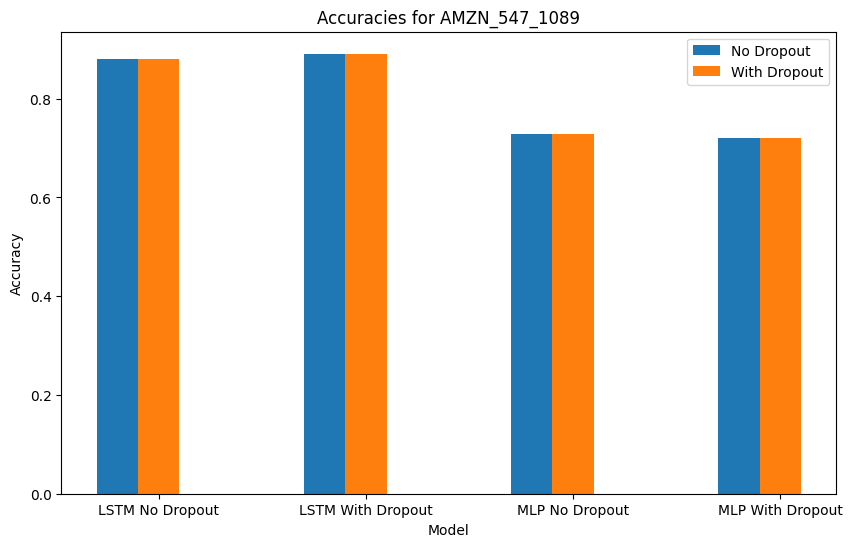


Results for AMZN_1089_1631:
Accuracy LSTM without Dropout: 0.9231
Accuracy LSTM with Dropout: 0.9268
Accuracy MLP without Dropout: 0.8137
Accuracy MLP with Dropout: 0.7786


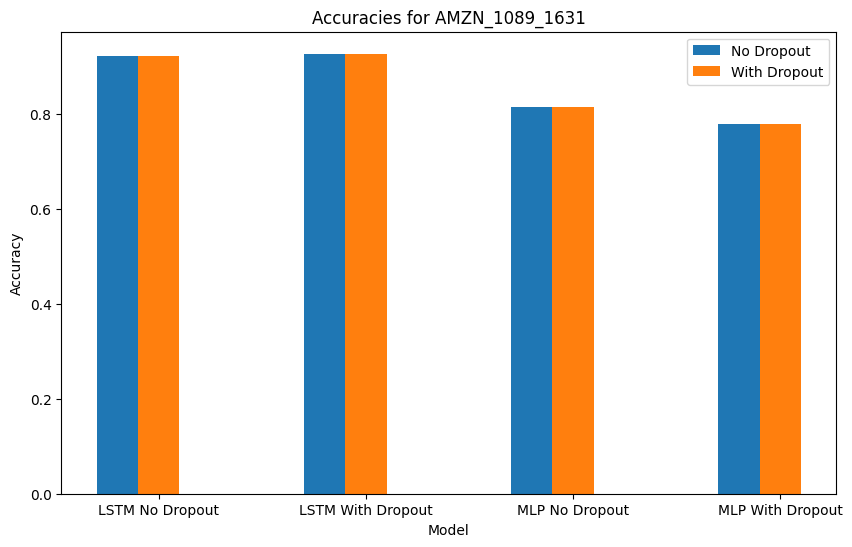


Results for AMZN_1631_2173:
Accuracy LSTM without Dropout: 0.8687
Accuracy LSTM with Dropout: 0.9024
Accuracy MLP without Dropout: 0.8266
Accuracy MLP with Dropout: 0.8081


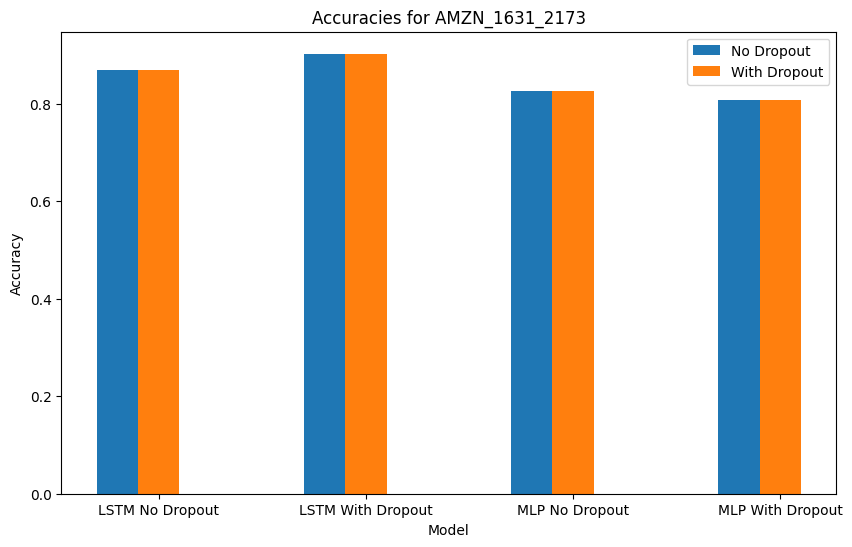


Results for AMZN_2173_2715:
Accuracy LSTM without Dropout: 0.8630
Accuracy LSTM with Dropout: 0.8687
Accuracy MLP without Dropout: 0.7675
Accuracy MLP with Dropout: 0.8173


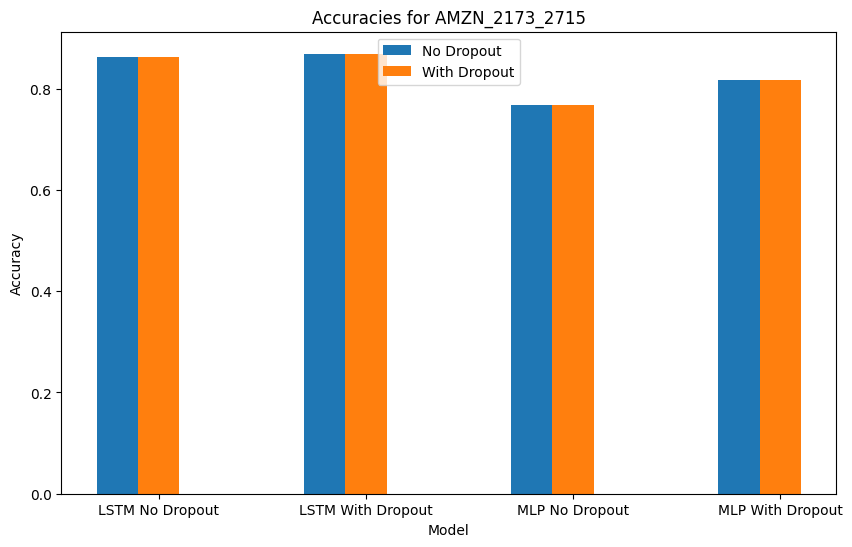


Results for AMZN_2715_3257:
Accuracy LSTM without Dropout: 0.9006
Accuracy LSTM with Dropout: 0.9137
Accuracy MLP without Dropout: 0.8118
Accuracy MLP with Dropout: 0.8321


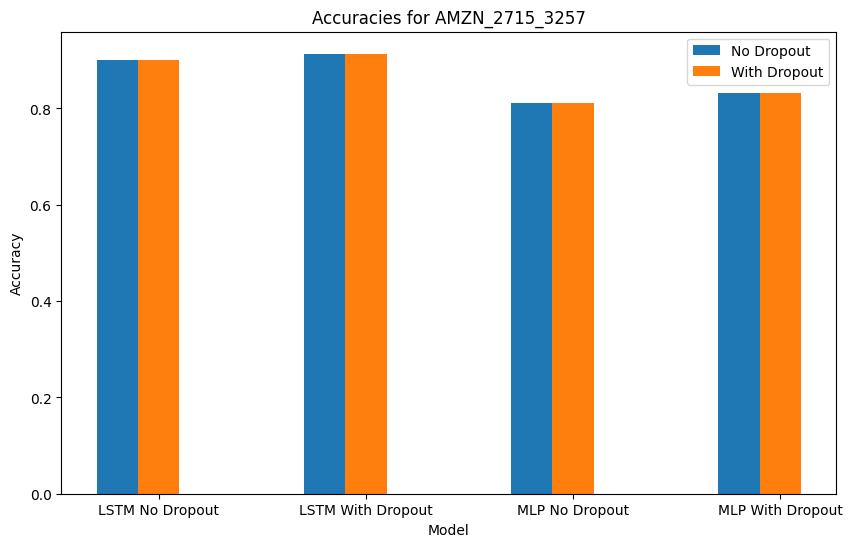


Results for MSFT_547_1089:
Accuracy LSTM without Dropout: 0.8874
Accuracy LSTM with Dropout: 0.9137
Accuracy MLP without Dropout: 0.8063
Accuracy MLP with Dropout: 0.7288


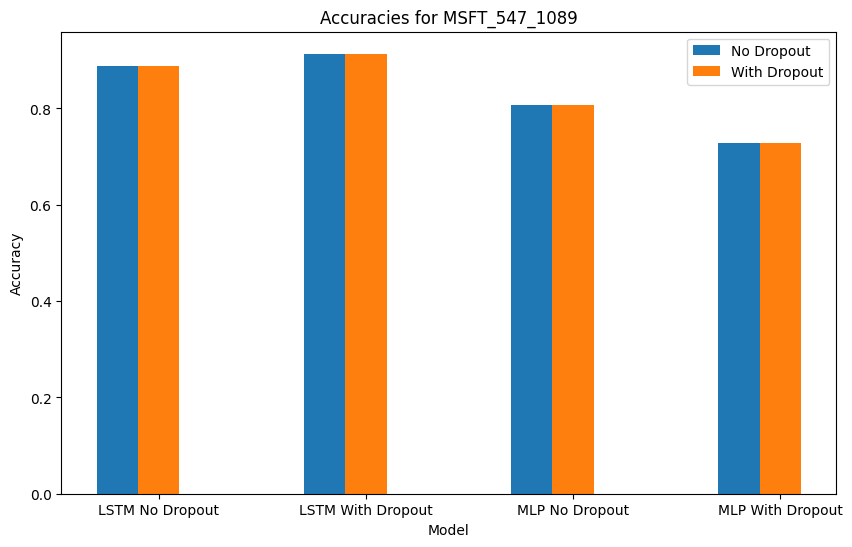


Results for MSFT_1089_1631:
Accuracy LSTM without Dropout: 0.8780
Accuracy LSTM with Dropout: 0.8912
Accuracy MLP without Dropout: 0.7970
Accuracy MLP with Dropout: 0.7860


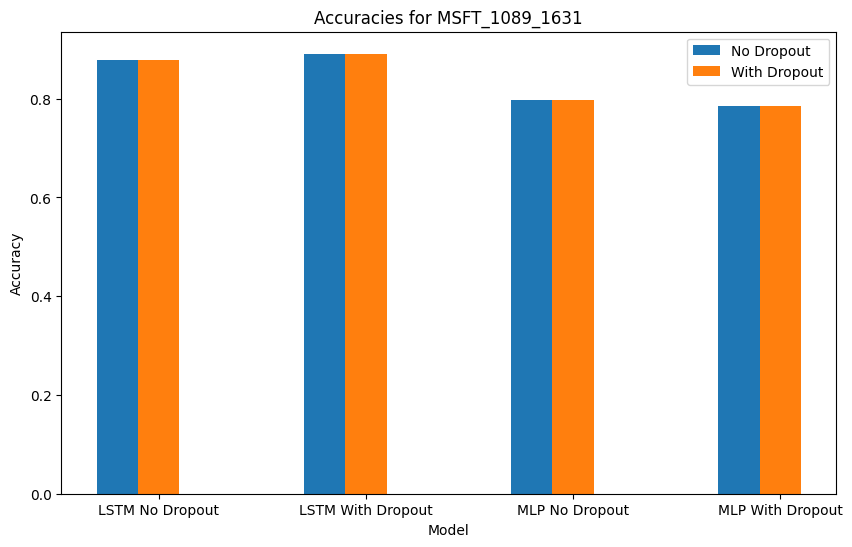


Results for MSFT_1631_2173:
Accuracy LSTM without Dropout: 0.8912
Accuracy LSTM with Dropout: 0.9212
Accuracy MLP without Dropout: 0.7934
Accuracy MLP with Dropout: 0.7915


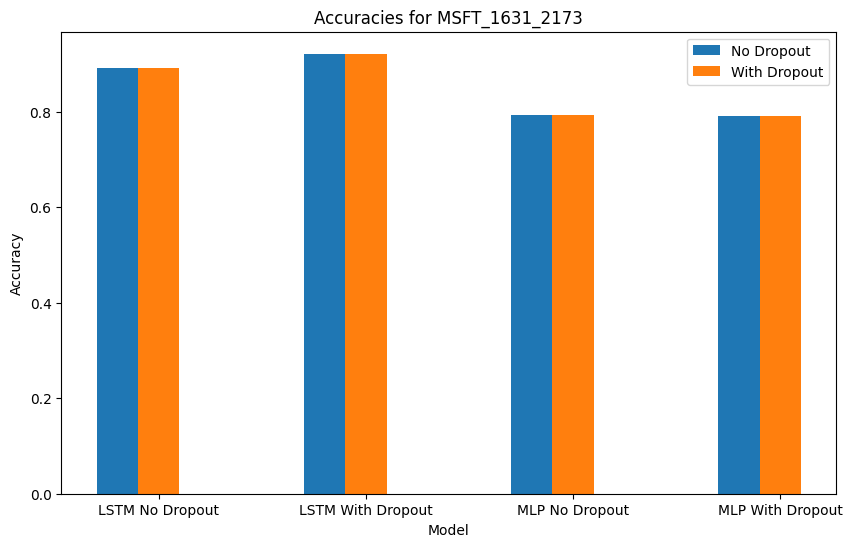


Results for MSFT_2173_2715:
Accuracy LSTM without Dropout: 0.7561
Accuracy LSTM with Dropout: 0.7223
Accuracy MLP without Dropout: 0.8081
Accuracy MLP with Dropout: 0.8044


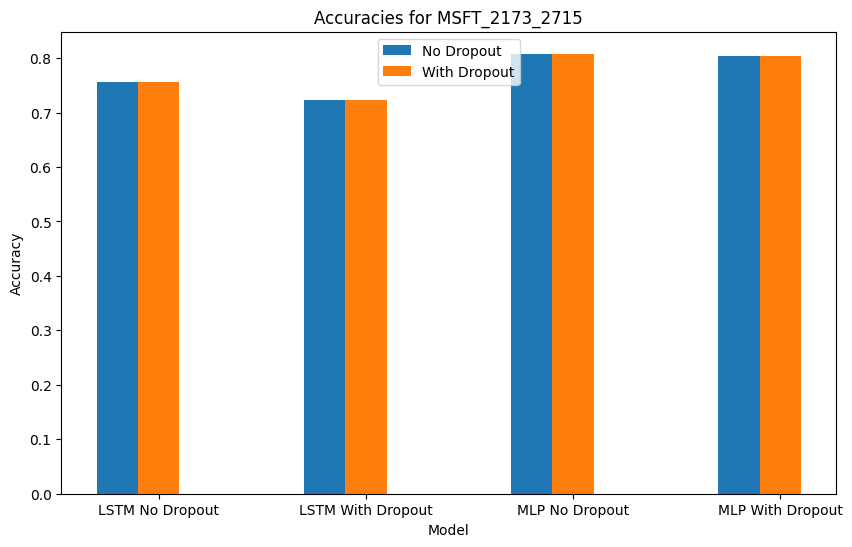


Results for MSFT_2715_3257:
Accuracy LSTM without Dropout: 0.8968
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.8137
Accuracy MLP with Dropout: 0.8118


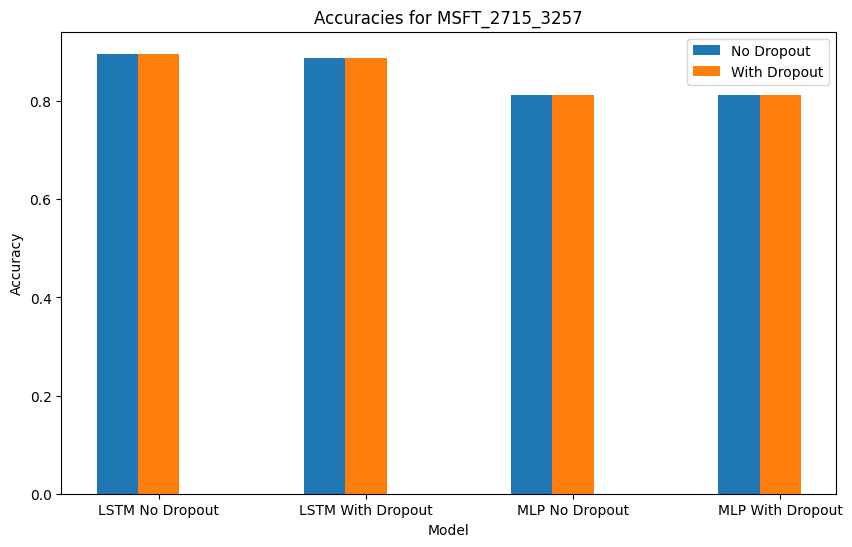


Results for GOOGL_547_1089:
Accuracy LSTM without Dropout: 0.8762
Accuracy LSTM with Dropout: 0.8949
Accuracy MLP without Dropout: 0.7657
Accuracy MLP with Dropout: 0.6827


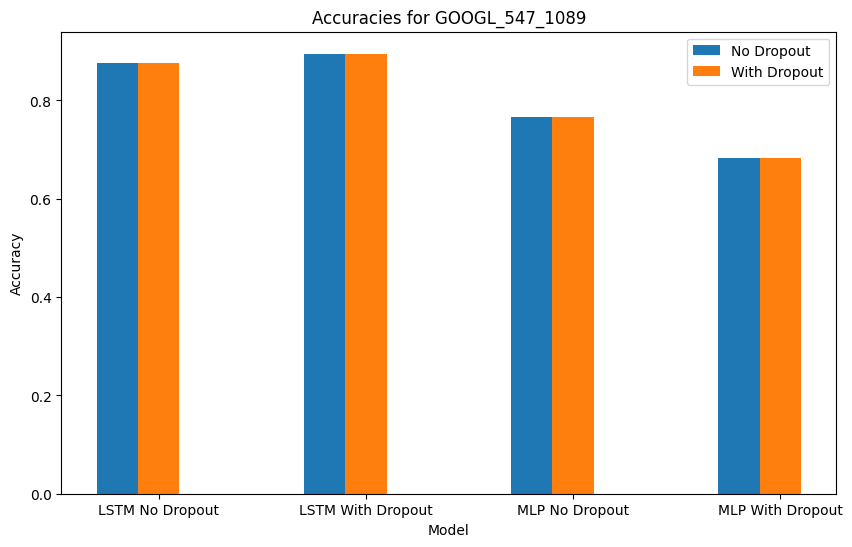


Results for GOOGL_1089_1631:
Accuracy LSTM without Dropout: 0.8912
Accuracy LSTM with Dropout: 0.9043
Accuracy MLP without Dropout: 0.7804
Accuracy MLP with Dropout: 0.7804


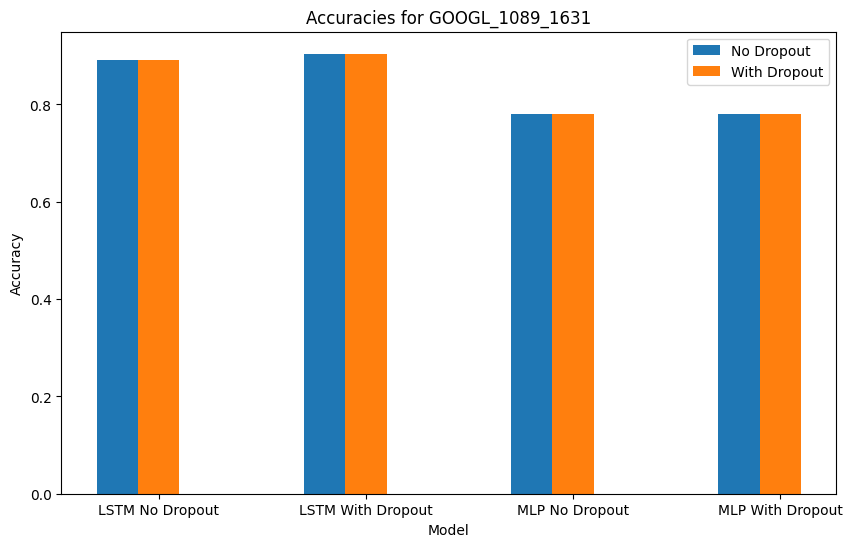


Results for GOOGL_1631_2173:
Accuracy LSTM without Dropout: 0.8837
Accuracy LSTM with Dropout: 0.8987
Accuracy MLP without Dropout: 0.8303
Accuracy MLP with Dropout: 0.8173


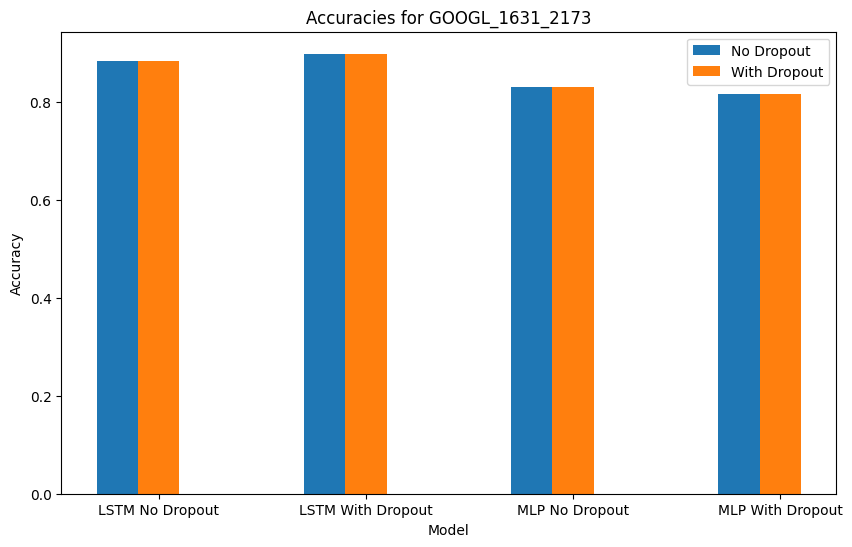


Results for GOOGL_2173_2715:
Accuracy LSTM without Dropout: 0.8799
Accuracy LSTM with Dropout: 0.9043
Accuracy MLP without Dropout: 0.8192
Accuracy MLP with Dropout: 0.8229


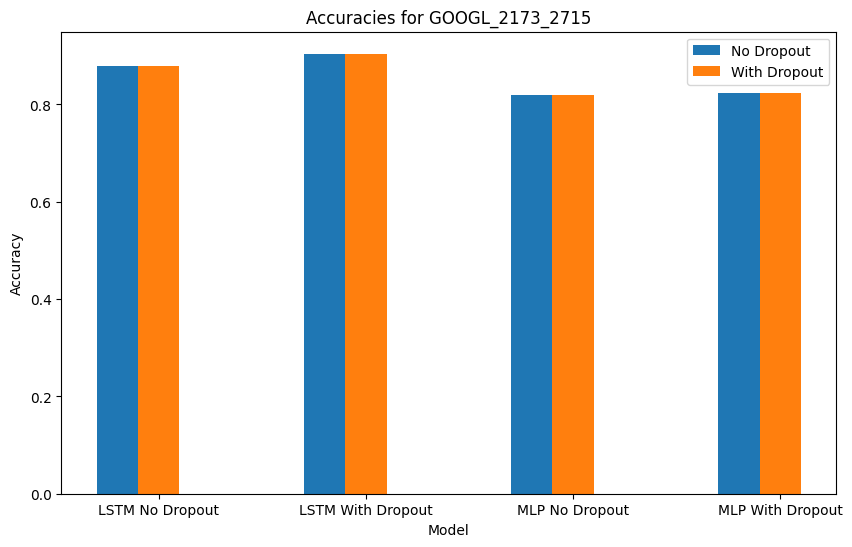


Results for GOOGL_2715_3257:
Accuracy LSTM without Dropout: 0.8349
Accuracy LSTM with Dropout: 0.9118
Accuracy MLP without Dropout: 0.7712
Accuracy MLP with Dropout: 0.8173


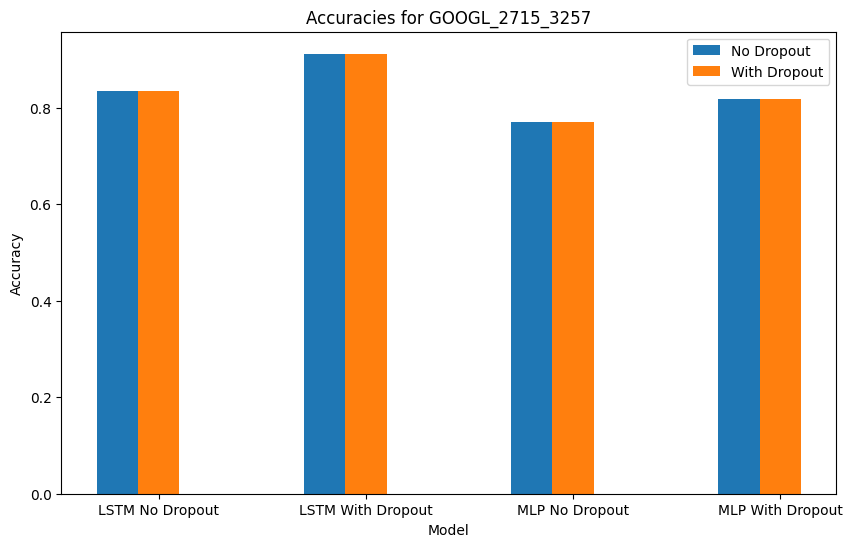


Results for GOOGL_1_548:
Accuracy LSTM without Dropout: 0.8874
Accuracy LSTM with Dropout: 0.8893
Accuracy MLP without Dropout: 0.7841
Accuracy MLP with Dropout: 0.8358


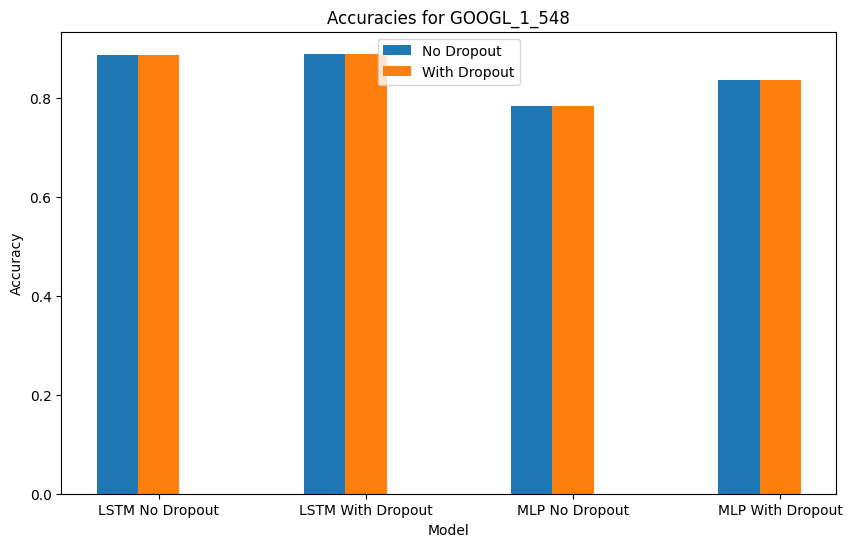


Results for GOOGL_1_1090:
Accuracy LSTM without Dropout: 0.8818
Accuracy LSTM with Dropout: 0.9043
Accuracy MLP without Dropout: 0.7841
Accuracy MLP with Dropout: 0.8266


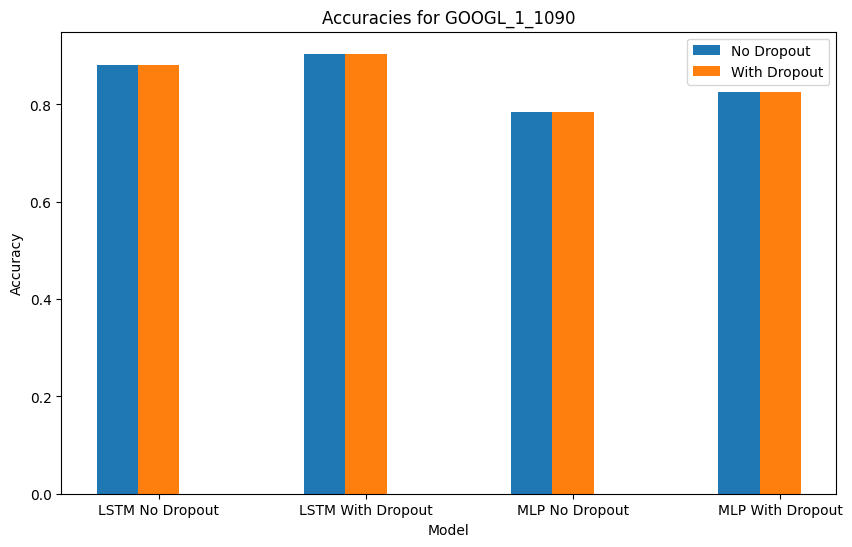


Results for GOOGL_1_1632:
Accuracy LSTM without Dropout: 0.8705
Accuracy LSTM with Dropout: 0.8912
Accuracy MLP without Dropout: 0.8063
Accuracy MLP with Dropout: 0.8266


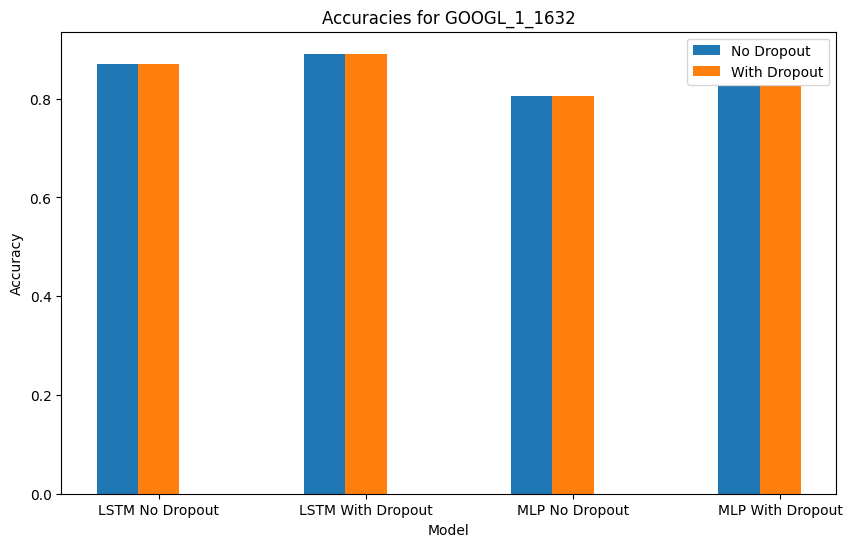


Results for GOOGL_1_2174:
Accuracy LSTM without Dropout: 0.8668
Accuracy LSTM with Dropout: 0.9006
Accuracy MLP without Dropout: 0.7749
Accuracy MLP with Dropout: 0.8247


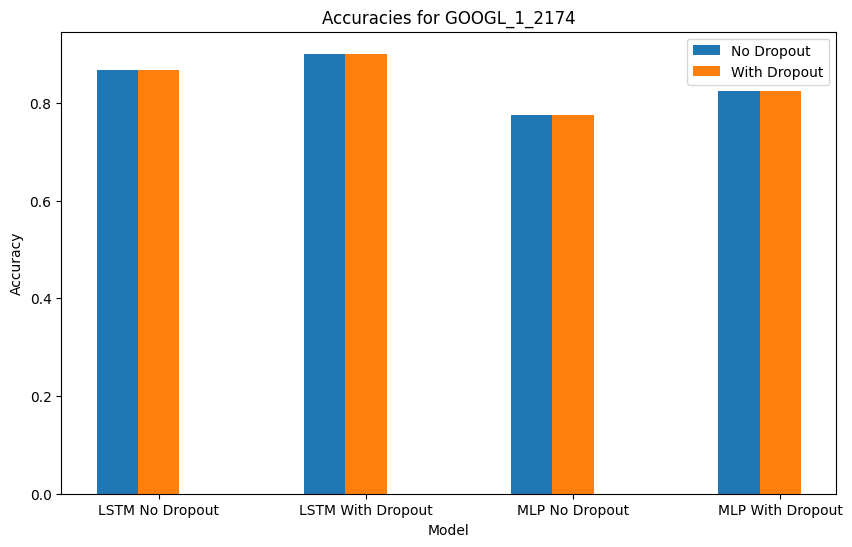


Results for GOOGL_1_2716:
Accuracy LSTM without Dropout: 0.8424
Accuracy LSTM with Dropout: 0.9118
Accuracy MLP without Dropout: 0.7934
Accuracy MLP with Dropout: 0.8321


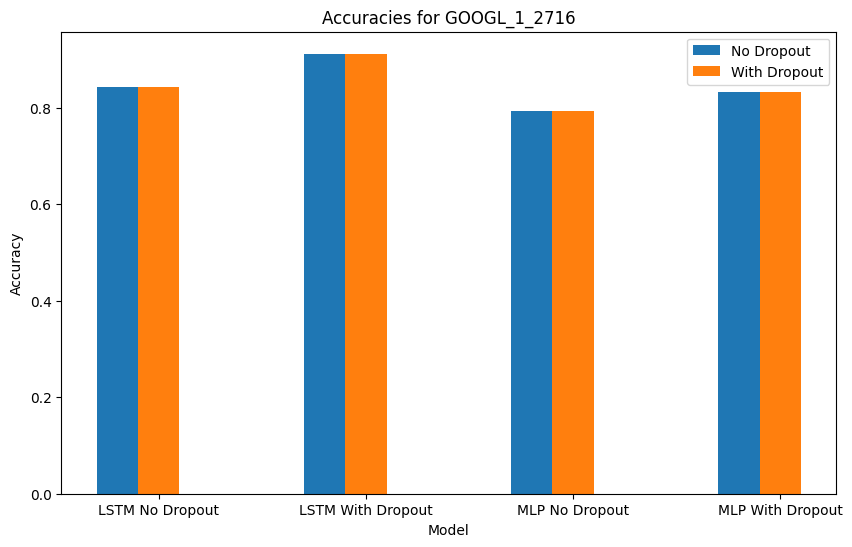

In [ ]:
# Visualization
for key, value in results.items():
    print(f'\nResults for {key}:')
    print(f'Accuracy LSTM without Dropout: {value["accuracy_lstm_no_dropout"]:.4f}')
    print(f'Accuracy LSTM with Dropout: {value["accuracy_lstm_dropout"]:.4f}')
    print(f'Accuracy MLP without Dropout: {value["accuracy_mlp_no_dropout"]:.4f}')
    print(f'Accuracy MLP with Dropout: {value["accuracy_mlp_dropout"]:.4f}')

    # Plot accuracies with a grouped bar chart
    models = ['LSTM No Dropout', 'LSTM With Dropout', 'MLP No Dropout', 'MLP With Dropout']
    accuracies = [value['accuracy_lstm_no_dropout'], value['accuracy_lstm_dropout'], value['accuracy_mlp_no_dropout'], value['accuracy_mlp_dropout']]

    bar_width = 0.2
    index = np.arange(len(models))

    plt.figure(figsize=(10, 6))

    plt.bar(index - bar_width, accuracies, bar_width, label='No Dropout')
    plt.bar(index, accuracies, bar_width, label='With Dropout')

    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracies for {key}')
    plt.xticks(index, models)
    plt.legend()
    plt.show()


17/17 [==============================] - 0s 1ms/step
MLP Accuracy for AAPL: 0.8265682656826568


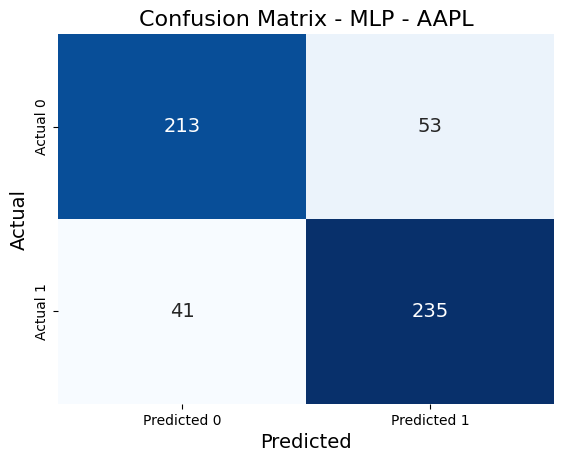

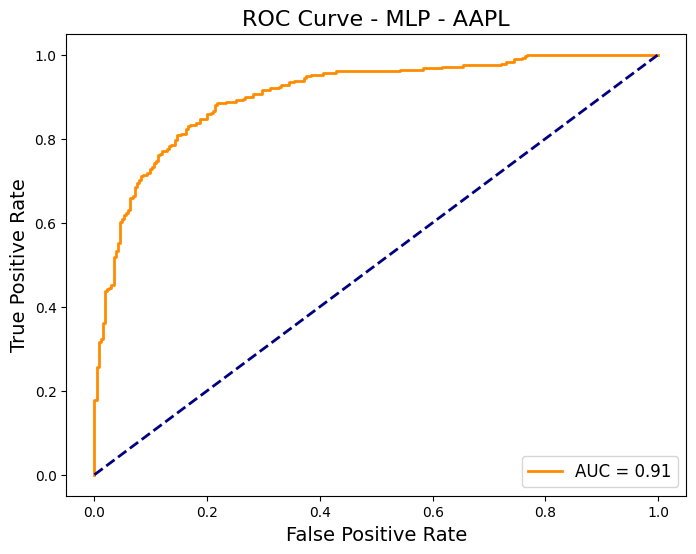

17/17 [==============================] - 0s 1ms/step
MLP Accuracy for META: 0.8265682656826568


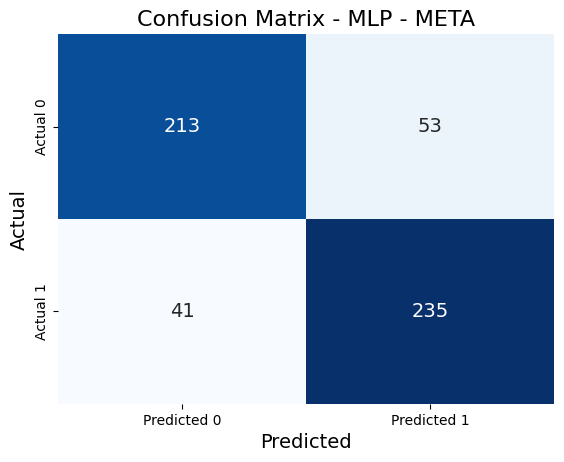

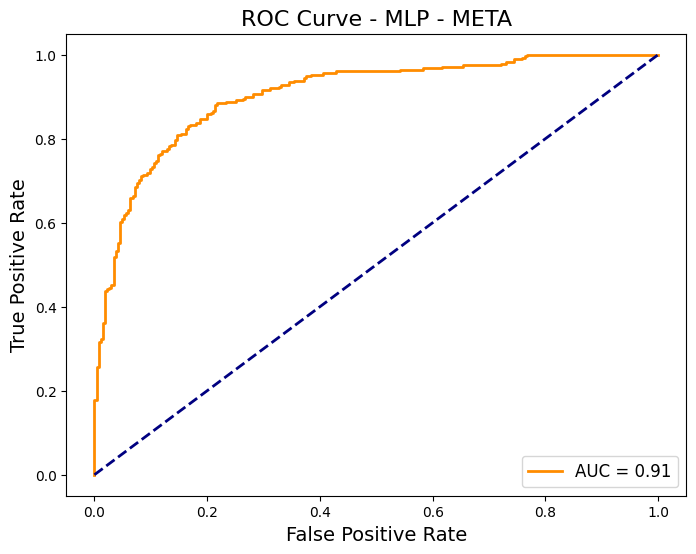

17/17 [==============================] - 0s 2ms/step
MLP Accuracy for AMZN: 0.8265682656826568


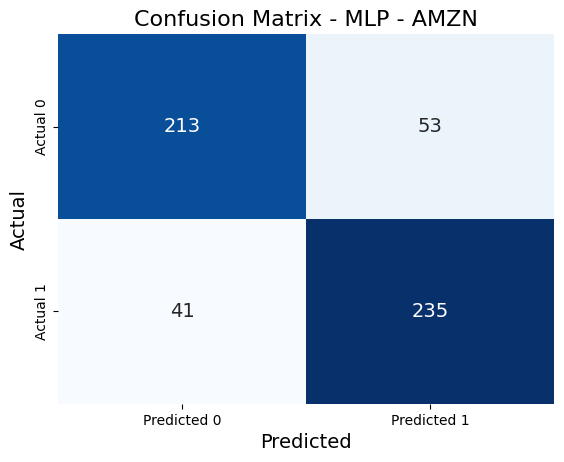

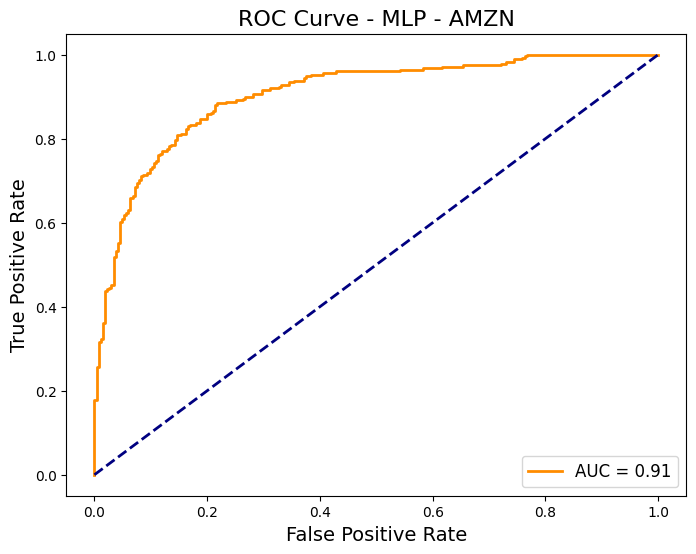

17/17 [==============================] - 0s 2ms/step
MLP Accuracy for MSFT: 0.8265682656826568


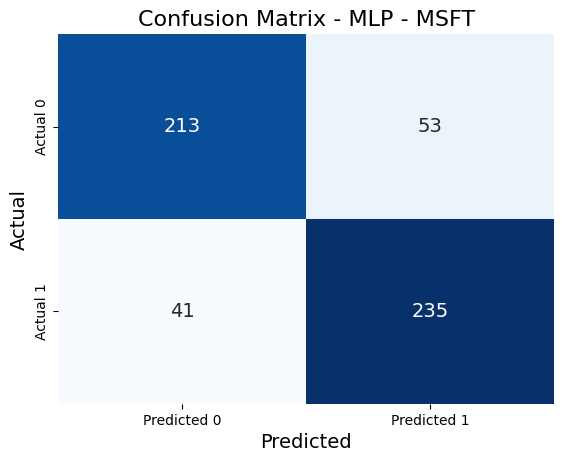

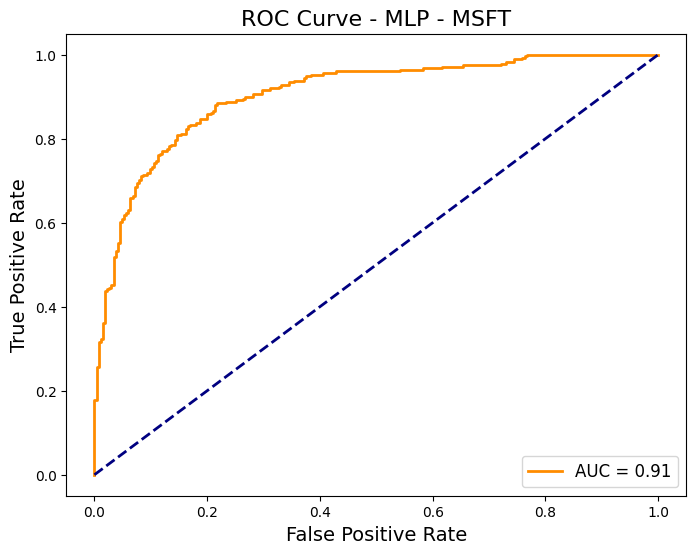

17/17 [==============================] - 0s 6ms/step
MLP Accuracy for GOOGL: 0.8265682656826568


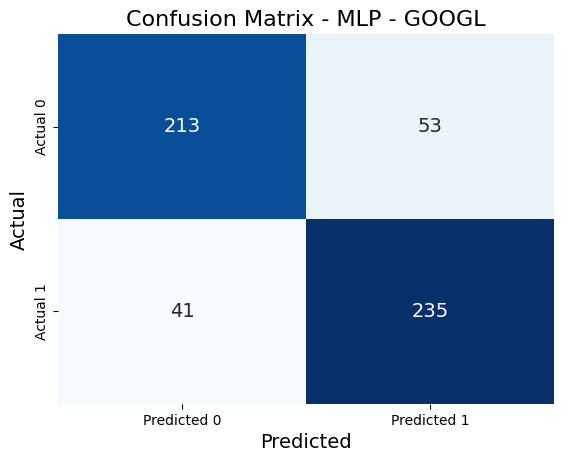

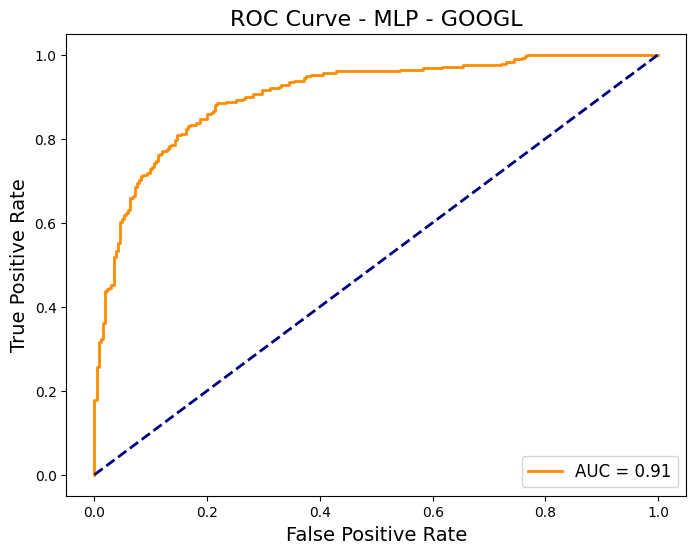

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                annot_kws={'size': 14}, xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(title, fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_prob, title='ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.show()

for symbol in symbols:

    # Evaluate LSTM accuracy
    # y_prob_lstm = model_lstm.predict(X_test_lstm)
    # y_pred_lstm = (y_prob_lstm > 0.5).astype(int)
    # accuracy_lstm = accuracy_score(y_test_lstm, y_pred_lstm)
    # print(f'LSTM Accuracy for {symbol}: {accuracy_lstm}')

    # # Plot confusion matrix for LSTM
    # plot_confusion_matrix(y_test_lstm, y_pred_lstm, title=f'Confusion Matrix - LSTM - {symbol}')

    # # Plot ROC curve for LSTM
    # plot_roc_curve(y_test_lstm, y_prob_lstm, title=f'ROC Curve - LSTM - {symbol}')

    # Evaluate MLP accuracy
    y_prob_mlp = model_mlp.predict(X_test)
    y_pred_mlp = (y_prob_mlp > 0.5).astype(int)
    accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
    print(f'MLP Accuracy for {symbol}: {accuracy_mlp}')

    # Plot confusion matrix for MLP
    plot_confusion_matrix(y_test, y_pred_mlp, title=f'Confusion Matrix - MLP - {symbol}')

    # Plot ROC curve for MLP
    plot_roc_curve(y_test, y_prob_mlp, title=f'ROC Curve - MLP - {symbol}')


**Evaluating the best Model**

In [ ]:
# Assuming 'history' is the output of the 'fit' method of your model
history = model_mlp.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping_mlp], verbose=0)

# Get the training accuracy
training_accuracy = history.history['accuracy']

# Get the testing accuracy
testing_accuracy = history.history['val_accuracy']

print(f'Training Accuracy: {training_accuracy[-1]}')
print(f'Testing Accuracy: {testing_accuracy[-1]}')


Training Accuracy: 0.8213627934455872
Testing Accuracy: 0.8284133076667786


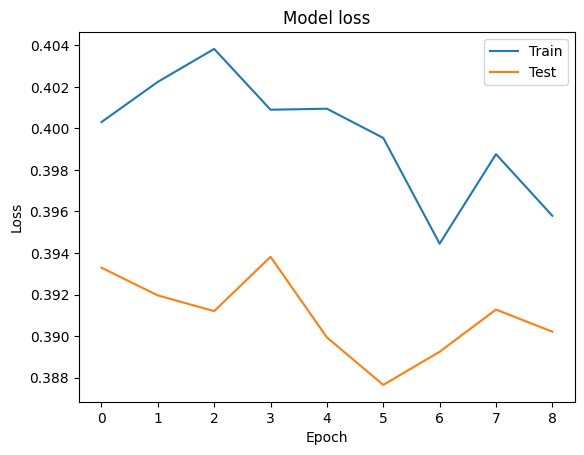

In [ ]:
import matplotlib.pyplot as plt

history = model_mlp.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping_mlp], verbose=0)

# Plotting the learning curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming 'y_test' are the true labels and 'y_pred' are the predicted labels
y_pred = (model_mlp.predict(X_test) > 0.7).astype(int)

print(classification_report(y_test, y_pred))


17/17 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       266
           1       0.90      0.71      0.80       276

    accuracy                           0.81       542
   macro avg       0.83      0.82      0.81       542
weighted avg       0.83      0.81      0.81       542



17/17 [==============================] - 0s 2ms/step


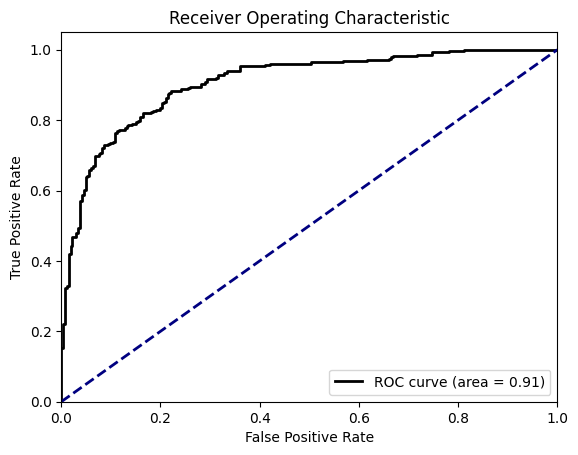

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'y_test' are the true labels and 'y_pred_proba' are the predicted probabilities
y_pred_proba = model_mlp.predict(X_test)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='black', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from tensorflow.keras.models import save_model

#Saving trained LSTM model with dropout
model_lstm_dropout.save("model_lstm_dropout.h5")

**2.Portfolio Allocation**

In [ ]:
import pandas as pd
from tensorflow.keras.models import load_model

# Load the saved model
model_lstm_dropout = load_model("/model_lstm_dropout.h5")

# Initialize an empty DataFrame to store the predictions
all_predictions = pd.DataFrame()

# Set transaction cost and initial total capital
transaction_cost = 0.01  # 1% transaction cost
total_capital = 1000000

# Initialize capital allocation DataFrame with initial capital
capital_allocation_df = pd.DataFrame({'Ticker': symbols, 'Allocation': total_capital / len(symbols)})

for symbol in symbols:
    # Download and process stock data
    df = process_stock_data(symbol)

    # Select features and target variable
    features = df[['RSI', 'MFI', 'EMA', '%K', '%D', 'ATR', 'ROC']]
    target = df['Trend']

    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Define sequence length
    sequence_length = 10

    # Create sequences for LSTM
    X, y = create_sequences(features_scaled, target, sequence_length)

    # Use the last sequence as input for the model
    recent_data = X[-1].reshape(1, sequence_length, -1)

    # Predict the future price
    predicted_price = model_lstm_dropout.predict(recent_data)
    print(f"Predicted price for {symbol}: {predicted_price}")

    # Store the predictions in the DataFrame
    all_predictions[symbol] = pd.Series(predicted_price.squeeze())
print(f"All predictions: \n{all_predictions}")

# Calculate weights based on predicted values
weights = all_predictions.values / all_predictions.values.sum(axis=1)[:, None]

# Format the output similar to the example
weights_df = pd.DataFrame(weights, columns=symbols)
print(f"Weights: \n{weights_df}")

# Allocate capital based on normalized predictions
capital_allocation = total_capital * weights

# Apply transaction cost
capital_allocation_after_cost = (1 - transaction_cost) * capital_allocation

# Rebalance capital allocation to maintain the same total capital
capital_allocation_after_rebalance = capital_allocation_after_cost / capital_allocation_after_cost.sum() * total_capital

# Update the capital allocation DataFrame
capital_allocation_df['Allocation'] = capital_allocation_after_rebalance.squeeze()

print("Capital Allocation:\n", capital_allocation_df)


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 436ms/step


[*********************100%%**********************]  1 of 1 completed

Predicted price for AAPL: [[0.1694652]]
1/1 [==============================] - 0s 26ms/step



[*********************100%%**********************]  1 of 1 completed

Predicted price for META: [[0.3777256]]
1/1 [==============================] - 0s 22ms/step



[*********************100%%**********************]  1 of 1 completed

Predicted price for AMZN: [[0.15004286]]
1/1 [==============================] - 0s 25ms/step



[*********************100%%**********************]  1 of 1 completed

Predicted price for MSFT: [[0.12287755]]


1/1 [==============================] - 0s 51ms/step
Predicted price for GOOGL: [[0.11300874]]
All predictions: 
        AAPL       META        AMZN        MSFT       GOOGL
0  0.1694652  0.3777256  0.15004286  0.12287755  0.11300874
Weights: 
       AAPL      META      AMZN      MSFT     GOOGL
0  0.181611  0.404799  0.160797  0.131685  0.121108
Capital Allocation:
   Ticker     Allocation
0   AAPL  181611.375374
1   META  404798.540509
2   AMZN  160796.971327
3   MSFT   131684.63209
4  GOOGL    121108.4807


**3. Trading Strategy and Back_Testing**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf


# Load the pre-trained model
model_lstm_dropout = tf.keras.models.load_model("model_lstm_dropout.h5")

# Set parameters for backtesting
n_train = 5000
n_test = 1000
sequence_length_model = 10
time_backtest = []
pred_backtest = []
ret_backtest = []

# 'X' input features and 'y' the target variable
for i in range(0, len(y) - n_train, n_test):
    print("i:", i)
    print("len(y):", len(y))
    print("df.shape:", df.shape)
    X_train, X_test = X[i : i + n_train], X[i + n_train : i + n_train + n_test]
    # Assuming your sequences have a length of 5 (evenly dividing 3790)


   # Trim X_test to a size that is evenly divisible by the product of the new shape
    X_test_trimmed = X_test[:sequence_length * (X_test.shape[0] // sequence_length)]

    # Reshape X_test to have the correct shape
    X_test_reshaped = X_test_trimmed.reshape((X_test_trimmed.shape[0] // sequence_length, sequence_length, -1))

    # Make predictions using the pre-trained model
    y_prob = model_lstm_dropout.predict(X_test_reshaped, verbose=0)
    y_pred = np.where(y_prob > 0.5, 1, -1)

    test_time = df.iloc[i + (n_train) : i + n_train + n_test, 0:1].values
    Ret_vector = df.iloc[i + (n_train) : i + n_train + n_test, 1:2].values

    # Update backtest arrays
    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())

# Create a DataFrame for backtest results
df_res = pd.DataFrame({"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest})
df_res["Date"] = pd.to_datetime(df_res["Date"], unit='s')

# Implement your strategy
df_res["Positions"] = np.where(df_res["Pred"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res.loc[df_res["Positions_L"] == -1, "Positions_L"] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

# Calculate final returns
Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

# Print final results
print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")


Strat Return Long Only = 0.0 %
Strat Return = 0.0 %
Buy and Hold Return = 0.0 %


In [ ]:
pred_backtest

[]

In [ ]:
ret_backtest

[]

In [ ]:
print(test_time)

[]


In [ ]:
Ret_vector

array([], shape=(0, 1), dtype=float64)

In [ ]:
df_res


,Date,Pred,Ret,Positions,Positions_shift,Strat_ret,Positions_L,Strat_ret_L,CumRet,CumRet_L,bhRet
